<a href="https://colab.research.google.com/github/Talendar/stocks_prices_prediction/blob/main/multi_stocks_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction of Stocks Prices with Deep Learning**

#### **Imports and installs**

In [1]:
import numpy as np
import pandas as pd
from timeit import default_timer as timer

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, Javascript, clear_output
import os
import shutil
from datetime import datetime

!pip install tensorflow==2.4.0-rc4 --quiet
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
tf.keras.backend.set_floatx('float64')

!pip install scikit-learn==0.24.0rc1 --quiet

!pip install yahooquery --quiet
from yahooquery import Ticker

!rm -rf stocks
!git clone https://github.com/Talendar/stocks_prices_prediction stocks --quiet

%load_ext autoreload
%autoreload 2

from stocks.aux.stocks_data import MultiStocksDataset
from stocks.aux.eval import *
from stocks.aux.normalization import *
from stocks.aux.tf_callbacks import ClearCallback
from stocks.technical_indicators.moving_averages import sma, ema, macd

try:
  from google.colab import files
  COLAB = True
except ImportError:
  COLAB = False

if COLAB: Javascript("google.colab.output.setIframeHeight('100px');")

     |████████████████████████████████| 394.6MB 40kB/s 
     |████████████████████████████████| 3.8MB 44.1MB/s 
     |████████████████████████████████| 14.5MB 248kB/s 
     |████████████████████████████████| 10.6MB 147kB/s 
     |████████████████████████████████| 471kB 59.2MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 22.2MB 68.0MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 5.8MB 17.3MB/s 
     |████████████████████████████████| 911kB 50.6MB/s 


####**Settings**

In [2]:
NUM_SESSIONS = 5  # number of previous trading sessions the model will analyse in order to make a prediction
NORMALIZE_LABELS = True

TRAIN_PC, VAL_PC, TEST_PC = .85, .10, .05
assert (TRAIN_PC + VAL_PC + TEST_PC) == 1

NUM_SESSIONS_PER_STOCK_PER_BATCH = 3
MAX_ZERO_VOL_PC = 0.2
INTERVAL = "1d"

LABELS_NAMES = [    # values that the model will try to predict
    "open", "low", "high",
]

TECHNICAL_INDICATORS_COLS = ["close", "open", "high", "low"]
TECHNICAL_INDICATORS = [
    # simple moving average
    (sma, {"n": 5}),
    (sma, {"n": 10}),
    (sma, {"n": 20}),
    (sma, {"n": 50}),
    (sma, {"n": 100}),

    # exponential moving average
    (ema, {"n": 5}),
    (ema, {"n": 10}),
    (ema, {"n": 20}),
    (ema, {"n": 50}),
    (ema, {"n": 100}),

    # moving average convergence divergence
    (macd, {}),
]

NAME_LIST = set([
    # South America
    "^BVSP",                                        # Brazil
    # North America
    "^DJI", "^GSPC", "^IXIC", "^NYA", "^RUT",       # US
    "^MXX",                                         # Mexico
    "^GSPTSE",                                      # Canada
    # Europe
    "^FTSE", "^FCHI", "^GDAXI", "^IBEX", "^AEX", "^ATX", #"^N100",  "^BFX", 
    # Asia
    "000001.SS", "^HSI",                            # China "^TWII"  "399001.SZ"
    "^N225",                                        # Japan
    "^KS11",                                        # S. Korea 
    "^BSESN",                                       # India
    # Oceania
    "^AORD",                                        # Australia
    
])

# loading stocks with specific params:
STOCKS = {
}

# loading stocks from NAME_LIST with default info (same params for all):
STOCKS.update({name: {"start": "2007-01-01",
                      "end": "2020-12-11",
                      "period": None} \
               for name in NAME_LIST})

## **1) Preparing the data**

####**1.1) Fetching and pre-processing the data**

In [3]:
ts = timer()
sess_counter = i = 0
removed_symbols = []
multi_data = {}
for name, info in STOCKS.items():
    clear_output(wait=True)
    print(f"[{100 * i / len(STOCKS) : .0f}%] Processing symbol \"{name}\".")
    i += 1

    print("Fetching data... ", end="")
    hist = Ticker(name).history(
        start=info["start"],
        end=info["end"],
        period=info["period"], 
        interval=INTERVAL
    ).reset_index("symbol", drop=True)
    hist = hist[["high", "close", "open", "low", "volume"]]
    
    print(" done!")
    zero_vols_pc = hist["volume"].isin([0]).sum() / len(hist)
    if zero_vols_pc > MAX_ZERO_VOL_PC:
        removed_symbols.append(name)
    else:
        print("Calculating technical indicators... ", end="")
        for func, params in TECHNICAL_INDICATORS:
            hist.index = pd.to_datetime(hist.index)
            hist = pd.concat([hist, 
                              func(hist[TECHNICAL_INDICATORS_COLS], **params)], axis=1)

        sess_counter += len(hist)
        multi_data[name] = hist


clear_output(wait=True)
print("Building multi-stocks dataset... ", end="")

multi_data = MultiStocksDataset(
    stocks=multi_data, 
    num_sessions=NUM_SESSIONS,
    labels_names=LABELS_NAMES,
    batch_size=len(multi_data) * NUM_SESSIONS_PER_STOCK_PER_BATCH,
    data_split_pc=(TRAIN_PC, VAL_PC, TEST_PC),
    feature_normalization=(min_max_norm, min_max_denorm), 
    label_normalization=(min_max_norm, min_max_denorm) \
                        if NORMALIZE_LABELS else None,
)

print(f"done! Elapsed time: {timer() - ts : .2f}s")
print(f"Number of trading sessions: {sess_counter}")

if removed_symbols:
    print(f"WARNING: {len(removed_symbols)} symbols removed because {100*MAX_ZERO_VOL_PC : .2f}% " 
          f"or more of their volumes are 0! List: {removed_symbols}")

Building multi-stocks dataset... done! Elapsed time:  12.63s
Number of trading sessions: 69789


#### **1.2) Inspecting the data**



###################################   ^BVSP   ###################################

. Period: from 2007-01-02 00:00:00 to 2020-12-10 00:00:00
. Trading sessions: 3444
. Zero volumes:  1.22%
. Data:



,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-01-02,45388.0,45383.0,44476.0,44476.0,75560200.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,45383.000000,44476.000000,45388.000000,44476.000000,45383.000000,44476.000000,45388.000000,44476.000000,45383.000000,44476.000000,45388.000000,44476.000000,45383.000000,44476.000000,45388.000000,44476.000000,45383.000000,44476.000000,45388.000000,44476.000000,0.000000,0.000000,0.000000,0.000000
2007-01-03,45379.0,44445.0,45379.0,44284.0,122372800.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,45070.333333,44777.000000,45385.000000,44412.000000,45212.454545,44640.181818,45386.363636,44441.090909,45293.666667,44562.000000,45387.142857,44457.714286,45346.215686,44511.411765,45387.647059,44468.470588,45364.425743,44493.881188,45387.821782,44472.198020,-74.826211,72.034188,-0.717949,-15.316239
2007-01-04,44442.0,44020.0,44442.0,43623.0,86577000.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,44720.222222,44665.333333,45070.666667,44149.000000,44995.644628,44604.148760,45214.661157,44292.347107,45172.365079,44550.571429,45297.129252,44378.217687,45294.207228,44508.689735,45350.562860,44435.314879,45337.803451,44492.853838,45369.092638,44455.382217,-166.501149,52.903889,-76.018701,-79.870943
2007-01-05,44081.0,42245.0,44019.0,42160.0,164055000.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,43895.148148,44449.888889,44740.777778,43486.000000,44495.527423,44497.758077,45008.540947,43904.647633,44893.568405,44499.945578,45181.307418,44166.958860,45174.630474,44489.486216,45300.776082,44346.086844,45276.559818,44483.470594,45343.585853,44409.929104,-378.024235,3.569279,-162.946428,-246.244332
2007-01-08,42926.0,42830.0,42249.0,42144.0,114007100.0,43784.6,44113.0,44443.2,43337.4,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,43540.098765,43716.259259,44135.851852,43038.666667,44192.704255,44088.892972,44629.897138,43584.529882,44697.038081,44285.569809,44966.516236,43974.296111,45082.684181,44401.624011,45207.647608,44259.730498,45228.113089,44439.223651,45295.712866,44365.059221,-492.772815,-176.320449,-321.332010,-375.064003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-04,113864.0,113682.0,112294.0,112294.0,8892900.0,111727.6,111013.0,112466.0,110494.6,110673.8,109864.1,111222.5,109477.8,107733.95,107038.50,108400.70,106502.30,101564.56,101226.66,102465.14,100453.90,101571.99,101416.82,102503.08,100466.70,112142.524655,111184.843094,112633.294658,110901.397831,110607.725894,109814.881837,111190.166724,109407.693055,107990.205024,107328.528091,108664.890040,106790.021721,103928.626615,103505.279504,104749.944460,102766.667304,101178.477493,100910.950359,102118.630036,100014.087171,3232.721807,3072.924946,3119.947071,3228.438138
2020-12-07,114531.0,113625.0,113751.0,112629.0,9633900.0,112675.0,111643.6,113185.4,111254.6,111298.4,110634.2,111926.1,110135.7,108375.25,107688.50,109080.85,107141.90,101922.36,101555.80,102807.98,100791.92,101703.84,101567.34,102642.07,100610.10,112636.683103,112040.228729,113265.863105,111477.265


. Statistics:



,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
count,3444.000000,3444.000000,3444.000000,3444.000000,3.444000e+03,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.00000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000,3444.000000
mean,65284.796748,64631.428571,64610.923345,63941.740418,8.227454e+06,64539.438269,64519.094077,65192.051394,63850.736934,64426.322154,64406.186498,65078.001220,63738.848229,64203.834422,64184.55887,64854.000798,63518.645616,63561.811278,63544.676551,64206.690383,62884.010610,62507.041789,62490.780258,63142.065682,61840.527393,64591.825688,64571.140968,65244.799051,63902.332406,64543.888250,64522.906155,65196.358781,63854.533707,64453.470964,64431.925095,65104.875921,63764.485203,64204.619920,64180.459149,64852.188956,63516.635033,63815.613422,63785.848480,64455.676463,63129.496745,123.419275,124.291388,124.988738,122.893357
std,17720.377095,17642.604868,17619.567689,17534.695049,2.271688e+07,17706.202161,17684.154695,17792.700496,17598.069513,17791.645624,17771.125964,17883.681199,17679.278765,17965.499966,17947.72917,18067.241277,17844.973477,18521.358177,18508.458654,18644.841077,18381.520002,19444.414518,19431.359689,19594.441596,19276.628184,17568.935592,17547.574787,17654.867746,17461.812042,17486.246132,17466.836419,17576.525704,17376.669513,17327.702106,17312.085051,17424.854634,17214.200736,16909.508239,16901.636488,17020.558675,16788.425967,16341.511417,16342.118889,16464.291658,16216.449005,1312.016135,1307.685720,1278.615985,1342.370660
min,31480.000000,29435.000000,29438.000000,29435.000000,0.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,32883.241654,32882.358711,34468.570858,31290.359296,34537.751407,34536.685904,35681.487500,33320.401442,35551.247816,35552.024711,36445.587997,34433.193510,38514.315224,38514.930883,39479.685434,37498.114457,40537.899598,40537.578093,41375.620022,39706.227205,-12198.398680,-12110.889486,-11304.872915,-12664.484815
25%,53320.250000,52773.750000,52763.250000,52195.250000,2.244275e+06,52805.950000,52801.000000,53308.550000,52266.150000,52773.225000,52767.900000,53348.275000,52151.850000,52781.750000,52762.11250,53317.325000,52172.912500,52592.190000,52591.500000,53099.245000,52047.500000,52035.152500,52033.490000,52556.192500,51496.770000,52845.800038,52844.655433,53383.190165,52205.382948,52840.552657,52838.834252,53373.850383,52246.825107,52763.366502,52756.441625,53282.617563,52221.407415,52391.365445,52375.529600,52903.747457,51862.056071,52070.024652,52068.623371,52576.197025,51518.190570,-491.389259,-486.132429,-495.798519,-490.921617
50%,61201.500000,60460.000000,60451.000000,59820.000000,3.313500e+06,60638.900000,60613.500000,61249.300000,59900.800000,60607.900000,60591.050000,61274.600000,59921.550000,60335.800000,60331.35000,60926.450000,59803.525000,60166.310000,60162.110000,60664.650000,59668.340000,59507.220000,59507.500000,60138.650000,58956.095000,60630.540402,60628.206494,61285.252095,59924.528822,60615.753172,60614.914585,611


. Plot:



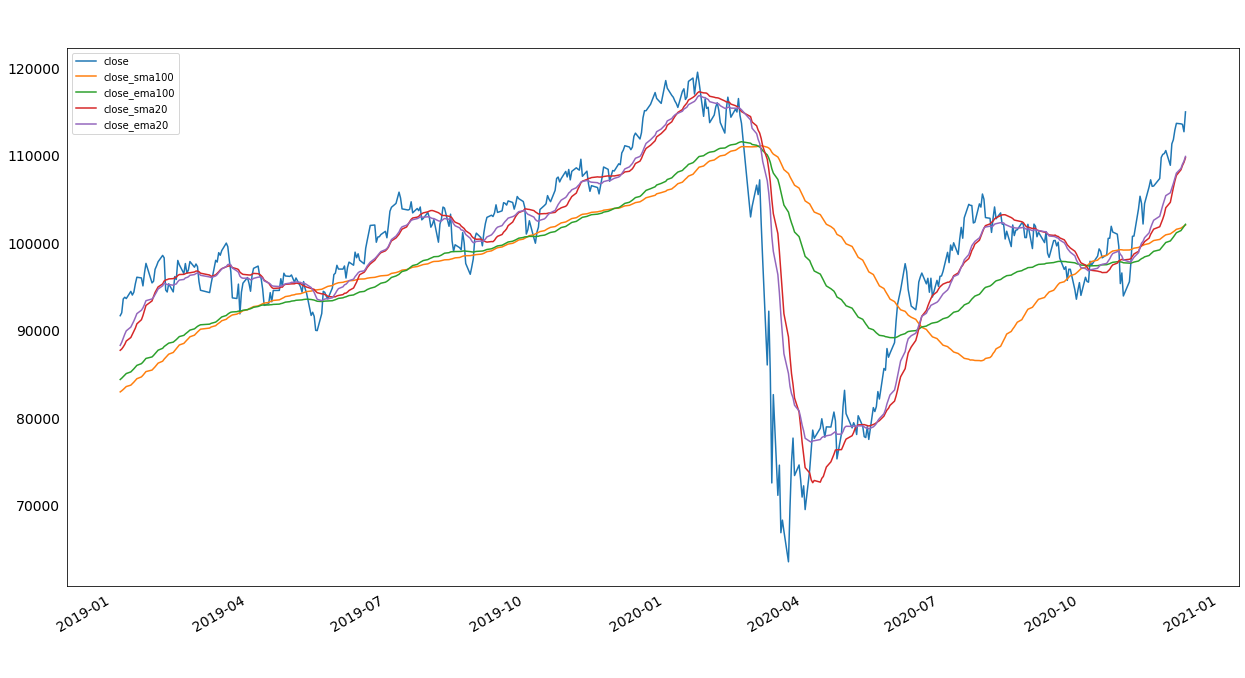

In [4]:
#@title
symbol = "^BVSP"  #@param {type:"string"}
cols_to_plot = "close close_sma100 close_ema100 close_sma20 close_ema20"  #@param {type:"string"}
date_from = "2019-01-04"  #@param {type:"string"}
date_to = "2020-12-10"  #@param {type:"string"}

pdata = multi_data[symbol].raw
zero_vols_pc = pdata["volume"].isin([0]).sum() / len(pdata)
print("\n\n" + "#"*35 + f"   {symbol}   " + "#"*35 + "\n\n" +
        f". Period: from {pdata.index[0]} to {pdata.index[-1]}\n" +
        f". Trading sessions: {len(pdata)}\n" +
        f". Zero volumes: {100*zero_vols_pc : .2f}%\n" 
        f". Data:\n")
display(pdata)

print(f"\n. Statistics:\n")
display(pdata.describe())

print(f"\n. Plot:\n")

pdata[cols_to_plot.split()] \
   [(pdata.index > date_from) & (pdata.index <= date_to)] \
        .plot(figsize=(21, 11))
        
plt.title(f"{symbol}\n", fontsize=18, color="#ffffff");
plt.xlabel("\nDate", fontsize="16", color="#ffffff");
plt.tick_params(axis='both', which='major', labelsize=14, color="#ffffff")
plt.show()

if COLAB: Javascript("google.colab.output.setIframeHeight('250px');")

In [5]:
# data division dates
for symbol, data in multi_data.stocks:
    print(f">>>>> {symbol}")
    print(". Training range: %s to %s" % (
        data.raw_train["features"].index[0], data.raw_train["features"].index[-1]))
    print(". Validation range: %s to %s" % (
        data.raw_val["features"].index[0], data.raw_val["features"].index[-1]))
    print(". Test range: %s to %s\n" % (
        data.raw_test["features"].index[0], data.raw_test["features"].index[-1]))
    
if COLAB: Javascript("google.colab.output.setIframeHeight('100px');")

>>>>> ^GSPC
. Training range: 2007-01-03 00:00:00 to 2018-10-30 00:00:00
. Validation range: 2018-10-31 00:00:00 to 2020-03-25 00:00:00
. Test range: 2020-03-26 00:00:00 to 2020-12-03 00:00:00

>>>>> ^RUT
. Training range: 2007-01-03 00:00:00 to 2018-10-29 00:00:00
. Validation range: 2018-10-30 00:00:00 to 2020-03-24 00:00:00
. Test range: 2020-03-25 00:00:00 to 2020-12-03 00:00:00

>>>>> ^IXIC
. Training range: 2007-01-03 00:00:00 to 2018-10-30 00:00:00
. Validation range: 2018-10-31 00:00:00 to 2020-03-25 00:00:00
. Test range: 2020-03-26 00:00:00 to 2020-12-03 00:00:00

>>>>> ^AEX
. Training range: 2007-01-02 00:00:00 to 2018-10-29 00:00:00
. Validation range: 2018-10-30 00:00:00 to 2020-03-23 00:00:00
. Test range: 2020-03-24 00:00:00 to 2020-12-03 00:00:00

>>>>> ^HSI
. Training range: 2007-01-02 00:00:00 to 2018-11-01 00:00:00
. Validation range: 2018-11-02 00:00:00 to 2020-03-24 00:00:00
. Test range: 2020-03-25 00:00:00 to 2020-12-03 00:00:00

>>>>> ^FTSE
. Training range: 200

In [6]:
# comparing normalized values of the training sets
print("#"*20 + " Normalized training data " + "#"*20)
for symbol, data in multi_data.stocks:
    print(f"\n>>>>> {symbol}")
    display(data.norm_train["features"].tail())

if COLAB: Javascript("google.colab.output.setIframeHeight('150px');")

#################### Normalized training data ####################

>>>>> ^GSPC


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-24,0.911687,0.878162,0.911897,0.878238,0.353200,0.937428,0.944840,0.946992,0.933548,0.943580,0.947998,0.950395,0.938064,0.971337,0.975344,0.976667,0.968906,0.993945,0.995396,0.995777,0.993201,0.999679,0.999987,0.999977,0.999588,0.912691,0.924490,0.926442,0.906844,0.928744,0.937165,0.939203,0.923213,0.950807,0.956838,0.958764,0.946583,0.979440,0.982895,0.983750,0.977789,0.992561,0.994242,0.994763,0.991695,0.262641,0.308766,0.308282,0.287404
2018-10-25,0.902829,0.900107,0.883994,0.885295,0.346054,0.933101,0.936146,0.941307,0.927559,0.942800,0.944509,0.947924,0.936601,0.967754,0.971276,0.973164,0.964745,0.993162,0.994334,0.995049,0.992264,0.999526,0.999726,0.999871,0.999334,0.909524,0.912464,0.919413,0.900779,0.924237,0.928467,0.933274,0.917107,0.946605,0.950646,0.954104,0.941436,0.977037,0.979770,0.981312,0.974923,0.991448,0.992782,0.993671,0.990328,0.247446,0.258262,0.278319,0.262307
2018-10-26,0.889328,0.879311,0.880885,0.867740,0.362196,0.925633,0.928774,0.934119,0.918499,0.939088,0.940996,0.945080,0.933128,0.963366,0.967116,0.969256,0.959931,0.991899,0.993199,0.993955,0.990848,0.999124,0.999424,0.999590,0.998907,0.900405,0.903398,0.910180,0.890816,0.916682,0.920772,0.925916,0.908849,0.940741,0.944735,0.948551,0.935039,0.973846,0.976636,0.978398,0.971423,0.989888,0.991281,0.992297,0.988591,0.209817,0.218281,0.238915,0.222875
2018-10-29,0.895771,0.871574,0.887436,0.856848,0.349786,0.917786,0.922531,0.929202,0.908508,0.935338,0.938219,0.942722,0.928139,0.958496,0.962931,0.965313,0.954512,0.990449,0.992118,0.992926,0.989245,0.998667,0.999098,0.999332,0.998351,0.891718,0.899563,0.906195,0.880501,0.909061,0.915695,0.921092,0.900067,0.934667,0.940037,0.944165,0.928171,0.970452,0.973902,0.975871,0.967599,0.988184,0.989957,0.991095,0.986643,0.173849,0.200989,0.221625,0.181832
2018-10-30,0.886233,0.889931,0.868845,0.870917,0.391265,0.913812,0.917036,0.924553,0.904662,0.930981,0.933895,0.938355,0.923627,0.954358,0.958068,0.961099,0.949617,0.989238,0.990638,0.991719,0.987746,0.998326,0.998656,0.999001,0.997896,0.892113,0.890739,0.900326,0.878369,0.906240,0.908081,0.915374,0.895497,0.930993,0.933941,0.939253,0.923352,0.967971,0.970486,0.973039,0.964521,0.986927,0.988240,0.989703,0.985051,0.177169,0.165268,0.198570,0.174352



>>>>> ^RUT


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-23,0.852254,0.846754,0.853691,0.835666,0.349118,0.894962,0.902771,0.902222,0.892431,0.900867,0.906142,0.909399,0.897313,0.934604,0.939679,0.941120,0.932877,0.982618,0.984332,0.984598,0.982023,0.995530,0.996231,0.996431,0.995269,0.864377,0.870880,0.871151,0.859754,0.881708,0.887505,0.889608,0.878656,0.912130,0.917418,0.919075,0.909676,0.955513,0.958977,0.959759,0.954326,0.980280,0.982186,0.982486,0.979570,0.133655,0.158684,0.149693,0.130728
2018-10-24,0.845441,0.805330,0.846249,0.812164,0.382152,0.881025,0.894721,0.894328,0.880499,0.894700,0.900661,0.904001,0.891114,0.928135,0.934384,0.935825,0.926394,0.979989,0.982576,0.982643,0.979572,0.994433,0.995503,0.995674,0.994238,0.845635,0.863974,0.862954,0.844375,0.868734,0.881190,0.882328,0.867358,0.902767,0.911676,0.912806,0.901087,0.950153,0.955239,0.955813,0.949244,0.977337,0.980142,0.980330,0.976773,0.071741,0.142288,0.126144,0.083179
2018-10-25,0.830351,0.828013,0.806038,0.813657,0.375326,0.874068,0.881092,0.884907,0.870653,0.892100,0.894618,0.899731,0.886768,0.922617,0.927965,0.930321,0.920006,0.977989,0.979980,0.980482,0.977295,0.993458,0.994416,0.994740,0.993150,0.840814,0.845794,0.852403,0.834625,0.862368,0.868510,0.873558,0.858393,0.896572,0.902459,0.905630,0.893464,0.945973,0.949932,0.951379,0.944425,0.974968,0.977227,0.977876,0.974065,0.058856,0.083299,0.093668,0.053901
2018-10-26,0.826400,0.816149,0.827295,0.805455,0.390745,0.867356,0.874118,0.877031,0.861439,0.888466,0.891919,0.895909,0.882598,0.916443,0.922461,0.924582,0.913367,0.975618,0.977732,0.978256,0.974884,0.992317,0.993436,0.993707,0.991925,0.833587,0.840851,0.844036,0.825365,0.854937,0.862107,0.865645,0.849530,0.889776,0.896246,0.898743,0.885751,0.941451,0.945741,0.946952,0.939446,0.972377,0.974851,0.975381,0.971225,0.039593,0.070366,0.068988,0.027065
2018-10-29,0.835037,0.811491,0.816566,0.807251,0.378891,0.860187,0.867521,0.872653,0.852856,0.884086,0.888366,0.893084,0.878192,0.910764,0.916292,0.919073,0.907301,0.973085,0.975381,0.976147,0.972308,0.991186,0.992300,0.992721,0.990736,0.827193,0.833933,0.841371,0.819797,0.847984,0.854864,0.860781,0.842613,0.883160,0.889551,0.893373,0.878952,0.936906,0.941255,0.943065,0.934740,0.969731,0.972279,0.973131,0.968483,0.024926,0.052683,0.066996,0.015035



>>>>> ^IXIC


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-24,0.897668,0.853635,0.901461,0.856129,0.626504,0.913930,0.925857,0.927996,0.911099,0.928704,0.933954,0.937102,0.923322,0.957840,0.963807,0.965077,0.956027,0.989546,0.991545,0.992072,0.988685,0.999211,0.999608,0.999673,0.999102,0.894194,0.910282,0.914137,0.889937,0.916244,0.926253,0.929193,0.911011,0.939505,0.946488,0.948498,0.935200,0.971862,0.975654,0.976793,0.969761,0.989595,0.991549,0.992131,0.988617,0.102736,0.172679,0.137919,0.138710
2018-10-25,0.887273,0.884323,0.868312,0.867802,0.581782,0.909805,0.915483,0.921781,0.904293,0.928571,0.931578,0.935508,0.922127,0.953317,0.958658,0.960678,0.950754,0.988396,0.989999,0.990897,0.987280,0.998801,0.999064,0.999316,0.998555,0.892351,0.897512,0.906999,0.884361,0.912426,0.917252,0.923369,0.905116,0.935528,0.940047,0.943809,0.930027,0.969335,0.972229,0.974138,0.966673,0.988371,0.989893,0.990884,0.987088,0.095605,0.116418,0.107190,0.115940
2018-10-26,0.875317,0.862232,0.857693,0.849965,0.633251,0.902835,0.905454,0.914394,0.895067,0.924461,0.926809,0.932611,0.918230,0.947821,0.953036,0.955812,0.944730,0.986782,0.988228,0.989473,0.985406,0.998131,0.998387,0.998795,0.997826,0.883677,0.885427,0.898213,0.874633,0.905186,0.907918,0.916386,0.896977,0.929751,0.933177,0.938393,0.923591,0.965990,0.968499,0.971093,0.962966,0.986689,0.988040,0.989403,0.985200,0.058524,0.060156,0.067352,0.075692
2018-10-29,0.877120,0.845141,0.879316,0.830274,0.569719,0.892489,0.900147,0.908847,0.882597,0.919719,0.924305,0.930062,0.912258,0.941652,0.947916,0.950758,0.937838,0.984848,0.986930,0.988129,0.983302,0.997381,0.997842,0.998282,0.996955,0.872134,0.884641,0.892964,0.861512,0.896079,0.904292,0.911007,0.886658,0.922838,0.929084,0.933670,0.915831,0.962066,0.965809,0.968242,0.958589,0.984667,0.986693,0.987990,0.982920,0.006775,0.057561,0.044801,0.019293
2018-10-30,0.858231,0.861419,0.841934,0.841816,0.567817,0.885665,0.892454,0.901308,0.876170,0.913687,0.918274,0.923962,0.906100,0.936414,0.941623,0.945235,0.931666,0.983184,0.984870,0.986444,0.981307,0.996760,0.997086,0.997660,0.996189,0.869925,0.871549,0.883102,0.856654,0.891660,0.894392,0.903100,0.880361,0.918190,0.921712,0.927543,0.909946,0.958972,0.961679,0.964723,0.954861,0.983040,0.984560,0.986195,0.980938,0.000000,0.000000,0.000000,0.000000



>>>>> ^AEX


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-23,0.833900,0.826574,0.836599,0.828985,0.209080,0.908293,0.914164,0.914564,0.907561,0.909568,0.914170,0.915684,0.907730,0.935283,0.938989,0.939205,0.934123,0.967966,0.969650,0.969182,0.967734,0.986804,0.987841,0.987713,0.986872,0.852306,0.860437,0.859943,0.851453,0.864505,0.872260,0.872146,0.863534,0.888240,0.894480,0.894623,0.887119,0.932518,0.936309,0.935792,0.932533,0.964149,0.966158,0.966022,0.964163,0.555473,0.560966,0.556899,0.559103
2018-10-24,0.836825,0.818457,0.832286,0.824763,0.200077,0.901413,0.907383,0.908354,0.901382,0.906045,0.909761,0.911890,0.904164,0.931388,0.935398,0.935939,0.930386,0.966372,0.967857,0.967523,0.966197,0.985835,0.986927,0.986842,0.985966,0.842274,0.851364,0.852532,0.842978,0.856714,0.865292,0.865930,0.856813,0.882243,0.889059,0.889600,0.881717,0.928637,0.932764,0.932425,0.928907,0.961662,0.963886,0.963838,0.961818,0.538140,0.545539,0.543983,0.545692
2018-10-25,0.831827,0.832675,0.812077,0.815714,0.200843,0.897689,0.899535,0.902985,0.894516,0.905221,0.906865,0.909947,0.901926,0.927839,0.931359,0.932391,0.926407,0.964837,0.966049,0.965987,0.964426,0.984964,0.985842,0.985927,0.984969,0.840414,0.838482,0.845887,0.834256,0.853033,0.855778,0.859895,0.849605,0.878259,0.882107,0.884547,0.875911,0.925532,0.928474,0.928970,0.925025,0.959563,0.961182,0.961579,0.959306,0.536851,0.521411,0.532485,0.531234
2018-10-26,0.819731,0.817714,0.823952,0.805899,0.204633,0.891550,0.893853,0.896476,0.887036,0.903694,0.904424,0.907554,0.899194,0.924159,0.927568,0.928521,0.922366,0.963224,0.964370,0.964324,0.962669,0.984029,0.984966,0.984999,0.983980,0.834094,0.833909,0.837332,0.825110,0.847187,0.850235,0.852660,0.841855,0.873138,0.877021,0.878746,0.869662,0.921892,0.924871,0.925120,0.920865,0.957150,0.958811,0.959077,0.956610,0.527817,0.513394,0.517066,0.515594
2018-10-29,0.833342,0.822701,0.821742,0.825344,0.133130,0.888183,0.887253,0.891871,0.883244,0.902134,0.902977,0.906701,0.898348,0.920386,0.923885,0.925048,0.918668,0.961567,0.962716,0.962794,0.961018,0.983042,0.983998,0.984089,0.983016,0.831574,0.830114,0.836270,0.825613,0.843349,0.845282,0.849325,0.839185,0.869009,0.872195,0.874881,0.865981,0.918614,0.921314,0.922018,0.917722,0.954903,0.956435,0.956949,0.954429,0.526715,0.508146,0.517449,0.519390



>>>>> ^HSI


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-26,0.612555,0.618918,0.625624,0.626115,0.172301,0.768001,0.769882,0.772243,0.766527,0.775446,0.776452,0.778062,0.773440,0.808587,0.812698,0.812434,0.809413,0.856616,0.857758,0.857270,0.856572,0.901729,0.902390,0.902352,0.901431,0.632592,0.634183,0.633892,0.630639,0.650343,0.652695,0.652909,0.649065,0.683797,0.687717,0.687632,0.683981,0.764140,0.766407,0.765189,0.764407,0.824587,0.825329,0.825796,0.823644,0.355939,0.354362,0.337211,0.369033
2018-10-29,0.607660,0.623183,0.622212,0.626372,0.204201,0.759857,0.765559,0.764524,0.759966,0.772427,0.775092,0.775393,0.771313,0.804080,0.808103,0.807844,0.804652,0.855016,0.855996,0.855517,0.854869,0.899733,0.900495,0.900411,0.899434,0.627555,0.629766,0.626805,0.625282,0.644916,0.647868,0.646424,0.643515,0.678579,0.682864,0.681913,0.678655,0.759866,0.762324,0.760753,0.760071,0.821148,0.822006,0.822276,0.820178,0.351266,0.351393,0.328699,0.364368
2018-10-30,0.606896,0.612951,0.613615,0.623937,0.214345,0.755235,0.757972,0.758028,0.755229,0.769805,0.772289,0.773136,0.768674,0.799109,0.803263,0.803229,0.799752,0.853415,0.854655,0.853957,0.853374,0.897633,0.898482,0.898408,0.897370,0.620600,0.623790,0.621817,0.620847,0.638468,0.642222,0.640970,0.638491,0.672763,0.677546,0.676657,0.673573,0.755264,0.757984,0.756454,0.755786,0.817505,0.818520,0.818805,0.816716,0.343895,0.346247,0.323840,0.361523
2018-10-31,0.608759,0.630756,0.613061,0.631114,0.241153,0.753595,0.754039,0.753963,0.752209,0.768333,0.769746,0.770916,0.766934,0.795777,0.798657,0.799004,0.796041,0.851993,0.852977,0.852394,0.851834,0.895607,0.896417,0.896372,0.895272,0.622222,0.619611,0.619134,0.620434,0.636687,0.637493,0.636867,0.635802,0.669408,0.672675,0.672099,0.669750,0.751706,0.753786,0.752413,0.752019,0.814409,0.815088,0.815453,0.813514,0.350755,0.344122,0.323447,0.365575
2018-11-01,0.634312,0.650464,0.634518,0.653201,0.222160,0.756155,0.756842,0.757226,0.755492,0.768216,0.768385,0.770493,0.766716,0.793177,0.796153,0.796325,0.793461,0.850603,0.851675,0.851082,0.850540,0.893640,0.894407,0.894453,0.893265,0.630229,0.624390,0.626158,0.627983,0.639099,0.637859,0.638430,0.637977,0.668483,0.670580,0.670662,0.668679,0.749241,0.750796,0.749743,0.749476,0.811898,0.812297,0.812835,0.810965,0.369792,0.357161,0.340504,0.383415



>>>>> ^FTSE


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-29,0.811556,0.805012,0.785151,0.791757,0.193203,0.892480,0.892902,0.896629,0.889206,0.902399,0.902436,0.905001,0.900266,0.921217,0.924251,0.923868,0.920808,0.953022,0.954409,0.953406,0.953205,0.982131,0.982990,0.982799,0.982076,0.806483,0.802900,0.810654,0.800538,0.820590,0.820495,0.824368,0.818122,0.849020,0.851193,0.850796,0.847854,0.899120,0.901829,0.900499,0.900059,0.941508,0.943571,0.942389,0.942244,0.454492,0.438712,0.443159,0.448314
2018-10-30,0.805610,0.807211,0.805012,0.801793,0.185336,0.894544,0.892480,0.897070,0.890621,0.902096,0.902399,0.904976,0.900070,0.918381,0.921217,0.921067,0.917815,0.951575,0.953022,0.951964,0.951700,0.981210,0.982131,0.981890,0.981156,0.809626,0.806483,0.811393,0.805151,0.821095,0.820590,0.823548,0.818738,0.847287,0.849019,0.848399,0.845918,0.896619,0.899120,0.897764,0.897413,0.939541,0.941508,0.940309,0.940198,0.471235,0.454493,0.454689,0.465977
2018-10-31,0.828981,0.828332,0.807211,0.813673,0.224284,0.898767,0.894544,0.899916,0.892697,0.903042,0.902096,0.905905,0.900283,0.915911,0.918381,0.918734,0.914967,0.950435,0.951575,0.950823,0.950335,0.980454,0.981210,0.981104,0.980279,0.818976,0.809626,0.819926,0.812319,0.825610,0.821095,0.827430,0.821548,0.847962,0.847287,0.848710,0.845428,0.895192,0.896619,0.896214,0.895419,0.938138,0.939541,0.938853,0.938489,0.502885,0.471235,0.484760,0.491255
2018-11-01,0.829926,0.825262,0.828332,0.825007,0.259280,0.901596,0.898767,0.904031,0.897834,0.904170,0.903042,0.907018,0.901046,0.913948,0.915911,0.916517,0.912854,0.949238,0.950435,0.949679,0.949168,0.979680,0.980454,0.980345,0.979498,0.824155,0.818976,0.825939,0.821002,0.828708,0.825610,0.830790,0.826047,0.848248,0.847962,0.849092,0.846188,0.893678,0.895191,0.894769,0.894027,0.936686,0.938137,0.937448,0.937094,0.527515,0.502886,0.511323,0.521808
2018-11-02,0.837025,0.820543,0.825262,0.826919,0.198524,0.905548,0.901596,0.908928,0.904072,0.904740,0.904170,0.908632,0.902099,0.912498,0.913948,0.915072,0.911397,0.948015,0.949238,0.948627,0.947946,0.978798,0.979680,0.979565,0.978765,0.825987,0.824155,0.832390,0.827450,0.830326,0.828708,0.834922,0.830099,0.848004,0.848247,0.850191,0.847078,0.892007,0.893678,0.893708,0.892777,0.935146,0.936686,0.936248,0.935775,0.545114,0.527515,0.539689,0.549195



>>>>> ^BSESN


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-23,0.840037,0.835718,0.836373,0.838464,0.029698,0.889444,0.894526,0.895575,0.889149,0.895579,0.896223,0.898796,0.892617,0.919664,0.922998,0.924311,0.916589,0.981687,0.983274,0.983775,0.980633,0.998161,0.998604,0.998591,0.997759,0.855947,0.860286,0.861502,0.854843,0.869998,0.873812,0.875281,0.867512,0.898758,0.903034,0.904547,0.896026,0.951601,0.954580,0.955349,0.949554,0.981248,0.982830,0.983131,0.979896,0.175636,0.162486,0.167023,0.195088
2018-10-24,0.847426,0.841794,0.845044,0.837927,0.045171,0.883617,0.890404,0.890872,0.882999,0.894890,0.895063,0.897735,0.891296,0.916695,0.919450,0.920871,0.913321,0.979754,0.981339,0.981882,0.978569,0.997910,0.998328,0.998336,0.997430,0.853346,0.856788,0.857879,0.850365,0.866755,0.870272,0.871546,0.863522,0.895070,0.899238,0.900628,0.892027,0.948769,0.951760,0.952488,0.946572,0.979718,0.981341,0.981620,0.978271,0.178249,0.162771,0.165902,0.192730
2018-10-25,0.832385,0.830606,0.831281,0.832361,0.041428,0.877991,0.881318,0.881790,0.876917,0.892110,0.893213,0.895101,0.889230,0.912823,0.916096,0.917142,0.910028,0.977519,0.979227,0.979714,0.976384,0.997577,0.998028,0.998015,0.997105,0.847830,0.849798,0.850394,0.845477,0.862016,0.864805,0.865695,0.859209,0.890620,0.894432,0.895590,0.887848,0.945573,0.948465,0.949103,0.943468,0.977963,0.979569,0.979798,0.976551,0.171289,0.150525,0.151039,0.188475
2018-10-26,0.830369,0.819519,0.831222,0.823940,0.051160,0.873001,0.877269,0.877747,0.872519,0.890417,0.892470,0.893685,0.888105,0.908649,0.911976,0.913029,0.906005,0.975030,0.976987,0.977438,0.973899,0.997036,0.997671,0.997569,0.996656,0.840403,0.845118,0.844724,0.839341,0.856071,0.860321,0.860533,0.854091,0.885491,0.890077,0.890831,0.883221,0.942032,0.945297,0.945765,0.940124,0.975992,0.977830,0.977967,0.974672,0.157028,0.145309,0.141453,0.179409
2018-10-29,0.842663,0.842881,0.823875,0.825556,0.067881,0.872655,0.871402,0.874693,0.868680,0.888687,0.890549,0.891996,0.885662,0.905698,0.907878,0.909703,0.902205,0.973006,0.974598,0.975374,0.971508,0.996719,0.997172,0.997219,0.996151,0.843352,0.839512,0.845089,0.835803,0.855563,0.855280,0.858594,0.850209,0.883175,0.885405,0.887746,0.879196,0.939621,0.941940,0.943078,0.936981,0.974590,0.975959,0.976450,0.972868,0.178123,0.136776,0.153550,0.178537



>>>>> ^NYA


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-24,0.855422,0.822832,0.859241,0.830929,0.411070,0.909528,0.916558,0.918143,0.908421,0.921067,0.925395,0.927582,0.918337,0.953401,0.957059,0.957791,0.952462,0.991638,0.993033,0.992608,0.990978,0.997959,0.998474,0.998686,0.997707,0.863022,0.874921,0.875556,0.860978,0.885998,0.895163,0.896360,0.884294,0.919251,0.925988,0.926851,0.917738,0.972577,0.975997,0.977015,0.971354,0.987298,0.989215,0.989825,0.986518,0.448778,0.480550,0.478614,0.467783
2018-10-25,0.844431,0.838676,0.832456,0.834784,0.404563,0.904701,0.908473,0.912042,0.902429,0.919354,0.921301,0.924337,0.916057,0.949700,0.952976,0.954138,0.948307,0.990709,0.991912,0.991743,0.989968,0.997540,0.997968,0.998306,0.997215,0.857834,0.862208,0.866787,0.853670,0.879968,0.885627,0.888954,0.877139,0.913886,0.918959,0.921022,0.911696,0.969322,0.972131,0.973710,0.967752,0.985499,0.987123,0.988039,0.984527,0.432817,0.444812,0.453247,0.447481
2018-10-26,0.833122,0.823598,0.830669,0.819245,0.419261,0.897602,0.901632,0.905024,0.893722,0.915919,0.917747,0.921234,0.912650,0.945553,0.948983,0.950254,0.943722,0.989380,0.990716,0.990528,0.988523,0.996916,0.997431,0.997766,0.996565,0.849232,0.853126,0.857092,0.843542,0.872160,0.877486,0.880745,0.868353,0.907470,0.912415,0.914580,0.904638,0.965502,0.968336,0.970016,0.963585,0.983361,0.985027,0.986008,0.982194,0.408762,0.418237,0.425155,0.420307
2018-10-29,0.843468,0.819938,0.838967,0.816310,0.407961,0.891214,0.895875,0.900441,0.885807,0.912331,0.915123,0.918714,0.908265,0.941116,0.945001,0.946549,0.938905,0.987894,0.989554,0.989380,0.986960,0.996258,0.996876,0.997264,0.995839,0.842249,0.849887,0.854150,0.835798,0.865074,0.872400,0.875996,0.860611,0.901286,0.907349,0.909821,0.897950,0.961664,0.965069,0.966941,0.959448,0.981175,0.983178,0.984274,0.979836,0.389880,0.409054,0.416753,0.399930
2018-10-30,0.839208,0.839855,0.825847,0.830457,0.445730,0.888886,0.891835,0.897430,0.883498,0.908498,0.911675,0.914902,0.904740,0.937455,0.940698,0.942848,0.934702,0.986610,0.988065,0.988101,0.985453,0.995712,0.996241,0.996725,0.995210,0.844388,0.843276,0.850739,0.835420,0.863072,0.865748,0.871300,0.856946,0.897755,0.901414,0.905074,0.893350,0.958891,0.961330,0.963791,0.956116,0.979526,0.981042,0.982468,0.977871,0.398478,0.392555,0.409368,0.401197



>>>>> ^GDAXI


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-22,0.805932,0.794277,0.806925,0.796481,0.149334,0.865041,0.867509,0.869573,0.863671,0.872555,0.876209,0.877558,0.871043,0.899087,0.900898,0.901873,0.898282,0.922350,0.922852,0.922796,0.921958,0.948436,0.948852,0.949689,0.947246,0.811514,0.816013,0.816940,0.811787,0.825712,0.830175,0.830641,0.825721,0.846071,0.849336,0.850224,0.846285,0.879857,0.881292,0.881621,0.879394,0.914379,0.915139,0.915499,0.913546,0.299651,0.326066,0.311084,0.324587
2018-10-23,0.777295,0.769001,0.776813,0.769430,0.233183,0.857571,0.863497,0.863711,0.858022,0.867292,0.871750,0.873053,0.866723,0.895041,0.897085,0.898074,0.894052,0.920702,0.921365,0.921281,0.920287,0.947290,0.947725,0.948581,0.946103,0.800415,0.805591,0.805735,0.800753,0.817709,0.822862,0.822733,0.817926,0.840157,0.843964,0.844510,0.840528,0.876279,0.878020,0.878211,0.875886,0.912050,0.912990,0.913273,0.911263,0.268335,0.297602,0.279039,0.294589
2018-10-24,0.777065,0.760646,0.769851,0.763220,0.237793,0.849787,0.855879,0.856961,0.850513,0.863392,0.866677,0.868678,0.862623,0.890596,0.893169,0.894241,0.889692,0.918928,0.919625,0.919664,0.918565,0.946067,0.946602,0.947412,0.944883,0.790175,0.796280,0.798188,0.791283,0.809587,0.815567,0.816219,0.810376,0.833963,0.838402,0.839317,0.834693,0.872482,0.874576,0.874924,0.872248,0.909576,0.910724,0.911085,0.908882,0.237991,0.270742,0.256738,0.267582
2018-10-25,0.770289,0.772320,0.749652,0.754310,0.000000,0.845592,0.847017,0.850057,0.842931,0.861653,0.863233,0.865879,0.859314,0.886542,0.888303,0.890236,0.884970,0.917628,0.917649,0.917995,0.916974,0.944901,0.945289,0.946231,0.943613,0.787317,0.783217,0.790853,0.781934,0.805141,0.805794,0.809611,0.802517,0.829538,0.831331,0.833934,0.828512,0.869336,0.870398,0.871475,0.868368,0.907418,0.908042,0.908786,0.906345,0.230671,0.231099,0.235189,0.240297
2018-10-26,0.758249,0.761555,0.757963,0.751557,0.280768,0.840339,0.841106,0.843965,0.836250,0.859233,0.859413,0.862241,0.855830,0.881902,0.883992,0.885559,0.880360,0.916052,0.916098,0.916415,0.915267,0.943667,0.943989,0.944928,0.942299,0.781752,0.777329,0.781871,0.774764,0.799475,0.799364,0.801934,0.795568,0.824447,0.825772,0.827847,0.822642,0.865850,0.866742,0.867642,0.864521,0.905057,0.905603,0.906256,0.903795,0.216919,0.212791,0.208734,0.219787



>>>>> ^KS11


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-25,0.670236,0.677668,0.675100,0.673385,0.001442,0.822157,0.821888,0.822340,0.816799,0.836119,0.836293,0.836975,0.834064,0.871497,0.873138,0.874906,0.870121,0.901720,0.900987,0.901378,0.900813,0.923090,0.923440,0.923514,0.922868,0.706797,0.707186,0.701325,0.707074,0.727417,0.729947,0.726738,0.726996,0.762861,0.764735,0.763009,0.763061,0.808021,0.809352,0.808445,0.808380,0.860113,0.861152,0.860644,0.860301,0.362492,0.343235,0.330433,0.384353
2018-10-26,0.670547,0.655884,0.686991,0.658668,0.001723,0.812134,0.816961,0.815229,0.808322,0.830847,0.833745,0.832834,0.829332,0.865347,0.867912,0.869556,0.863863,0.899512,0.899102,0.899494,0.898544,0.921362,0.921795,0.921863,0.921059,0.690063,0.698187,0.689571,0.690744,0.714283,0.720983,0.716215,0.713714,0.752868,0.756964,0.754446,0.752829,0.801969,0.804326,0.803105,0.802180,0.856105,0.857704,0.857029,0.856213,0.330814,0.326021,0.306637,0.353284
2018-10-29,0.657863,0.637143,0.663155,0.649768,0.001639,0.799272,0.807928,0.806171,0.797165,0.825013,0.828710,0.828419,0.823529,0.858263,0.861908,0.863478,0.857177,0.897222,0.896961,0.897510,0.896266,0.919703,0.920109,0.920248,0.919421,0.672316,0.683719,0.677277,0.676726,0.699845,0.708922,0.705117,0.701073,0.741834,0.747379,0.745357,0.742610,0.795277,0.798376,0.797388,0.795799,0.851704,0.853720,0.853170,0.851978,0.296145,0.298328,0.282061,0.326225
2018-10-30,0.647551,0.648375,0.638818,0.645155,0.001694,0.792176,0.795408,0.796920,0.788690,0.819908,0.822054,0.823248,0.817462,0.851790,0.854621,0.857044,0.850222,0.895355,0.894725,0.895580,0.894241,0.918062,0.918331,0.918643,0.917687,0.664436,0.665426,0.665457,0.665758,0.690245,0.694227,0.694014,0.689812,0.733045,0.736096,0.736044,0.732866,0.789372,0.791515,0.791418,0.789450,0.847673,0.849198,0.849129,0.847708,0.280961,0.262368,0.258932,0.305654
2018-10-31,0.648562,0.657415,0.660861,0.657353,0.001431,0.786905,0.787931,0.789913,0.782029,0.814514,0.816317,0.817324,0.811453,0.845696,0.848189,0.850732,0.843758,0.893525,0.892916,0.893738,0.892310,0.916418,0.916739,0.916985,0.916026,0.662361,0.661063,0.657932,0.662738,0.684170,0.686576,0.685129,0.683029,0.726056,0.728252,0.727725,0.725368,0.784123,0.785960,0.785728,0.783929,0.843950,0.845325,0.845193,0.843836,0.279649,0.254741,0.245699,0.302300



>>>>> ^ATX


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-24,0.477524,0.458979,0.479238,0.465152,0.069834,0.641761,0.651324,0.650709,0.644025,0.650660,0.654852,0.655753,0.650859,0.669581,0.673056,0.673188,0.670436,0.678554,0.679632,0.679485,0.680050,0.695000,0.695534,0.695311,0.696119,0.489174,0.503616,0.500158,0.494964,0.504108,0.513870,0.512261,0.509369,0.515683,0.521952,0.520130,0.520123,0.522116,0.525362,0.522515,0.526798,0.508993,0.511910,0.507136,0.515263,0.584454,0.612186,0.616159,0.598697
2018-10-25,0.461811,0.464705,0.458634,0.460251,0.074622,0.634053,0.641723,0.641999,0.634786,0.647958,0.650711,0.652349,0.648074,0.666480,0.669660,0.670161,0.667243,0.677764,0.678655,0.678653,0.679103,0.694518,0.695078,0.694819,0.695624,0.481502,0.489100,0.487433,0.484335,0.497243,0.504111,0.503396,0.501078,0.510681,0.515759,0.514394,0.514434,0.519428,0.522293,0.519642,0.523838,0.507315,0.510049,0.505380,0.513449,0.567208,0.583737,0.590720,0.576581
2018-10-29,0.473746,0.465391,0.464499,0.470479,0.056281,0.627806,0.634026,0.636330,0.628923,0.645367,0.648004,0.650212,0.645422,0.663718,0.666542,0.667640,0.664556,0.676980,0.677869,0.678079,0.678400,0.693924,0.694593,0.694323,0.695133,0.476619,0.481410,0.482997,0.480731,0.491755,0.497225,0.498379,0.496219,0.506223,0.510742,0.510396,0.510313,0.516874,0.519597,0.517398,0.521438,0.505688,0.508366,0.503945,0.511916,0.555583,0.566407,0.579546,0.567102
2018-10-30,0.468009,0.469176,0.464670,0.470936,0.047365,0.622332,0.627669,0.630140,0.622930,0.642626,0.645364,0.647682,0.642895,0.660882,0.663725,0.664697,0.661749,0.676327,0.677071,0.677352,0.677678,0.693373,0.693993,0.693801,0.694608,0.474647,0.476342,0.478094,0.478484,0.487973,0.491624,0.493199,0.492329,0.502567,0.506219,0.506206,0.506630,0.514583,0.517015,0.514994,0.519152,0.504183,0.506721,0.502400,0.510425,0.550444,0.554397,0.568535,0.561504
2018-10-31,0.490166,0.489966,0.468955,0.475247,0.063348,0.623869,0.622192,0.628709,0.621757,0.640335,0.642611,0.645774,0.640143,0.658649,0.660891,0.662647,0.659102,0.675820,0.676426,0.676891,0.677054,0.692910,0.693440,0.693386,0.694062,0.480379,0.474416,0.482339,0.478454,0.488773,0.487843,0.493112,0.489959,0.501334,0.502555,0.504629,0.503731,0.513279,0.514718,0.513641,0.517142,0.503206,0.505210,0.501420,0.509067,0.561151,0.549286,0.575362,0.561427



>>>>> 000001.SS


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-22,0.217453,0.216214,0.203885,0.205842,0.247229,0.427109,0.423402,0.428087,0.426238,0.441591,0.441018,0.441712,0.442772,0.459491,0.458054,0.457961,0.461214,0.487633,0.486888,0.485843,0.490541,0.525068,0.524994,0.523448,0.527898,0.201184,0.196217,0.200584,0.197952,0.206748,0.204558,0.204987,0.206903,0.206331,0.206341,0.203174,0.209231,0.217695,0.217325,0.214648,0.221588,0.245619,0.245522,0.245838,0.246110,0.459330,0.462720,0.455078,0.462287
2018-10-23,0.213915,0.202520,0.223722,0.209868,0.208027,0.428727,0.426228,0.430138,0.427827,0.439449,0.439982,0.440462,0.440562,0.459002,0.457894,0.457863,0.460651,0.487235,0.486586,0.485485,0.490142,0.524047,0.524068,0.522530,0.526859,0.201783,0.204190,0.204214,0.202479,0.206191,0.207302,0.206059,0.207872,0.205076,0.206688,0.202869,0.208541,0.216396,0.216711,0.213826,0.220453,0.244229,0.244519,0.244745,0.244783,0.462341,0.477241,0.463583,0.471084
2018-10-24,0.209511,0.204451,0.207152,0.208613,0.186793,0.430117,0.426416,0.432049,0.429870,0.437369,0.437542,0.438732,0.438399,0.458173,0.457342,0.457356,0.460071,0.486601,0.486111,0.484990,0.489709,0.523053,0.523027,0.521588,0.525839,0.202849,0.203828,0.205120,0.205060,0.206112,0.206333,0.206082,0.208418,0.204147,0.205238,0.202125,0.207782,0.215242,0.215314,0.212821,0.219301,0.242922,0.243067,0.243551,0.243446,0.466947,0.478772,0.468048,0.478226
2018-10-25,0.201727,0.204567,0.198252,0.198047,0.189009,0.434033,0.426284,0.434071,0.431428,0.437714,0.435808,0.437806,0.437902,0.457083,0.456022,0.456170,0.458681,0.486096,0.485282,0.484371,0.488943,0.522087,0.521927,0.520595,0.524738,0.203599,0.200538,0.203047,0.203094,0.206071,0.203814,0.204591,0.206778,0.203319,0.202979,0.200625,0.205957,0.214139,0.213538,0.211479,0.217672,0.241643,0.241392,0.242162,0.241831,0.471532,0.475103,0.466958,0.477996
2018-10-26,0.206269,0.203437,0.214203,0.209315,0.185393,0.435646,0.431305,0.436473,0.435896,0.437577,0.436434,0.437977,0.438665,0.455964,0.454982,0.455171,0.457433,0.485392,0.484855,0.483746,0.488411,0.521260,0.521048,0.519746,0.523866,0.203709,0.203809,0.203227,0.205715,0.205816,0.204847,0.204252,0.207661,0.202449,0.202633,0.199751,0.205519,0.213024,0.212609,0.210409,0.216663,0.240358,0.240201,0.240928,0.240573,0.475212,0.483581,0.470058,0.486049



>>>>> ^IBEX


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-25,0.271913,0.283190,0.267604,0.274226,0.320953,0.553235,0.555503,0.556061,0.553711,0.560183,0.563462,0.563582,0.561692,0.576207,0.578742,0.578096,0.577687,0.596133,0.596933,0.596382,0.597057,0.632856,0.633647,0.632762,0.634002,0.270313,0.271309,0.266440,0.276231,0.271608,0.272988,0.270758,0.276207,0.275835,0.278389,0.274339,0.281919,0.292378,0.294316,0.288702,0.299967,0.297254,0.298692,0.292456,0.304379,0.515700,0.504670,0.523946,0.519198
2018-10-26,0.266705,0.277704,0.278212,0.273233,0.297131,0.551196,0.553880,0.553377,0.551919,0.559099,0.561256,0.561370,0.559972,0.574114,0.576447,0.575814,0.575534,0.595252,0.596030,0.595475,0.596115,0.632180,0.632971,0.632084,0.633275,0.268354,0.270095,0.262211,0.273150,0.268845,0.270185,0.266563,0.272614,0.272866,0.275346,0.270659,0.278453,0.290074,0.292000,0.286155,0.297433,0.295540,0.296980,0.290627,0.302540,0.514408,0.503107,0.516228,0.514972
2018-10-29,0.280438,0.286794,0.281158,0.285809,0.233968,0.551382,0.551077,0.551743,0.551368,0.558452,0.560576,0.561032,0.559357,0.572253,0.574511,0.573943,0.573565,0.594422,0.595166,0.594672,0.595231,0.631464,0.632267,0.631402,0.632574,0.270168,0.270304,0.264099,0.275412,0.268326,0.268460,0.265750,0.272083,0.271118,0.272899,0.268741,0.276611,0.288263,0.289906,0.284317,0.295556,0.294078,0.295374,0.289164,0.301039,0.522088,0.506092,0.522508,0.522888
2018-10-30,0.279563,0.285282,0.288502,0.288148,0.246785,0.552390,0.552770,0.552897,0.552569,0.556755,0.559828,0.559633,0.558351,0.570666,0.572923,0.572420,0.571935,0.593469,0.594376,0.593758,0.594349,0.630727,0.631541,0.630683,0.631820,0.270858,0.272982,0.265058,0.277722,0.267611,0.268466,0.264919,0.272098,0.269380,0.271447,0.266916,0.275185,0.286457,0.288223,0.282512,0.293856,0.292609,0.293977,0.287709,0.299623,0.528750,0.516004,0.528556,0.532658
2018-10-31,0.288470,0.294032,0.294672,0.298947,0.379942,0.555114,0.554594,0.554866,0.555192,0.556100,0.558550,0.558516,0.557819,0.569180,0.571495,0.570961,0.570599,0.592589,0.593576,0.592952,0.593537,0.630058,0.630883,0.630048,0.631181,0.274322,0.276900,0.268751,0.282968,0.268702,0.269663,0.265938,0.274178,0.268710,0.270774,0.266182,0.275006,0.285111,0.286883,0.281173,0.292701,0.291379,0.292757,0.286496,0.298494,0.542243,0.530324,0.541805,0.550024



>>>>> ^N225


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-16,0.890540,0.900011,0.880000,0.886907,0.117776,0.941100,0.939011,0.941363,0.936599,0.971165,0.972874,0.972552,0.969906,0.993826,0.993266,0.995135,0.993201,0.991786,0.991094,0.992121,0.991182,0.999411,0.999386,0.999350,0.999296,0.919466,0.913567,0.918976,0.913904,0.949364,0.946802,0.949201,0.945894,0.977167,0.977122,0.977918,0.975117,0.994136,0.994167,0.994813,0.993207,0.998521,0.998240,0.998721,0.998023,0.582589,0.581244,0.571458,0.587812
2018-10-17,0.914185,0.916965,0.909359,0.915710,0.121136,0.935592,0.932963,0.936180,0.931546,0.965212,0.966345,0.966389,0.963838,0.993292,0.992783,0.994829,0.992778,0.992059,0.991285,0.992419,0.991421,0.999583,0.999574,0.999548,0.999494,0.921434,0.915446,0.920729,0.917920,0.946849,0.943809,0.946411,0.944175,0.974880,0.974552,0.975536,0.973144,0.993623,0.993553,0.994306,0.992798,0.998607,0.998275,0.998820,0.998160,0.571302,0.567452,0.558134,0.580650
2018-10-18,0.909211,0.906338,0.913094,0.908260,0.108031,0.936150,0.931542,0.934715,0.933028,0.959163,0.960739,0.960644,0.958014,0.991683,0.992422,0.993551,0.991926,0.992189,0.991574,0.992624,0.991551,0.999661,0.999743,0.999691,0.999594,0.919144,0.917967,0.920203,0.918067,0.942792,0.942064,0.943190,0.941366,0.971734,0.972608,0.972875,0.970604,0.992662,0.993128,0.993597,0.992078,0.998438,0.998398,0.998798,0.998117,0.554223,0.560423,0.544019,0.569602
2018-10-19,0.890680,0.899014,0.882529,0.883600,0.113239,0.934803,0.931695,0.933403,0.932107,0.953152,0.952835,0.953622,0.950863,0.989277,0.989444,0.990841,0.988832,0.992076,0.991426,0.992524,0.991303,0.999737,0.999703,0.999740,0.999582,0.915135,0.909264,0.913542,0.909792,0.938095,0.934875,0.937054,0.934424,0.968146,0.967738,0.968578,0.965805,0.991416,0.991366,0.992094,0.990298,0.998098,0.997787,0.998330,0.997487,0.535555,0.529929,0.517926,0.541479
2018-10-22,0.897631,0.903820,0.884389,0.887027,0.105847,0.937648,0.930646,0.934651,0.932187,0.948285,0.946980,0.948420,0.944767,0.987041,0.986539,0.988510,0.986054,0.992051,0.991173,0.992414,0.991008,1.000000,0.999845,1.000000,0.999732,0.914092,0.904094,0.911468,0.905438,0.935156,0.929344,0.933346,0.929389,0.965387,0.963522,0.965399,0.961810,0.990430,0.989756,0.990959,0.988739,0.997879,0.997232,0.998039,0.996951,0.525965,0.508664,0.504397,0.523400



>>>>> ^DJI


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-24,0.918705,0.889309,0.918143,0.888977,0.598372,0.944330,0.949608,0.951421,0.941719,0.951402,0.954277,0.957455,0.946298,0.978845,0.981544,0.982971,0.976554,0.999167,0.999685,0.999918,0.998312,0.999910,1.000000,0.999896,0.999926,0.921205,0.930651,0.933994,0.916261,0.938392,0.944715,0.947748,0.933895,0.960688,0.965590,0.967805,0.957644,0.986068,0.988362,0.989600,0.984507,0.996921,0.997879,0.998532,0.995993,0.289725,0.327957,0.321334,0.319285
2018-10-25,0.908729,0.909087,0.896634,0.894507,0.528809,0.941368,0.942799,0.947039,0.937276,0.951145,0.951341,0.955286,0.945340,0.976094,0.978368,0.980237,0.973264,0.999030,0.999302,0.999818,0.998065,0.999982,0.999967,1.000000,0.999900,0.919203,0.921149,0.927917,0.911485,0.934887,0.937602,0.942604,0.928879,0.957347,0.960500,0.963848,0.953410,0.984377,0.986026,0.987793,0.982373,0.996289,0.996934,0.997875,0.995116,0.276794,0.285031,0.291987,0.297123
2018-10-26,0.899435,0.894480,0.898296,0.884646,0.609297,0.935699,0.937924,0.941870,0.930466,0.948695,0.948947,0.953221,0.943246,0.972748,0.975276,0.977227,0.969587,0.998360,0.998898,0.999288,0.997409,0.999802,0.999934,0.999910,0.999739,0.912929,0.915377,0.920720,0.904964,0.929286,0.932092,0.936657,0.922929,0.952860,0.956061,0.959337,0.948590,0.982121,0.983854,0.985656,0.979897,0.995334,0.996046,0.997018,0.994030,0.248799,0.256904,0.258053,0.269598
2018-10-29,0.905582,0.882381,0.900698,0.868752,0.533935,0.929141,0.932882,0.937983,0.922083,0.945659,0.947019,0.951567,0.939019,0.968574,0.971916,0.974033,0.964894,0.997417,0.998336,0.998762,0.996328,0.999489,0.999788,0.999799,0.999328,0.904656,0.912340,0.918002,0.895240,0.922438,0.928033,0.932941,0.915087,0.947587,0.952285,0.955872,0.942635,0.979432,0.981871,0.983868,0.976831,0.994119,0.995231,0.996318,0.992599,0.212934,0.241761,0.243794,0.229915
2018-10-30,0.898967,0.903668,0.884089,0.883194,0.566061,0.926765,0.928714,0.934990,0.919426,0.942186,0.943753,0.948157,0.935492,0.964984,0.967823,0.970424,0.960698,0.996737,0.997378,0.998085,0.995324,0.999316,0.999503,0.999635,0.999032,0.906337,0.904703,0.913951,0.893643,0.920820,0.921607,0.928662,0.911373,0.944950,0.947205,0.952074,0.938696,0.977767,0.979249,0.981865,0.974509,0.993418,0.994051,0.995481,0.991529,0.219416,0.209503,0.226200,0.222739



>>>>> ^BVSP


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-22,0.955206,0.964684,0.941128,0.947757,0.016678,0.978204,0.973166,0.977974,0.972796,0.981707,0.978650,0.985227,0.977284,0.959973,0.956771,0.963543,0.955447,0.926026,0.924567,0.928508,0.923394,0.924038,0.922721,0.925500,0.921469,0.963641,0.955771,0.964232,0.958321,0.964645,0.958885,0.968873,0.959771,0.945675,0.939570,0.950400,0.941186,0.909815,0.905062,0.912636,0.906212,0.922414,0.919243,0.925080,0.919020,0.923489,0.919909,0.913431,0.930104
2018-10-23,0.952092,0.959583,0.964715,0.944470,0.018893,0.977242,0.978170,0.977693,0.974213,0.980799,0.982442,0.983230,0.979278,0.964228,0.960347,0.967092,0.959066,0.928086,0.926168,0.930097,0.925282,0.925059,0.923861,0.926508,0.922495,0.966809,0.963242,0.964772,0.959199,0.968514,0.964873,0.970767,0.962393,0.950509,0.945526,0.954130,0.945379,0.914038,0.909715,0.916432,0.910091,0.925214,0.922239,0.927662,0.921612,0.919398,0.923192,0.902292,0.921789
2018-10-24,0.955452,0.921176,0.959681,0.927223,0.020146,0.971030,0.977222,0.976823,0.969793,0.977295,0.981571,0.982326,0.976478,0.966806,0.964607,0.971189,0.962600,0.929391,0.928229,0.931982,0.926960,0.925756,0.924880,0.927411,0.923401,0.955084,0.966410,0.966335,0.953729,0.963784,0.968737,0.972998,0.961056,0.950617,0.950355,0.957871,0.947286,0.916188,0.913936,0.920243,0.912973,0.926906,0.925037,0.930282,0.923685,0.886286,0.919075,0.892784,0.899930
2018-10-25,0.938650,0.938696,0.922266,0.928763,0.000000,0.971575,0.971157,0.974702,0.968121,0.977764,0.978139,0.980885,0.975830,0.969963,0.967219,0.974289,0.965292,0.930676,0.929548,0.933399,0.928290,0.926412,0.925582,0.928145,0.924110,0.953579,0.955050,0.961363,0.950622,0.963516,0.964207,0.971417,0.960274,0.952661,0.950572,0.959425,0.949180,0.919123,0.916135,0.923085,0.915818,0.929045,0.926756,0.932399,0.925759,0.869797,0.886647,0.870940,0.880975
2018-10-26,0.954291,0.966797,0.938757,0.935215,0.027863,0.975027,0.971707,0.976451,0.967727,0.981007,0.978585,0.982001,0.976869,0.973290,0.970365,0.977530,0.968117,0.932702,0.930830,0.935051,0.929866,0.927497,0.926238,0.928955,0.924964,0.962700,0.953415,0.963647,0.950817,0.969074,0.963890,0.973295,0.960936,0.957631,0.952598,0.962535,0.951600,0.923339,0.919066,0.926578,0.918867,0.931911,0.928892,0.934895,0.927967,0.873895,0.869965,0.861761,0.867983



>>>>> ^GSPTSE


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-25,0.822679,0.817421,0.825959,0.819642,0.349412,0.919896,0.925829,0.926369,0.919153,0.929236,0.932952,0.933226,0.927997,0.949462,0.953573,0.953130,0.949699,0.975869,0.977710,0.977281,0.976136,0.994350,0.995029,0.994991,0.994229,0.844300,0.856429,0.854579,0.845281,0.865167,0.875495,0.873619,0.866264,0.894985,0.902459,0.901098,0.895785,0.941638,0.946104,0.944694,0.942321,0.971500,0.974333,0.973335,0.972054,0.521032,0.517227,0.501729,0.543558
2018-10-26,0.816032,0.813444,0.808125,0.800512,0.313495,0.912854,0.917948,0.918773,0.910239,0.926049,0.929093,0.930080,0.924437,0.945463,0.949416,0.949153,0.945245,0.974329,0.975961,0.975686,0.974490,0.993634,0.994268,0.994274,0.993423,0.835078,0.840780,0.842093,0.832099,0.856413,0.863658,0.863460,0.855450,0.887677,0.893697,0.893237,0.887360,0.936894,0.940843,0.939804,0.937096,0.968525,0.971115,0.970307,0.968829,0.506091,0.491452,0.480569,0.523033
2018-10-29,0.823770,0.794945,0.825771,0.790324,0.330380,0.904492,0.911881,0.913057,0.901447,0.921882,0.926338,0.927318,0.919825,0.941357,0.945828,0.945644,0.940904,0.972492,0.974447,0.974142,0.972560,0.992772,0.993583,0.993564,0.992535,0.822660,0.836386,0.836393,0.819851,0.845765,0.857327,0.856607,0.844687,0.879179,0.887581,0.886912,0.878701,0.931511,0.936577,0.935450,0.931624,0.965152,0.968399,0.967531,0.965417,0.486050,0.484642,0.471535,0.503799
2018-10-30,0.810228,0.814133,0.795738,0.796571,0.333597,0.899764,0.905474,0.907936,0.896612,0.917730,0.921844,0.923203,0.915552,0.937680,0.941462,0.941722,0.936717,0.970746,0.972611,0.972391,0.970724,0.991979,0.992714,0.992776,0.991686,0.820884,0.823180,0.828001,0.813808,0.840668,0.846440,0.848448,0.837056,0.873447,0.878964,0.879811,0.871503,0.927194,0.931134,0.930665,0.926644,0.962320,0.964992,0.964475,0.962227,0.484699,0.463800,0.458799,0.495201
2018-10-31,0.831181,0.828887,0.827752,0.828186,0.361573,0.901194,0.902316,0.905398,0.897611,0.914684,0.918546,0.920354,0.912695,0.934673,0.938175,0.938688,0.933655,0.969153,0.970990,0.970826,0.969089,0.991262,0.991979,0.992063,0.990966,0.824701,0.825330,0.829513,0.820514,0.839278,0.843616,0.845721,0.836756,0.869766,0.874455,0.875520,0.868203,0.923704,0.927338,0.926999,0.923259,0.959909,0.962447,0.961997,0.959874,0.495364,0.469899,0.464877,0.509554



>>>>> ^FCHI


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-24,0.688871,0.667003,0.680706,0.681606,0.219074,0.824952,0.830508,0.831262,0.827987,0.834257,0.838757,0.840021,0.834967,0.864070,0.868831,0.868285,0.865151,0.882015,0.883100,0.883131,0.883098,0.908499,0.909381,0.908693,0.909949,0.692341,0.701864,0.702238,0.699462,0.710414,0.719438,0.718240,0.715906,0.737425,0.744418,0.743300,0.742937,0.771727,0.775283,0.773843,0.776035,0.797768,0.800788,0.798145,0.802503,0.382154,0.410132,0.426078,0.410574
2018-10-25,0.686147,0.688711,0.663713,0.674586,0.236134,0.822184,0.823434,0.826632,0.821737,0.833040,0.835565,0.837700,0.832057,0.859885,0.864162,0.864073,0.860511,0.880967,0.881802,0.882072,0.881829,0.907795,0.908453,0.907908,0.909073,0.693312,0.690002,0.697098,0.691468,0.707377,0.709530,0.712206,0.708177,0.733100,0.736604,0.737611,0.736174,0.768476,0.770639,0.770141,0.771749,0.795629,0.797915,0.795790,0.799804,0.386063,0.382543,0.415394,0.394407
2018-10-26,0.670897,0.670916,0.675928,0.666700,0.247756,0.818341,0.818814,0.821573,0.816446,0.830928,0.832579,0.834662,0.828774,0.855551,0.859742,0.859570,0.855862,0.879718,0.880552,0.880794,0.880441,0.906979,0.907707,0.907100,0.908208,0.687850,0.686274,0.688446,0.683439,0.701483,0.703757,0.704353,0.700350,0.727338,0.730800,0.730886,0.729240,0.764545,0.766730,0.765897,0.767275,0.793087,0.795403,0.793100,0.796961,0.377808,0.374544,0.397664,0.378880
2018-10-29,0.685179,0.676940,0.670464,0.683621,0.156716,0.816246,0.813196,0.818128,0.813358,0.829192,0.830335,0.833420,0.827131,0.851289,0.855319,0.855550,0.851450,0.878427,0.879216,0.879583,0.879118,0.906160,0.906860,0.906343,0.907370,0.686276,0.681919,0.687572,0.683879,0.697814,0.697990,0.700659,0.697171,0.722751,0.724982,0.726280,0.724716,0.761042,0.762727,0.762463,0.763740,0.790746,0.792805,0.790820,0.794596,0.379797,0.367282,0.398986,0.383631
2018-10-30,0.679762,0.673975,0.681022,0.675787,0.181517,0.816601,0.813360,0.818161,0.812511,0.825998,0.828733,0.830698,0.824615,0.847259,0.851388,0.851695,0.847220,0.877005,0.877975,0.878210,0.877663,0.905357,0.906018,0.905525,0.906488,0.684209,0.682628,0.685134,0.681490,0.694245,0.695289,0.696600,0.693077,0.718292,0.720811,0.721551,0.719812,0.757542,0.759359,0.758920,0.759991,0.788377,0.790523,0.788450,0.792082,0.382362,0.374004,0.398965,0.384656



>>>>> ^AORD


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-26,0.712601,0.707635,0.715407,0.709512,0.187464,0.866154,0.875067,0.871894,0.869256,0.883448,0.887566,0.884655,0.884424,0.902440,0.906707,0.904117,0.904352,0.938152,0.940292,0.937556,0.940767,0.967790,0.968453,0.966215,0.970481,0.744324,0.759394,0.756014,0.749713,0.770510,0.781922,0.776721,0.775014,0.806503,0.814741,0.809404,0.810466,0.870388,0.875558,0.870075,0.875942,0.901085,0.904229,0.898363,0.907267,0.359094,0.382409,0.388578,0.372345
2018-10-29,0.719366,0.722120,0.715434,0.719760,0.143056,0.860486,0.866719,0.865467,0.862415,0.881455,0.883895,0.881952,0.882182,0.898880,0.902501,0.900406,0.900491,0.936281,0.938285,0.935688,0.938749,0.967261,0.967821,0.965680,0.969870,0.740493,0.746161,0.747157,0.742781,0.764408,0.771059,0.768398,0.767254,0.800484,0.806428,0.802453,0.803555,0.866108,0.870411,0.865513,0.871252,0.898408,0.901116,0.895562,0.904357,0.351439,0.353621,0.370181,0.358518
2018-10-30,0.736558,0.741923,0.730102,0.724129,0.162025,0.858807,0.861047,0.861984,0.857404,0.880119,0.881900,0.880449,0.879609,0.896220,0.898941,0.897358,0.897013,0.934790,0.936413,0.934044,0.936933,0.966834,0.967291,0.965241,0.969283,0.744724,0.742319,0.747131,0.739647,0.763196,0.764943,0.764861,0.761734,0.797081,0.800404,0.797934,0.797751,0.862906,0.866131,0.861918,0.866945,0.896293,0.898438,0.893260,0.901617,0.364420,0.345911,0.372630,0.354473
2018-10-31,0.743349,0.748710,0.750156,0.750883,0.169054,0.858418,0.859367,0.860740,0.856139,0.878132,0.880564,0.878437,0.878073,0.893605,0.896281,0.894721,0.894241,0.933403,0.934922,0.932637,0.935483,0.966495,0.966864,0.964855,0.968901,0.749870,0.746564,0.749436,0.746670,0.763500,0.763731,0.763260,0.762297,0.794703,0.797000,0.794545,0.795244,0.860140,0.862929,0.858775,0.864026,0.894395,0.896323,0.891178,0.899614,0.383259,0.358986,0.383212,0.374981
2018-11-01,0.755461,0.752078,0.757030,0.759379,0.158935,0.863320,0.858978,0.861681,0.860495,0.876287,0.878575,0.877083,0.876328,0.890870,0.893665,0.892102,0.891559,0.932095,0.933535,0.931358,0.934111,0.966181,0.966525,0.964570,0.968571,0.754455,0.751728,0.755114,0.754246,0.764392,0.764038,0.764256,0.764370,0.792899,0.794623,0.792726,0.793847,0.857638,0.860163,0.856311,0.861608,0.892621,0.894424,0.889449,0.897868,0.403804,0.377962,0.404225,0.400754



>>>>> ^MXX


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-24,0.851537,0.834752,0.854469,0.839464,0.100864,0.907029,0.915864,0.915572,0.907713,0.920071,0.925080,0.926321,0.918690,0.937324,0.941322,0.941911,0.936227,0.957355,0.958248,0.959901,0.955730,0.961985,0.961552,0.963607,0.959775,0.859015,0.871590,0.870408,0.860408,0.878533,0.887386,0.886493,0.876619,0.897230,0.903407,0.904693,0.896161,0.923846,0.927093,0.929095,0.922275,0.940282,0.941580,0.943797,0.938268,0.413632,0.447969,0.420948,0.423606
2018-10-25,0.851129,0.843845,0.841940,0.842914,0.091217,0.904125,0.909178,0.910158,0.904165,0.917575,0.921143,0.923258,0.915838,0.934037,0.937871,0.938667,0.932828,0.956656,0.957243,0.959098,0.954962,0.962143,0.961752,0.963828,0.959983,0.854958,0.862190,0.864473,0.855607,0.873614,0.880001,0.880839,0.871513,0.892858,0.897960,0.900105,0.891735,0.921206,0.924115,0.926453,0.919640,0.938862,0.940014,0.942399,0.936861,0.401067,0.420291,0.402343,0.409780
2018-10-26,0.836445,0.830280,0.842108,0.833155,0.119433,0.897786,0.905125,0.904549,0.898606,0.914381,0.918127,0.919456,0.913115,0.930430,0.934522,0.935242,0.929237,0.955691,0.956476,0.958242,0.954096,0.962116,0.961876,0.963853,0.960061,0.847663,0.855980,0.855554,0.849084,0.867043,0.873990,0.873472,0.865501,0.887545,0.893047,0.894490,0.886750,0.918086,0.921260,0.923285,0.916687,0.937157,0.938482,0.940692,0.935256,0.380428,0.401557,0.375264,0.391971
2018-10-29,0.827911,0.775022,0.832175,0.779001,0.160927,0.885825,0.898433,0.897397,0.887387,0.906867,0.914847,0.915305,0.906422,0.924617,0.930831,0.931144,0.923593,0.953768,0.955490,0.957050,0.952338,0.961636,0.961849,0.963739,0.959642,0.824098,0.848482,0.846723,0.826293,0.851297,0.867212,0.865850,0.850402,0.877209,0.887612,0.888560,0.876800,0.912708,0.918091,0.919875,0.911509,0.934212,0.936752,0.938822,0.932430,0.311324,0.379825,0.348287,0.326230
2018-10-30,0.773221,0.765230,0.777066,0.768386,0.150731,0.874534,0.887083,0.886140,0.876193,0.897809,0.907094,0.906835,0.897851,0.918926,0.925008,0.925324,0.917837,0.951492,0.953553,0.954903,0.950243,0.961017,0.961346,0.963165,0.959071,0.805073,0.824849,0.822352,0.807485,0.836575,0.851347,0.849403,0.836052,0.866878,0.877195,0.877746,0.866731,0.907118,0.912678,0.914251,0.906076,0.931099,0.933790,0.935734,0.929416,0.251245,0.310281,0.273417,0.267831


In [7]:
# comparing normalized values of the validation sets
print("#"*20 + " Normalized validation data " + "#"*20)
for symbol, data in multi_data.stocks:
    print(f"\n>>>>> {symbol}")
    display(data.norm_val["features"].tail())

if COLAB: Javascript("google.colab.output.setIframeHeight('150px');")

#################### Normalized validation data ####################

>>>>> ^GSPC


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-19,0.788951,0.768718,0.759342,0.731308,0.663556,0.851491,0.843878,0.869907,0.812348,0.899160,0.904269,0.920092,0.871230,0.984263,0.989620,1.002638,0.964792,1.087744,1.089549,1.095280,1.079248,1.109526,1.109698,1.112023,1.105719,0.804184,0.803206,0.827838,0.761696,0.861213,0.863773,0.886474,0.823625,0.948627,0.952531,0.971328,0.918940,1.065063,1.068233,1.079836,1.047677,1.119909,1.121468,1.128742,1.109128,-1.081564,-1.100348,-1.023899,-1.138783
2020-03-20,0.782735,0.722374,0.776379,0.720593,0.768815,0.823691,0.834436,0.852287,0.798851,0.876312,0.886402,0.901917,0.850451,0.966511,0.973669,0.987090,0.946990,1.081162,1.083950,1.089647,1.072695,1.106988,1.107677,1.109999,1.103211,0.777289,0.795326,0.813234,0.748473,0.835924,0.848391,0.867827,0.805011,0.927001,0.936069,0.953579,0.900093,1.051761,1.057190,1.068543,1.035077,1.112265,1.115059,1.122295,1.101718,-1.180102,-1.122378,-1.077729,-1.174180
2020-03-23,0.714923,0.692421,0.713818,0.674714,0.611355,0.813510,0.819536,0.834400,0.785885,0.858883,0.866793,0.882710,0.831845,0.949522,0.957060,0.970662,0.929361,1.073961,1.077180,1.082901,1.065231,1.104151,1.105055,1.107380,1.100228,0.749264,0.768981,0.780662,0.724186,0.809662,0.824163,0.839976,0.781253,0.904464,0.914967,0.930806,0.878492,1.037709,1.043922,1.054820,1.021022,1.104096,1.107365,1.114449,1.093419,-1.279947,-1.210386,-1.199507,-1.244295
2020-03-24,0.781265,0.785549,0.737619,0.742218,0.625271,0.807906,0.813981,0.827291,0.784335,0.843996,0.850747,0.867946,0.818487,0.937819,0.941695,0.957006,0.916015,1.068283,1.070674,1.077135,1.058849,1.102066,1.102612,1.105273,1.097777,0.761966,0.759442,0.781288,0.730758,0.805498,0.808769,0.829510,0.774362,0.893311,0.898236,0.916771,0.865643,1.028160,1.032185,1.044445,1.010385,1.098190,1.100360,1.108252,1.086808,-1.202423,-1.224053,-1.177672,-1.184753
2020-03-25,0.835463,0.798072,0.787821,0.770130,0.696051,0.813209,0.815436,0.835329,0.793045,0.834896,0.838163,0.859277,0.808210,0.926805,0.929977,0.946539,0.903925,1.062642,1.065028,1.072176,1.052854,1.100046,1.100554,1.103586,1.095582,0.774655,0.770008,0.799958,0.744553,0.804420,0.805517,0.831014,0.773913,0.884463,0.888081,0.909439,0.856785,1.019517,1.023042,1.036774,1.001350,1.092684,1.094627,1.103397,1.080958,-1.102900,-1.141099,-1.061261,-1.078800



>>>>> ^RUT


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-18,0.510317,0.463617,0.509731,0.449865,0.752707,0.630936,0.655926,0.668297,0.607811,0.712956,0.737931,0.744114,0.695726,0.812052,0.829283,0.834350,0.800189,0.917480,0.924444,0.926428,0.912696,0.944879,0.947965,0.948820,0.942935,0.541965,0.568646,0.579591,0.515457,0.616288,0.642595,0.652276,0.594209,0.715372,0.737323,0.744223,0.698740,0.834633,0.847884,0.851459,0.825425,0.893727,0.901672,0.903489,0.888539,-1.127474,-1.000911,-0.982251,-1.182178
2020-03-19,0.514837,0.511982,0.460256,0.451770,0.678616,0.623538,0.625354,0.647063,0.590112,0.688676,0.707063,0.717973,0.667042,0.793557,0.808951,0.816142,0.779536,0.910438,0.916566,0.919494,0.904620,0.941971,0.944594,0.945934,0.939498,0.531462,0.532164,0.557129,0.493604,0.596608,0.608695,0.626488,0.567509,0.695313,0.710121,0.721630,0.674366,0.821463,0.832038,0.837703,0.810107,0.885827,0.892473,0.895431,0.879422,-1.166608,-1.143366,-1.072490,-1.261460
2020-03-20,0.528226,0.479882,0.514805,0.481107,0.779164,0.600915,0.615088,0.632991,0.578550,0.663514,0.683258,0.695565,0.643370,0.774267,0.790671,0.798591,0.760196,0.902807,0.909594,0.912694,0.896966,0.938736,0.941719,0.943127,0.936286,0.513601,0.526261,0.546667,0.488905,0.574492,0.591150,0.607886,0.551128,0.673942,0.690966,0.702524,0.655234,0.807436,0.819139,0.825056,0.796635,0.877355,0.884693,0.887835,0.871147,-1.218793,-1.165057,-1.106687,-1.265223
2020-03-23,0.477881,0.471660,0.478463,0.450009,0.628751,0.596878,0.596539,0.614934,0.570587,0.645535,0.661172,0.673766,0.623379,0.756109,0.771446,0.779544,0.741146,0.895025,0.901895,0.905048,0.888738,0.935354,0.938457,0.939822,0.932723,0.498912,0.510055,0.522721,0.475311,0.554856,0.570005,0.583277,0.531934,0.653783,0.670000,0.680215,0.634829,0.793607,0.805196,0.810764,0.782371,0.868863,0.876243,0.879253,0.862334,-1.249548,-1.208340,-1.179099,-1.285860
2020-03-24,0.534584,0.539024,0.497833,0.503859,0.642045,0.595729,0.596216,0.613768,0.573959,0.630833,0.644482,0.659078,0.608989,0.742314,0.754332,0.764030,0.725762,0.888435,0.894564,0.898380,0.881506,0.932501,0.935307,0.936957,0.929570,0.511907,0.505791,0.525872,0.484364,0.551412,0.556323,0.573717,0.526258,0.642302,0.652969,0.665688,0.621727,0.783203,0.792627,0.799443,0.770952,0.862071,0.868399,0.872121,0.854910,-1.164846,-1.196666,-1.142037,-1.212539



>>>>> ^IXIC


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-19,0.883834,0.859801,0.838788,0.820815,1.048144,0.896765,0.890912,0.918133,0.856710,0.950960,0.949284,0.972578,0.923402,1.034993,1.035541,1.053902,1.016321,1.131741,1.130910,1.138826,1.123185,1.130184,1.128579,1.131755,1.126816,0.881009,0.872063,0.908418,0.841611,0.937309,0.932082,0.962387,0.901911,1.015501,1.012610,1.036300,0.987891,1.108783,1.107093,1.121408,1.092867,1.145276,1.143842,1.152229,1.136076,-1.151950,-1.172487,-1.139282,-1.201261
2020-03-20,0.885750,0.820178,0.875740,0.820270,1.158429,0.872148,0.881940,0.905273,0.847655,0.929818,0.934067,0.956960,0.904372,1.018133,1.020164,1.039202,0.999436,1.126062,1.126317,1.134266,1.117593,1.128434,1.127421,1.130612,1.125144,0.861944,0.874529,0.902673,0.836127,0.917709,0.923399,0.950245,0.888835,0.997960,1.000600,1.023099,0.973023,1.098222,1.098820,1.113020,1.082981,1.139569,1.139332,1.147779,1.130590,-1.229562,-1.150387,-1.157763,-1.208541
2020-03-23,0.831548,0.817423,0.816881,0.787506,0.948527,0.871061,0.868434,0.894491,0.841408,0.916231,0.920224,0.941336,0.887955,1.003377,1.005529,1.024649,0.983513,1.120148,1.120374,1.128660,1.111184,1.126554,1.125576,1.128888,1.123010,0.848304,0.856385,0.880588,0.821430,0.901160,0.905379,0.930253,0.872046,0.981817,0.983959,1.005837,0.956348,1.087961,1.088439,1.102720,1.072124,1.133914,1.133633,1.142241,1.124500,-1.274382,-1.210156,-1.247195,-1.245033
2020-03-24,0.895128,0.898871,0.868115,0.866528,0.968556,0.873116,0.871508,0.894790,0.849879,0.904683,0.907466,0.929802,0.878436,0.993702,0.992370,1.012841,0.972390,1.115703,1.115233,1.124094,1.106125,1.125452,1.124143,1.127738,1.121584,0.866660,0.861514,0.887279,0.838260,0.902795,0.900137,0.925694,0.872999,0.975245,0.973930,0.996458,0.949035,1.081486,1.080582,1.095452,1.064969,1.130149,1.129159,1.138192,1.120252,-1.152000,-1.152322,-1.185989,-1.128206
2020-03-25,0.932217,0.893965,0.901189,0.882164,1.026047,0.882872,0.884361,0.906833,0.864539,0.897606,0.898556,0.923468,0.871245,0.983722,0.982429,1.003647,0.962015,1.110933,1.110710,1.120065,1.101264,1.124272,1.123037,1.126915,1.120339,0.877244,0.876052,0.904230,0.854749,0.903220,0.901982,0.928847,0.876685,0.968816,0.968102,0.991611,0.943957,1.075061,1.074401,1.090001,1.058742,1.126353,1.125493,1.135029,1.116429,-1.044615,-1.032876,-1.053613,-0.992267



>>>>> ^AEX


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-17,0.614792,0.596859,0.618537,0.544733,0.471193,0.763463,0.783002,0.792873,0.742901,0.838962,0.855890,0.864605,0.825255,0.931058,0.943808,0.948734,0.920974,1.031728,1.035976,1.038010,1.027033,1.050257,1.052260,1.053408,1.048069,0.640236,0.662691,0.673962,0.602823,0.720354,0.745723,0.756819,0.694642,0.837705,0.858506,0.867896,0.818729,0.983333,0.995237,1.000920,0.972240,1.049116,1.055455,1.059948,1.041505,-0.319913,-0.288671,-0.289672,-0.372397
2020-03-18,0.571858,0.543383,0.563156,0.535710,0.416821,0.735619,0.754307,0.764503,0.713572,0.812210,0.831573,0.839350,0.799190,0.911416,0.924862,0.930113,0.900867,1.024400,1.028993,1.031094,1.019601,1.047057,1.049196,1.050429,1.044814,0.607495,0.628515,0.638186,0.579108,0.686656,0.710980,0.721235,0.664052,0.808634,0.829255,0.838486,0.790508,0.965395,0.977603,0.983365,0.954364,1.038423,1.045055,1.049610,1.030771,-0.383785,-0.361212,-0.368438,-0.421582
2020-03-19,0.596608,0.592854,0.544145,0.536818,0.441589,0.732367,0.734404,0.751194,0.703245,0.789609,0.804109,0.815542,0.773122,0.893986,0.905168,0.912332,0.881246,1.017660,1.021526,1.024354,1.011971,1.044191,1.046004,1.047589,1.041546,0.602465,0.599302,0.622776,0.563674,0.668457,0.678967,0.696822,0.639233,0.787347,0.800864,0.814392,0.765088,0.950331,0.959830,0.967586,0.937236,1.029116,1.034411,1.040065,1.020275,-0.386471,-0.418908,-0.399492,-0.446037
2020-03-20,0.660198,0.617337,0.641035,0.619212,0.794314,0.732064,0.730349,0.745035,0.704803,0.772315,0.786612,0.799079,0.755877,0.877781,0.889469,0.897273,0.865148,1.011323,1.015346,1.018516,1.005529,1.041523,1.043440,1.045193,1.038850,0.607425,0.612594,0.634188,0.581353,0.658206,0.671057,0.688928,0.634483,0.770569,0.784990,0.799057,0.750449,0.936930,0.946993,0.955217,0.924399,1.020573,1.026268,1.032220,1.011942,-0.358596,-0.382485,-0.364560,-0.394759
2020-03-23,0.628482,0.595427,0.565659,0.567475,0.452703,0.734481,0.731302,0.750511,0.711941,0.760658,0.770041,0.786958,0.742672,0.862955,0.872849,0.882818,0.849505,1.004747,1.008292,1.012355,0.998528,1.038711,1.040431,1.042619,1.035842,0.603292,0.595964,0.630980,0.575577,0.645668,0.650362,0.676445,0.620829,0.753169,0.762994,0.781958,0.731955,0.923095,0.931361,0.941941,0.909793,1.011680,1.016505,1.023776,1.002546,-0.339418,-0.394365,-0.347650,-0.377267



>>>>> ^HSI


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-18,0.537238,0.509343,0.535089,0.517135,0.430360,0.710307,0.707004,0.719979,0.698704,0.749070,0.748205,0.754708,0.742914,0.795606,0.796559,0.798801,0.793654,0.858245,0.858276,0.858471,0.857948,0.872954,0.871981,0.872058,0.872972,0.548329,0.549873,0.563294,0.536758,0.591351,0.590583,0.601043,0.581652,0.648899,0.649005,0.655399,0.643513,0.739659,0.738643,0.740355,0.737877,0.770258,0.767985,0.769491,0.769120,0.185015,0.184728,0.189529,0.181224
2020-03-19,0.489177,0.483023,0.498934,0.470865,0.574378,0.694518,0.692222,0.706235,0.680501,0.733638,0.735610,0.741291,0.727010,0.786448,0.787939,0.790483,0.783887,0.854033,0.854373,0.854617,0.853378,0.871312,0.870553,0.870638,0.871201,0.522118,0.530092,0.538878,0.507602,0.569134,0.572721,0.581177,0.557559,0.631994,0.634557,0.640286,0.625234,0.729554,0.729661,0.731265,0.726998,0.764162,0.762512,0.763985,0.762583,0.139466,0.152239,0.147762,0.133333
2020-03-20,0.508717,0.532527,0.495596,0.516231,0.462101,0.687062,0.689965,0.697911,0.678227,0.723444,0.722638,0.730364,0.714915,0.779458,0.779697,0.783258,0.775883,0.850669,0.850647,0.851206,0.849715,0.870066,0.869055,0.869359,0.869748,0.522043,0.515729,0.529340,0.504236,0.560675,0.557448,0.568684,0.546832,0.622001,0.621126,0.628668,0.613599,0.722244,0.720869,0.723459,0.718758,0.759506,0.757059,0.759099,0.757386,0.137132,0.129287,0.130866,0.126290
2020-03-23,0.457700,0.482435,0.475254,0.495926,0.000000,0.678757,0.680126,0.686231,0.671223,0.713242,0.712146,0.719373,0.704922,0.771504,0.771290,0.774905,0.767878,0.846298,0.846400,0.846865,0.845463,0.868390,0.867420,0.867658,0.868103,0.504388,0.498980,0.505387,0.494799,0.543921,0.540937,0.548640,0.534034,0.607596,0.606782,0.612790,0.600877,0.712793,0.711434,0.713536,0.709851,0.753608,0.751172,0.752974,0.751750,0.110913,0.104198,0.092106,0.114190
2020-03-24,0.506322,0.526132,0.511386,0.526848,0.368815,0.675112,0.677066,0.682320,0.669431,0.704917,0.703636,0.710806,0.696947,0.764939,0.764723,0.768480,0.761178,0.842493,0.842474,0.843126,0.841537,0.867059,0.865960,0.866288,0.866692,0.507975,0.500554,0.506186,0.499463,0.538791,0.534559,0.541602,0.529687,0.599242,0.597696,0.603538,0.592709,0.705831,0.704124,0.706312,0.702801,0.748990,0.746365,0.748244,0.747051,0.120680,0.110498,0.095322,0.127237



>>>>> ^FTSE


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-18,0.398760,0.359303,0.408393,0.351738,0.479169,0.668472,0.688830,0.701878,0.652479,0.734854,0.757178,0.767395,0.725465,0.819291,0.834652,0.841061,0.811396,0.917004,0.923504,0.925945,0.913960,0.947361,0.950307,0.951655,0.945432,0.410175,0.438060,0.449195,0.386869,0.484157,0.515084,0.528496,0.467184,0.600470,0.628803,0.639786,0.587205,0.758169,0.776553,0.783285,0.751210,0.842775,0.854150,0.858126,0.838417,-0.527711,-0.473162,-0.495480,-0.538970
2020-03-19,0.372508,0.375567,0.359303,0.337217,0.513365,0.666275,0.668472,0.684158,0.644887,0.714861,0.734854,0.746208,0.703237,0.804520,0.819291,0.826271,0.795205,0.910630,0.917004,0.919603,0.907068,0.944499,0.947361,0.948826,0.942333,0.397171,0.410175,0.421438,0.369328,0.462011,0.484157,0.497094,0.441451,0.576563,0.600470,0.611524,0.560771,0.741257,0.758168,0.765162,0.732944,0.832030,0.842775,0.846943,0.826894,-0.544212,-0.527710,-0.556082,-0.565966
2020-03-20,0.427432,0.384547,0.375567,0.384829,0.681764,0.661792,0.666275,0.677095,0.642677,0.698496,0.714861,0.729724,0.686700,0.790214,0.804520,0.813295,0.780800,0.904384,0.910630,0.913868,0.900697,0.941722,0.944499,0.946322,0.939545,0.391586,0.397171,0.421826,0.374036,0.445636,0.462011,0.482101,0.429636,0.555887,0.576562,0.591783,0.541910,0.725422,0.741256,0.750284,0.717594,0.821720,0.832029,0.837348,0.816781,-0.536241,-0.544212,-0.546116,-0.537552
2020-03-23,0.375689,0.339442,0.384547,0.332757,0.423013,0.657771,0.661792,0.672731,0.643295,0.685991,0.698496,0.713475,0.674182,0.776233,0.790214,0.799087,0.766573,0.897547,0.904384,0.907541,0.893734,0.938653,0.941722,0.943527,0.936438,0.372371,0.391586,0.404286,0.359236,0.423479,0.445636,0.459754,0.409863,0.532389,0.555886,0.568431,0.519317,0.708125,0.725421,0.733602,0.700441,0.810494,0.821720,0.826655,0.805576,-0.550188,-0.536240,-0.565120,-0.539602
2020-03-24,0.433586,0.443006,0.339442,0.348938,0.410242,0.661636,0.657771,0.676221,0.643683,0.679374,0.685991,0.703413,0.662113,0.766072,0.776233,0.787817,0.753518,0.891877,0.897547,0.901826,0.886941,0.936287,0.938653,0.941059,0.933468,0.395131,0.372371,0.412509,0.354944,0.425462,0.423479,0.452749,0.396826,0.522128,0.532388,0.553447,0.500593,0.696290,0.708124,0.720245,0.684708,0.802064,0.810493,0.817615,0.794994,-0.468441,-0.550187,-0.520114,-0.515135



>>>>> ^BSESN


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-19,0.686984,0.654857,0.636848,0.612206,0.080858,0.791285,0.796367,0.824561,0.758488,0.865689,0.874406,0.889891,0.845482,0.953865,0.961255,0.968737,0.942635,1.047563,1.049662,1.053321,1.043090,1.096595,1.097746,1.099139,1.094347,0.728011,0.741891,0.768480,0.699073,0.804241,0.817039,0.837846,0.778802,0.899544,0.910067,0.924380,0.881124,1.020069,1.025862,1.033354,1.010021,1.088989,1.092232,1.096853,1.082384,-0.833004,-0.820221,-0.714381,-0.915957
2020-03-20,0.721076,0.707815,0.659106,0.651423,0.078113,0.769661,0.782192,0.802192,0.750943,0.843477,0.848149,0.868012,0.818258,0.938953,0.944745,0.954508,0.925428,1.041759,1.043230,1.047788,1.036385,1.094100,1.094803,1.096711,1.091346,0.722752,0.714933,0.753276,0.682788,0.787972,0.789092,0.817431,0.755776,0.882452,0.887066,0.906034,0.859779,1.008860,1.012331,1.022080,0.996654,1.082282,1.084346,1.090226,1.074450,-0.859910,-0.927526,-0.778513,-0.978372
2020-03-23,0.639158,0.579799,0.631520,0.585369,0.052408,0.741731,0.753903,0.775448,0.722988,0.813368,0.822250,0.842576,0.789272,0.919097,0.926845,0.936949,0.905418,1.033523,1.036004,1.040596,1.028209,1.090518,1.091634,1.093621,1.087815,0.675958,0.687625,0.715529,0.649359,0.750792,0.761073,0.785501,0.724481,0.854252,0.863506,0.881304,0.833821,0.992652,0.998157,1.007778,0.980973,1.072800,1.075987,1.081874,1.065158,-1.016913,-1.028494,-0.913486,-1.087786
2020-03-24,0.624907,0.602339,0.613629,0.577581,0.059646,0.721566,0.730449,0.751877,0.698346,0.790101,0.796638,0.818068,0.764610,0.901201,0.908613,0.919292,0.886177,1.025577,1.028299,1.033017,1.019759,1.086913,1.088289,1.090228,1.084070,0.652384,0.663366,0.685561,0.624413,0.724574,0.734808,0.756727,0.697408,0.830980,0.840406,0.857516,0.809551,0.978038,0.983777,0.993433,0.965573,1.064019,1.067387,1.073364,1.055871,-1.095252,-1.111526,-1.019957,-1.163948
2020-03-25,0.668099,0.662911,0.595614,0.600792,0.351136,0.719842,0.707440,0.739994,0.686672,0.771505,0.773421,0.799387,0.741427,0.885847,0.890359,0.904014,0.867994,1.018484,1.020182,1.026074,1.011548,1.083759,1.084583,1.087125,1.080371,0.657150,0.641096,0.680140,0.615713,0.714417,0.709952,0.741213,0.679634,0.815951,0.817710,0.840279,0.789928,0.966570,0.969194,0.981480,0.951773,1.056786,1.058547,1.066002,1.047301,-1.065900,-1.179710,-1.032873,-1.176573



>>>>> ^NYA


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-19,0.569007,0.556281,0.543154,0.520079,0.693658,0.729127,0.737410,0.753980,0.698646,0.787398,0.801395,0.810726,0.766363,0.883820,0.894266,0.901929,0.869137,1.007857,1.011884,1.014707,1.001118,1.037558,1.038947,1.040755,1.034309,0.602226,0.610021,0.627708,0.565505,0.673605,0.687582,0.702725,0.642833,0.783159,0.797039,0.808955,0.758896,0.943289,0.952076,0.960396,0.927841,1.010599,1.015746,1.021226,1.000747,-0.662661,-0.641173,-0.608948,-0.698079
2020-03-20,0.574883,0.521411,0.571355,0.526468,0.789500,0.703727,0.724591,0.736663,0.684525,0.763492,0.778996,0.789129,0.744012,0.865656,0.877626,0.885710,0.850982,1.000473,1.005241,1.008103,0.993734,1.034437,1.036203,1.038045,1.031203,0.575747,0.596994,0.609786,0.552402,0.645718,0.666224,0.679267,0.621412,0.757890,0.775360,0.786535,0.736387,0.926596,0.937204,0.945392,0.911940,1.000471,1.006686,1.012160,0.990928,-0.727595,-0.674479,-0.656326,-0.722634
2020-03-23,0.507955,0.483605,0.511213,0.479104,0.646127,0.692049,0.697441,0.710153,0.671263,0.744769,0.758686,0.769167,0.724813,0.847814,0.860225,0.868509,0.832805,0.992445,0.997614,1.000517,0.985569,1.031007,1.032960,1.034811,1.027676,0.545198,0.567898,0.575052,0.527646,0.615696,0.637334,0.647347,0.594949,0.731110,0.749544,0.759342,0.711169,0.908820,0.920164,0.927910,0.894512,0.989606,0.996320,1.001620,0.980144,-0.799172,-0.743736,-0.744250,-0.769777
2020-03-24,0.574353,0.577216,0.539191,0.544474,0.658799,0.686063,0.690798,0.703046,0.668178,0.728913,0.741164,0.753451,0.710131,0.834741,0.844122,0.853886,0.818375,0.985833,0.990323,0.993852,0.978375,1.028244,1.029931,1.032044,1.024649,0.556764,0.557996,0.574502,0.533253,0.608975,0.619007,0.633857,0.585631,0.716579,0.729071,0.741593,0.695051,0.896044,0.905072,0.914156,0.880736,0.981278,0.986851,0.992928,0.971173,-0.745754,-0.753779,-0.730540,-0.727909
2020-03-25,0.642187,0.609419,0.589708,0.578148,0.723246,0.694587,0.693566,0.712440,0.677642,0.719882,0.727985,0.744415,0.699233,0.823169,0.831203,0.842596,0.805387,0.979557,0.983816,0.988123,0.971633,1.025691,1.027235,1.029760,1.021870,0.575460,0.568539,0.597229,0.548381,0.609615,0.613601,0.635720,0.584360,0.706767,0.715759,0.732534,0.683919,0.885250,0.892883,0.904050,0.869031,0.973913,0.978815,0.986085,0.963204,-0.655473,-0.695167,-0.635933,-0.646631



>>>>> ^GDAXI


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-19,0.501706,0.499740,0.486751,0.470206,0.416061,0.653951,0.660576,0.672850,0.632956,0.720424,0.733546,0.744940,0.709370,0.828863,0.838402,0.846135,0.819844,0.950126,0.953313,0.955818,0.946408,0.983931,0.985139,0.986889,0.981163,0.533563,0.540285,0.550807,0.511462,0.604064,0.616559,0.627363,0.586817,0.713174,0.725475,0.735447,0.700983,0.856991,0.864104,0.870242,0.849112,0.925649,0.929348,0.933338,0.920249,-1.098353,-1.051150,-1.043564,-1.130104
2020-03-20,0.555554,0.531936,0.545796,0.528699,0.579876,0.649442,0.654629,0.661232,0.629577,0.700859,0.713988,0.725792,0.689759,0.811388,0.821400,0.829351,0.802250,0.943204,0.946551,0.949247,0.939317,0.980893,0.982225,0.984071,0.978089,0.534498,0.543358,0.552945,0.518545,0.591693,0.604572,0.614599,0.577036,0.695984,0.708593,0.718264,0.684733,0.844101,0.851561,0.857733,0.836403,0.917673,0.921635,0.925683,0.912320,-1.074837,-1.028312,-1.027094,-1.088393
2020-03-23,0.542418,0.512953,0.490831,0.492641,0.399198,0.649426,0.651775,0.662772,0.632929,0.686754,0.697875,0.711450,0.674151,0.795253,0.803777,0.813774,0.785262,0.936045,0.938981,0.942509,0.931799,0.977675,0.978886,0.981084,0.974695,0.528667,0.526750,0.549905,0.510985,0.577994,0.584412,0.601679,0.562230,0.678514,0.687773,0.701390,0.666387,0.830900,0.837142,0.845149,0.822637,0.909422,0.912819,0.917879,0.903723,-1.058544,-1.051892,-1.010571,-1.075856
2020-03-24,0.606057,0.609931,0.562116,0.555275,0.412623,0.660751,0.653274,0.670984,0.643058,0.680952,0.686780,0.701524,0.664216,0.783642,0.789175,0.800941,0.771387,0.930337,0.932608,0.936784,0.925296,0.975193,0.976049,0.978605,0.971776,0.557757,0.539875,0.569509,0.527279,0.585059,0.581344,0.603108,0.561934,0.672499,0.676128,0.692552,0.656118,0.822393,0.826359,0.835798,0.812113,0.903552,0.905806,0.911686,0.896730,-0.921205,-0.974747,-0.910496,-0.979193
2020-03-25,0.650246,0.627487,0.637400,0.591406,0.414347,0.682057,0.673686,0.692709,0.658891,0.676726,0.682183,0.696874,0.657228,0.772743,0.779060,0.790801,0.760417,0.924929,0.927358,0.931764,0.919300,0.972867,0.973796,0.976464,0.969185,0.583121,0.574178,0.597598,0.550447,0.594147,0.593014,0.612611,0.568509,0.668829,0.673188,0.689020,0.650479,0.814975,0.819239,0.828716,0.803561,0.898200,0.900654,0.906628,0.890703,-0.777503,-0.815234,-0.767304,-0.846488



>>>>> ^KS11


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-19,0.402075,0.312690,0.423791,0.322799,0.003750,0.637589,0.658528,0.668066,0.628834,0.701295,0.717086,0.721812,0.696071,0.759940,0.767250,0.773344,0.754817,0.837262,0.839045,0.842556,0.833748,0.850163,0.851071,0.852686,0.848640,0.401962,0.452417,0.449853,0.407816,0.471324,0.505909,0.507857,0.469567,0.557217,0.577624,0.581501,0.553692,0.649633,0.659755,0.663395,0.646627,0.692712,0.698082,0.700370,0.691157,-0.143522,-0.063543,-0.080614,-0.102618
2020-03-20,0.365950,0.378079,0.347547,0.338754,0.003134,0.621651,0.641131,0.649365,0.612146,0.682740,0.695379,0.702524,0.673819,0.748178,0.754117,0.761222,0.741089,0.832589,0.833802,0.837827,0.828366,0.848075,0.848698,0.850595,0.846213,0.389133,0.407731,0.414881,0.378690,0.450038,0.470360,0.477382,0.439361,0.537252,0.551279,0.558023,0.528843,0.636795,0.644636,0.649641,0.631565,0.685020,0.689259,0.692319,0.682236,-0.177398,-0.157528,-0.157951,-0.167242
2020-03-23,0.335432,0.327647,0.333182,0.333994,0.002482,0.603608,0.615447,0.627102,0.592196,0.664255,0.675553,0.684132,0.654602,0.736419,0.741527,0.749380,0.728809,0.826967,0.828160,0.832508,0.822643,0.845643,0.846224,0.848299,0.843707,0.362842,0.372837,0.380842,0.357598,0.422690,0.438426,0.446462,0.413699,0.513823,0.525904,0.533554,0.505846,0.622100,0.629435,0.635013,0.616867,0.676210,0.680247,0.683665,0.673369,-0.230661,-0.232834,-0.232563,-0.211726
2020-03-24,0.392250,0.404486,0.362604,0.363645,0.002605,0.598758,0.606356,0.618388,0.582127,0.650440,0.659148,0.670196,0.637842,0.726688,0.730664,0.739654,0.717673,0.822204,0.822852,0.827768,0.817196,0.843700,0.843924,0.846322,0.841362,0.372340,0.360029,0.378116,0.353969,0.415447,0.418133,0.432308,0.398609,0.500801,0.506100,0.517422,0.488242,0.611577,0.616213,0.623589,0.604155,0.669510,0.672159,0.676603,0.665437,-0.207493,-0.260171,-0.238657,-0.215563
2020-03-25,0.451779,0.461608,0.448947,0.444216,0.003348,0.607575,0.604965,0.619444,0.586348,0.642475,0.647505,0.660078,0.627890,0.719356,0.722872,0.732156,0.709485,0.818016,0.818577,0.823616,0.812713,0.842141,0.842176,0.844733,0.839575,0.398763,0.382168,0.397219,0.379895,0.420772,0.418653,0.432406,0.402314,0.495096,0.497439,0.509120,0.481018,0.604139,0.607570,0.615370,0.595771,0.664381,0.666420,0.671167,0.659722,-0.138808,-0.207394,-0.188965,-0.151461



>>>>> ^ATX


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-23,0.137644,0.131339,0.133279,0.136720,0.105470,0.358640,0.355106,0.373261,0.346952,0.392145,0.402215,0.417192,0.385090,0.479561,0.491352,0.499482,0.474608,0.581648,0.587257,0.589887,0.580406,0.631112,0.633986,0.634836,0.631228,0.118083,0.113483,0.134270,0.108398,0.151074,0.157271,0.175179,0.144548,0.223483,0.234993,0.246326,0.219743,0.325580,0.335463,0.339084,0.325855,0.351688,0.359216,0.357693,0.355589,-0.047513,-0.072763,-0.015966,-0.058445
2020-03-24,0.176744,0.174332,0.131494,0.139747,0.121608,0.369372,0.358668,0.380952,0.353985,0.385511,0.392131,0.408199,0.375505,0.470014,0.479533,0.489506,0.463542,0.576814,0.581794,0.585206,0.574906,0.628685,0.631234,0.632477,0.628516,0.135688,0.118124,0.146845,0.117492,0.154013,0.151074,0.174197,0.142252,0.217340,0.223488,0.238180,0.210500,0.318081,0.325735,0.331088,0.316877,0.346172,0.352529,0.352031,0.349220,0.006528,-0.048903,0.022523,-0.020996
2020-03-25,0.210666,0.169746,0.174411,0.168530,0.121149,0.385005,0.369478,0.397323,0.368686,0.379670,0.385471,0.403259,0.369418,0.460406,0.469997,0.481497,0.454261,0.572070,0.576962,0.581019,0.570023,0.626264,0.628808,0.630373,0.626012,0.145870,0.135765,0.166731,0.133356,0.155559,0.154041,0.179749,0.145791,0.211323,0.217361,0.234199,0.205026,0.310679,0.318239,0.324872,0.309499,0.340656,0.347005,0.347299,0.343670,0.053825,0.005318,0.081770,0.034640
2020-03-26,0.174391,0.180547,0.169711,0.167146,0.091482,0.399163,0.385055,0.409644,0.382813,0.380993,0.379705,0.398298,0.369401,0.452353,0.460426,0.472367,0.445665,0.567471,0.572217,0.576394,0.565157,0.623991,0.626387,0.628023,0.623583,0.156319,0.145933,0.167688,0.143461,0.158847,0.155589,0.177496,0.148427,0.206958,0.211348,0.226973,0.199934,0.304032,0.310834,0.317332,0.302351,0.335508,0.341477,0.341786,0.338196,0.104985,0.052689,0.112355,0.084971
2020-03-27,0.175152,0.164107,0.180475,0.165906,0.082024,0.403550,0.399191,0.413587,0.393737,0.380933,0.381066,0.396640,0.369541,0.444298,0.452380,0.464391,0.438126,0.562642,0.567618,0.571752,0.560220,0.621542,0.624114,0.625708,0.621125,0.157713,0.156360,0.168583,0.149775,0.158457,0.158872,0.175795,0.150350,0.201368,0.206983,0.220511,0.195203,0.296937,0.304184,0.310120,0.295429,0.330068,0.336317,0.336401,0.332801,0.141440,0.103903,0.143480,0.130663



>>>>> 000001.SS


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-17,0.251831,0.244664,0.256471,0.240024,0.357135,0.478765,0.480761,0.482142,0.481223,0.499324,0.499176,0.498707,0.501769,0.509147,0.508031,0.507294,0.511575,0.537821,0.536124,0.534895,0.540925,0.553800,0.553012,0.550652,0.557657,0.263803,0.271222,0.268507,0.265790,0.279019,0.282068,0.279250,0.282003,0.280411,0.281896,0.277571,0.284402,0.287957,0.286797,0.283701,0.292485,0.294306,0.293168,0.292635,0.295977,0.484197,0.515196,0.494522,0.497576
2020-03-18,0.249328,0.233061,0.255567,0.243118,0.339750,0.470767,0.473788,0.475728,0.473086,0.494522,0.495960,0.495416,0.497528,0.507030,0.506425,0.505748,0.509456,0.536700,0.535383,0.534092,0.539993,0.553409,0.552657,0.550335,0.557269,0.254053,0.265104,0.261675,0.259308,0.271286,0.276896,0.273693,0.275882,0.275360,0.278436,0.273943,0.280134,0.285392,0.285010,0.281888,0.290212,0.292816,0.292123,0.291608,0.294619,0.460528,0.499934,0.476680,0.480787
2020-03-19,0.231389,0.226989,0.238943,0.224389,0.352701,0.463384,0.466577,0.468869,0.464280,0.488249,0.490583,0.489756,0.491033,0.504216,0.504174,0.503251,0.506653,0.535447,0.534242,0.532970,0.538590,0.552965,0.552256,0.549959,0.556756,0.245461,0.255330,0.250952,0.248451,0.263773,0.269440,0.265665,0.267176,0.270142,0.273536,0.268755,0.274256,0.282632,0.282483,0.279276,0.287103,0.291183,0.290627,0.290098,0.292749,0.438880,0.477837,0.450985,0.456525
2020-03-20,0.234810,0.236906,0.240678,0.237116,0.294015,0.458654,0.464006,0.463617,0.460972,0.483345,0.485272,0.484714,0.485386,0.501693,0.501641,0.500649,0.503885,0.534224,0.533020,0.531738,0.537259,0.552575,0.551848,0.549584,0.556316,0.243149,0.249408,0.244979,0.245654,0.259563,0.263676,0.259760,0.262565,0.266479,0.269288,0.264424,0.270309,0.280463,0.280140,0.276932,0.284744,0.289864,0.289210,0.288714,0.291283,0.429795,0.462592,0.434214,0.446932
2020-03-23,0.223790,0.217421,0.229409,0.226605,0.291448,0.454348,0.456691,0.457185,0.456622,0.478540,0.480017,0.479918,0.480478,0.498509,0.498636,0.497776,0.500827,0.532698,0.531538,0.530347,0.535730,0.552049,0.551333,0.549115,0.555789,0.234895,0.241599,0.237207,0.240121,0.252313,0.256774,0.252790,0.256718,0.261086,0.264245,0.259336,0.265605,0.277429,0.277340,0.274146,0.281959,0.288019,0.287503,0.287049,0.289543,0.410916,0.444420,0.414631,0.433982



>>>>> ^IBEX


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-19,0.041549,0.043997,0.041577,0.032419,0.438543,0.402217,0.407580,0.414830,0.391114,0.437670,0.450282,0.455295,0.432627,0.508645,0.518064,0.520633,0.504876,0.577838,0.581107,0.581793,0.576563,0.612774,0.614589,0.614167,0.612898,0.034409,0.044075,0.043864,0.027703,0.068549,0.080956,0.084808,0.061471,0.131827,0.145152,0.145904,0.129316,0.218173,0.226566,0.223935,0.220655,0.238902,0.243817,0.239375,0.242940,-0.129896,-0.136205,-0.101797,-0.145256
2020-03-20,0.068039,0.048752,0.069162,0.046752,0.616596,0.399868,0.406087,0.410185,0.389879,0.425464,0.438339,0.444161,0.420264,0.497706,0.507737,0.510602,0.493753,0.573823,0.577303,0.578156,0.572448,0.610808,0.612730,0.612399,0.610895,0.032502,0.046348,0.045712,0.029751,0.058857,0.072701,0.076509,0.053527,0.118959,0.133098,0.134017,0.117083,0.208591,0.217545,0.215111,0.211189,0.232835,0.238131,0.233831,0.236888,-0.121303,-0.123223,-0.090501,-0.128134
2020-03-23,0.038091,0.027419,0.027197,0.024359,0.357235,0.401419,0.404732,0.411557,0.394117,0.416125,0.427832,0.434418,0.410871,0.487369,0.496841,0.500481,0.483145,0.569573,0.572991,0.574185,0.568110,0.608777,0.610628,0.610473,0.608838,0.023909,0.033359,0.036676,0.023433,0.046841,0.057844,0.064004,0.042736,0.105115,0.117835,0.120181,0.103711,0.198435,0.206998,0.205303,0.201101,0.226376,0.231541,0.227679,0.230419,-0.121474,-0.136419,-0.095687,-0.122011
2020-03-24,0.062751,0.076181,0.048055,0.050014,0.381527,0.404177,0.404591,0.413562,0.398192,0.411424,0.419084,0.426310,0.404260,0.479320,0.487067,0.491633,0.474034,0.565968,0.568996,0.570576,0.564155,0.607088,0.608724,0.608763,0.606959,0.034916,0.031909,0.039107,0.028024,0.046349,0.049716,0.058479,0.038823,0.097620,0.106192,0.110200,0.094252,0.190848,0.197799,0.196975,0.192547,0.221217,0.225587,0.222240,0.224693,-0.075883,-0.121416,-0.072124,-0.089062
2020-03-25,0.097011,0.098715,0.103047,0.072315,0.408659,0.412591,0.412360,0.420254,0.403933,0.408304,0.415265,0.422170,0.399550,0.471776,0.479985,0.484355,0.466331,0.562673,0.565744,0.567424,0.560476,0.605502,0.607190,0.607253,0.605200,0.049989,0.049950,0.052474,0.038737,0.050262,0.053684,0.060497,0.039895,0.093162,0.101366,0.104694,0.087989,0.184561,0.191423,0.190494,0.185316,0.216703,0.221082,0.217731,0.219616,-0.014650,-0.058108,-0.018992,-0.037950



>>>>> ^N225


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-16,0.615945,0.577792,0.607881,0.575969,0.265625,0.764370,0.776841,0.782059,0.749939,0.817157,0.829344,0.831527,0.808766,0.891715,0.899244,0.902119,0.886020,0.978892,0.981237,0.982795,0.976336,1.011795,1.013380,1.012845,1.011592,0.653675,0.678945,0.683287,0.639531,0.722832,0.741862,0.745214,0.710056,0.811810,0.825882,0.828288,0.802013,0.923275,0.930852,0.932298,0.918123,0.970065,0.974066,0.974501,0.967557,-0.220496,-0.150195,-0.167233,-0.228945
2020-03-17,0.602761,0.578343,0.558267,0.544875,0.334005,0.740717,0.754149,0.762206,0.729055,0.800205,0.808858,0.814293,0.789105,0.877978,0.884990,0.889506,0.871276,0.972987,0.974990,0.977273,0.969856,1.009389,1.010845,1.010626,1.008911,0.629482,0.639754,0.657541,0.609080,0.697812,0.709953,0.720689,0.681392,0.790969,0.801989,0.808429,0.778920,0.910623,0.917169,0.920423,0.904310,0.962641,0.966163,0.967593,0.959459,-0.284180,-0.249240,-0.234348,-0.305508
2020-03-18,0.593526,0.561790,0.582934,0.563428,0.297715,0.718440,0.732644,0.740997,0.706666,0.781994,0.793288,0.798357,0.771702,0.864335,0.871828,0.876892,0.857638,0.966992,0.969270,0.971773,0.963812,1.006866,1.008512,1.008378,1.006375,0.607744,0.622006,0.637231,0.595080,0.674226,0.688495,0.698880,0.661433,0.770435,0.782880,0.789520,0.759908,0.897737,0.905116,0.908603,0.891857,0.954970,0.959008,0.960599,0.951963,-0.337500,-0.296156,-0.285196,-0.339445
2020-03-19,0.579929,0.551699,0.573791,0.543671,0.334173,0.701817,0.715560,0.724698,0.690201,0.762106,0.774968,0.780807,0.751377,0.849889,0.858479,0.863643,0.843063,0.961238,0.963804,0.966429,0.957913,1.004249,1.006074,1.005971,1.003671,0.589832,0.607068,0.619061,0.579037,0.653031,0.669215,0.678467,0.641383,0.750835,0.764662,0.771027,0.740703,0.884912,0.893130,0.896644,0.879022,0.947211,0.951775,0.953417,0.944145,-0.376706,-0.330125,-0.326426,-0.371108
2020-03-23,0.573476,0.571155,0.549237,0.550798,0.286122,0.697317,0.702241,0.715357,0.688459,0.746025,0.756503,0.764196,0.734101,0.835985,0.843523,0.849449,0.828344,0.955452,0.957969,0.960806,0.951989,1.001754,1.003443,1.003545,1.000999,0.584484,0.588768,0.604750,0.570762,0.639349,0.648812,0.660547,0.626320,0.735073,0.745679,0.753638,0.724050,0.873448,0.880527,0.884867,0.867004,0.940068,0.944097,0.946222,0.936652,-0.379780,-0.366523,-0.353582,-0.378516



>>>>> ^DJI


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-19,0.678435,0.667616,0.654772,0.625380,0.946489,0.784455,0.774533,0.800617,0.747960,0.842458,0.845377,0.863796,0.815853,0.930226,0.934937,0.948054,0.912391,1.049029,1.050446,1.055853,1.041326,1.083308,1.083554,1.085686,1.080153,0.710210,0.706491,0.731862,0.668955,0.776167,0.776374,0.800555,0.740728,0.873005,0.875996,0.895477,0.845905,1.005943,1.008520,1.020415,0.989983,1.075791,1.077136,1.084254,1.066171,-1.286688,-1.321472,-1.271995,-1.324740
2020-03-20,0.682814,0.622589,0.675630,0.621302,1.059287,0.754370,0.761644,0.780776,0.731470,0.817305,0.825832,0.843344,0.792743,0.911666,0.918142,0.931842,0.893803,1.041665,1.044062,1.049470,1.034046,1.080254,1.080990,1.083153,1.077131,0.681676,0.697027,0.716676,0.654185,0.748537,0.758540,0.779898,0.719703,0.849299,0.857298,0.875788,0.824911,0.991107,0.995861,1.007658,0.975836,1.067016,1.069548,1.076718,1.057624,-1.394187,-1.352667,-1.333160,-1.369178
2020-03-23,0.613145,0.593890,0.615255,0.577963,0.955894,0.742397,0.747493,0.761019,0.717149,0.797534,0.803434,0.821363,0.772045,0.893956,0.900438,0.914376,0.875404,1.033691,1.036509,1.041913,1.025838,1.076920,1.077847,1.080010,1.073657,0.652951,0.670316,0.682964,0.629676,0.720560,0.732658,0.749960,0.694390,0.824975,0.834332,0.850998,0.801571,0.975615,0.981094,0.992397,0.960373,1.057755,1.060724,1.067735,1.048251,-1.497535,-1.442550,-1.462970,-1.441052
2020-03-24,0.693012,0.698073,0.649457,0.648615,0.969836,0.738404,0.741764,0.756230,0.715396,0.781319,0.785667,0.805327,0.756817,0.881903,0.884734,0.900429,0.861464,1.027445,1.029393,1.035578,1.018780,1.074422,1.074968,1.077499,1.070745,0.669025,0.664066,0.687530,0.637240,0.717168,0.717878,0.740411,0.686902,0.813409,0.816980,0.836566,0.787539,0.965226,0.968382,0.981178,0.948567,1.051071,1.052860,1.060760,1.040686,-1.404988,-1.440776,-1.423489,-1.377365
2020-03-25,0.756356,0.722511,0.714927,0.692372,0.966132,0.748165,0.748218,0.767653,0.727594,0.772475,0.772319,0.795651,0.746303,0.871021,0.873197,0.890037,0.849413,1.021516,1.023381,1.030302,1.012386,1.072073,1.072591,1.075474,1.068199,0.688003,0.682023,0.712020,0.657085,0.718967,0.718028,0.744452,0.688964,0.805394,0.807839,0.829851,0.779232,0.956300,0.958992,0.973131,0.939114,1.045081,1.046655,1.055377,1.034278,-1.274919,-1.322047,-1.276307,-1.245059



>>>>> ^BVSP


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-19,0.678965,0.668127,0.643263,0.557995,0.069510,0.836804,0.846303,0.886321,0.786154,0.924289,0.964003,0.985898,0.884531,1.096979,1.119964,1.133110,1.072243,1.258962,1.268614,1.274094,1.249022,1.300434,1.303712,1.305387,1.296352,0.734515,0.771816,0.809389,0.664402,0.872250,0.918606,0.957733,0.807813,1.080234,1.120930,1.153307,1.029502,1.364803,1.389970,1.412265,1.331191,1.534207,1.548680,1.564924,1.511503,-1.075117,-0.993134,-0.920594,-1.260832
2020-03-20,0.717249,0.646432,0.668362,0.634612,0.065237,0.800890,0.836463,0.860042,0.771100,0.888455,0.924713,0.951444,0.848611,1.069118,1.092642,1.108252,1.044458,1.247336,1.257236,1.263662,1.237242,1.295778,1.299364,1.301381,1.291701,0.701235,0.733897,0.777489,0.654467,0.828539,0.870989,0.914037,0.775501,1.037476,1.076714,1.112118,0.991398,1.335634,1.360897,1.385010,1.303232,1.516313,1.531096,1.548527,1.493962,-1.125424,-1.062343,-0.980030,-1.265361
2020-03-23,0.635561,0.586331,0.646424,0.566125,0.051502,0.783408,0.800805,0.825886,0.750968,0.862389,0.888868,0.916537,0.820919,1.038326,1.064767,1.079999,1.013626,1.234986,1.245606,1.252089,1.224592,1.290540,1.294579,1.296665,1.286287,0.657396,0.700719,0.726985,0.623799,0.780419,0.827520,0.861724,0.735235,0.992116,1.034273,1.065949,0.949434,1.304625,1.331875,1.354838,1.273015,1.497126,1.513258,1.530259,1.474910,-1.186562,-1.112405,-1.063809,-1.295518
2020-03-24,0.704722,0.692123,0.586934,0.591088,0.050287,0.772162,0.783378,0.812828,0.734344,0.836337,0.862818,0.892757,0.794689,1.012239,1.033985,1.054012,0.983870,1.224151,1.233263,1.241551,1.212348,1.286020,1.289347,1.292346,1.281050,0.666284,0.657179,0.718070,0.612118,0.762797,0.779723,0.832945,0.707331,0.962825,0.989270,1.031714,0.914196,1.280085,1.301039,1.329223,1.245206,1.481218,1.494145,1.514211,1.456913,-1.139861,-1.173058,-1.063040,-1.279412
2020-03-25,0.795841,0.781906,0.692120,0.690660,0.055760,0.790709,0.772222,0.817709,0.747805,0.824501,0.836759,0.874960,0.781338,0.989718,1.007889,1.032150,0.958495,1.214645,1.222426,1.232236,1.201574,1.282191,1.284826,1.288666,1.276561,0.704557,0.666027,0.744739,0.639289,0.766838,0.762242,0.827873,0.704605,0.946294,0.960230,1.010671,0.893204,1.260965,1.276633,1.309059,1.223363,1.468084,1.478291,1.500929,1.441972,-1.020359,-1.126590,-0.981094,-1.174550



>>>>> ^GSPTSE


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-18,0.540388,0.461585,0.516998,0.430954,0.686279,0.762444,0.776661,0.794645,0.736125,0.845156,0.859745,0.869394,0.828370,0.941313,0.950165,0.956118,0.929975,1.021992,1.024219,1.026623,1.017260,1.035409,1.035935,1.037108,1.033042,0.572382,0.595249,0.624434,0.535064,0.678216,0.700562,0.721771,0.646781,0.816907,0.834297,0.849125,0.792450,0.975718,0.984780,0.992856,0.960821,1.047976,1.052777,1.058120,1.038062,-0.347205,-0.333211,-0.323428,-0.355814
2020-03-19,0.517264,0.511483,0.457176,0.428437,0.618924,0.758353,0.752998,0.778735,0.722898,0.818593,0.830130,0.842841,0.797402,0.923770,0.931156,0.938912,0.910162,1.015887,1.017483,1.020613,1.010150,1.032804,1.033037,1.034575,1.029961,0.551456,0.546577,0.587321,0.498945,0.646553,0.653834,0.682910,0.605917,0.786233,0.795998,0.815798,0.756049,0.956189,0.962298,0.972798,0.938396,1.036021,1.039293,1.046030,1.024411,-0.386975,-0.424208,-0.394724,-0.418352
2020-03-20,0.559598,0.476074,0.532274,0.477901,0.847480,0.735788,0.742999,0.766109,0.713203,0.792397,0.806567,0.821125,0.771837,0.905564,0.914133,0.922910,0.891799,1.009309,1.011536,1.015030,1.003544,1.030014,1.030517,1.032255,1.027136,0.525504,0.539825,0.576938,0.491661,0.613974,0.629874,0.659093,0.581784,0.754868,0.769056,0.789955,0.728142,0.935849,0.944057,0.955409,0.919040,1.023427,1.027940,1.035226,1.012243,-0.426368,-0.436778,-0.411429,-0.425632
2020-03-23,0.469599,0.406822,0.473283,0.407619,0.550993,0.722088,0.732758,0.754260,0.704574,0.772486,0.785837,0.800746,0.751625,0.886317,0.896485,0.905516,0.872622,1.001972,1.004916,1.008474,0.996175,1.026821,1.027732,1.029444,1.023964,0.484731,0.515139,0.539489,0.462941,0.574269,0.599059,0.622644,0.548824,0.719426,0.738624,0.757411,0.695750,0.913223,0.923893,0.934701,0.897331,1.009369,1.015347,1.022412,0.998593,-0.485184,-0.469226,-0.467924,-0.458076
2020-03-24,0.550319,0.555991,0.485117,0.479502,0.569728,0.720707,0.725305,0.747905,0.698520,0.758022,0.766985,0.785865,0.735471,0.872320,0.879310,0.890365,0.856462,0.996203,0.998409,1.002734,0.989589,1.024403,1.024963,1.027044,1.021157,0.508107,0.502731,0.541903,0.468202,0.569893,0.576096,0.608036,0.535371,0.702576,0.712305,0.736184,0.673749,0.898126,0.905048,0.918393,0.879656,0.999279,1.003297,1.011846,0.986976,-0.428391,-0.473848,-0.448195,-0.428493



>>>>> ^FCHI


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-18,0.375012,0.338613,0.381017,0.345777,0.403342,0.648536,0.668771,0.676706,0.632551,0.726770,0.747859,0.754329,0.718917,0.827867,0.842037,0.846239,0.821324,0.928972,0.934029,0.935645,0.926691,0.973855,0.976033,0.976109,0.973653,0.410812,0.440522,0.443273,0.391167,0.498753,0.528574,0.534404,0.483801,0.628035,0.652672,0.659146,0.618235,0.793634,0.807652,0.811777,0.788104,0.876773,0.885909,0.887555,0.874376,-0.802666,-0.733525,-0.702576,-0.785005
2020-03-19,0.375131,0.366199,0.361351,0.336078,0.375595,0.642352,0.651087,0.660568,0.621523,0.702044,0.720649,0.728393,0.691884,0.809691,0.823312,0.828172,0.801686,0.921738,0.926644,0.928523,0.918899,0.970685,0.972843,0.973017,0.970217,0.394891,0.412317,0.417874,0.370071,0.472392,0.495583,0.502348,0.453772,0.600626,0.622285,0.629291,0.588365,0.774903,0.788061,0.792569,0.768071,0.864987,0.873784,0.875663,0.861818,-0.832093,-0.797051,-0.762364,-0.826046
2020-03-20,0.430443,0.419175,0.425344,0.416482,0.511763,0.640074,0.645606,0.649831,0.619188,0.684139,0.701151,0.709166,0.673182,0.793375,0.807085,0.812104,0.785033,0.915160,0.920062,0.922106,0.912101,0.967825,0.970035,0.970271,0.967273,0.402467,0.415409,0.419896,0.383528,0.460977,0.480820,0.486692,0.444524,0.581331,0.601420,0.608002,0.569649,0.759307,0.772133,0.776607,0.752451,0.854762,0.863500,0.865388,0.851513,-0.794107,-0.776709,-0.746914,-0.777399
2020-03-23,0.427320,0.382317,0.370978,0.379977,0.368651,0.641150,0.645024,0.654257,0.626405,0.671107,0.685115,0.696640,0.659320,0.777910,0.790540,0.797441,0.769181,0.908142,0.912879,0.915648,0.904893,0.964695,0.966856,0.967465,0.964095,0.394862,0.398869,0.420174,0.380004,0.444573,0.458351,0.473285,0.430001,0.560045,0.576911,0.588418,0.548944,0.742652,0.754371,0.761130,0.735797,0.843816,0.852060,0.855239,0.840502,-0.777967,-0.789310,-0.720916,-0.751403
2020-03-24,0.467396,0.472315,0.431067,0.431224,0.349065,0.649370,0.646538,0.660784,0.635597,0.664638,0.673896,0.685478,0.649796,0.766074,0.776213,0.784428,0.755660,0.902193,0.906429,0.909709,0.898434,0.962181,0.964012,0.964883,0.961237,0.420693,0.408402,0.434092,0.395196,0.448400,0.451451,0.469977,0.427884,0.550134,0.560960,0.574846,0.535506,0.730730,0.740023,0.748067,0.722108,0.835342,0.842350,0.846291,0.830986,-0.674305,-0.732404,-0.651300,-0.674119



>>>>> ^AORD


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-20,0.510441,0.465699,0.458283,0.463497,0.460421,0.738207,0.760396,0.775448,0.729635,0.796698,0.818398,0.829427,0.779025,0.890647,0.907118,0.912375,0.881597,1.007329,1.013327,1.014105,1.005275,1.045437,1.048247,1.048036,1.045350,0.521089,0.548157,0.582034,0.504916,0.607766,0.638901,0.663255,0.585890,0.744204,0.772798,0.788105,0.725313,0.941160,0.959920,0.966315,0.931961,1.044440,1.056118,1.058577,1.040163,-0.743964,-0.702847,-0.605297,-0.754384
2020-03-23,0.382610,0.388145,0.391897,0.397341,0.000000,0.723651,0.730133,0.745346,0.714996,0.778006,0.792788,0.803972,0.760225,0.872056,0.888525,0.893881,0.862897,0.999866,1.006015,1.006669,0.997920,1.041913,1.044732,1.044507,1.041818,0.477253,0.495515,0.516015,0.469764,0.567489,0.592879,0.611449,0.551305,0.709646,0.735456,0.748511,0.693438,0.918778,0.936792,0.942546,0.910385,1.030330,1.041771,1.043937,1.026394,-0.827848,-0.814512,-0.746584,-0.809040
2020-03-24,0.433197,0.438708,0.391897,0.397341,0.325261,0.706579,0.715568,0.728125,0.700596,0.759549,0.774086,0.785617,0.744740,0.855701,0.869932,0.876786,0.845574,0.993039,0.998551,0.999813,0.990557,1.038764,1.041208,1.041293,1.038369,0.465351,0.460420,0.489301,0.446329,0.544189,0.555224,0.578693,0.523008,0.683598,0.701670,0.717897,0.664599,0.899594,0.914571,0.922028,0.889655,1.017800,1.027709,1.030889,1.012897,-0.837139,-0.885232,-0.801447,-0.835055
2020-03-25,0.510200,0.506294,0.443100,0.448367,0.327658,0.706797,0.698485,0.719578,0.695204,0.747917,0.755620,0.770959,0.729261,0.842438,0.853575,0.862645,0.830475,0.986799,0.991723,0.993711,0.983688,1.036039,1.038058,1.038603,1.035271,0.480571,0.454404,0.497823,0.448086,0.538029,0.534095,0.566553,0.509543,0.667007,0.676328,0.698126,0.643741,0.884265,0.895544,0.905843,0.872063,1.007258,1.015226,1.020082,1.000970,-0.774593,-0.883303,-0.767218,-0.799941
2020-03-26,0.550974,0.540768,0.511542,0.516573,0.293404,0.716395,0.698703,0.721316,0.702241,0.744415,0.743982,0.762162,0.724040,0.830529,0.840310,0.850694,0.817716,0.980840,0.985482,0.987956,0.977414,1.033503,1.035333,1.036166,1.032571,0.502528,0.473625,0.517447,0.472488,0.539571,0.529746,0.564383,0.511475,0.655554,0.660386,0.684436,0.631865,0.871119,0.880367,0.892161,0.858268,0.997811,1.004731,1.010537,0.991020,-0.682326,-0.811090,-0.692045,-0.704407



>>>>> ^MXX


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-19,0.531502,0.524163,0.538519,0.506026,0.131864,0.706988,0.715475,0.721079,0.688697,0.745495,0.756412,0.758772,0.734564,0.792682,0.798912,0.802108,0.784617,0.847138,0.849398,0.851565,0.842763,0.860759,0.861754,0.863318,0.858133,0.561905,0.573301,0.577892,0.542990,0.605069,0.615880,0.619763,0.587482,0.657891,0.667090,0.671156,0.645188,0.722779,0.728567,0.731192,0.715502,0.751984,0.755159,0.756716,0.747555,-0.121420,-0.091624,-0.114109,-0.175342
2020-03-20,0.528019,0.499061,0.530405,0.496942,0.399976,0.697806,0.703485,0.709807,0.684376,0.729775,0.740875,0.743597,0.718463,0.782441,0.789481,0.792788,0.774161,0.843139,0.845918,0.848026,0.838756,0.858874,0.860115,0.861666,0.856235,0.540196,0.557992,0.560256,0.526180,0.585162,0.599527,0.602277,0.569907,0.641817,0.653064,0.656617,0.629911,0.713171,0.719990,0.722444,0.706023,0.746344,0.750125,0.751603,0.741926,-0.184934,-0.137599,-0.169059,-0.222643
2020-03-23,0.506762,0.461577,0.507268,0.461330,0.106026,0.677943,0.691807,0.696128,0.666442,0.713376,0.725972,0.729218,0.701748,0.770901,0.779408,0.782783,0.762465,0.838589,0.842010,0.844160,0.834139,0.856806,0.858270,0.859866,0.854102,0.513037,0.539963,0.541315,0.502846,0.561840,0.581814,0.584002,0.548832,0.623523,0.638064,0.641345,0.612511,0.702324,0.710755,0.713128,0.695376,0.739952,0.744660,0.746104,0.735586,-0.263123,-0.187890,-0.224977,-0.285686
2020-03-24,0.519097,0.501991,0.474353,0.481060,0.140255,0.668279,0.678904,0.688694,0.660841,0.704891,0.712802,0.719291,0.691378,0.761692,0.769023,0.774071,0.752500,0.834556,0.837598,0.840347,0.829735,0.854943,0.856278,0.858156,0.852104,0.508609,0.516814,0.532856,0.494009,0.550343,0.561159,0.571352,0.535298,0.611015,0.621209,0.628757,0.598750,0.693643,0.700468,0.704706,0.686000,0.734618,0.738546,0.740996,0.729826,-0.272745,-0.250884,-0.245878,-0.304228
2020-03-25,0.558029,0.535451,0.509177,0.510483,0.120342,0.668295,0.672886,0.686038,0.656668,0.697049,0.703154,0.712956,0.682559,0.754372,0.759865,0.766834,0.744073,0.830906,0.833610,0.837047,0.825715,0.853294,0.854461,0.856677,0.850257,0.516981,0.513156,0.540375,0.498137,0.547217,0.550780,0.568271,0.529756,0.603045,0.609434,0.621246,0.589255,0.686745,0.692081,0.698285,0.678263,0.730160,0.733354,0.736884,0.724862,-0.235603,-0.254573,-0.211286,-0.277866


In [8]:
# comparing normalized values of the test sets
print("#"*20 + " Normalized test data " + "#"*20)
for symbol, data in multi_data.stocks:
    print(f"\n>>>>> {symbol}")
    display(data.norm_test["features"].tail())

if COLAB: Javascript("google.colab.output.setIframeHeight('150px');")

#################### Normalized test data ####################

>>>>> ^GSPC


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-27,1.313229,1.313900,1.310873,1.310673,0.168096,1.235157,1.232365,1.234435,1.231398,1.233013,1.230195,1.233012,1.228104,1.214273,1.211850,1.217451,1.209660,1.196582,1.196223,1.201102,1.192078,1.200384,1.199912,1.203296,1.196592,1.312001,1.308523,1.312021,1.305768,1.306910,1.304001,1.308987,1.299528,1.296930,1.294577,1.301611,1.289299,1.286827,1.286049,1.293550,1.279897,1.278106,1.277416,1.284801,1.270668,1.048690,1.036073,1.002708,1.070374
2020-11-30,1.308718,1.306483,1.308937,1.295215,0.504869,1.239544,1.236117,1.238046,1.233972,1.234261,1.232987,1.234394,1.229539,1.220317,1.217701,1.223091,1.215873,1.198679,1.198145,1.202984,1.194181,1.202044,1.201531,1.204897,1.198291,1.312684,1.311752,1.313152,1.304963,1.309236,1.307690,1.311210,1.301199,1.300077,1.298391,1.304493,1.292162,1.289615,1.289087,1.296157,1.282589,1.280506,1.279942,1.287099,1.273027,1.040912,1.039678,0.996167,1.057550
2020-12-01,1.328432,1.324591,1.314116,1.317990,0.419764,1.245353,1.241524,1.244092,1.240357,1.235478,1.234551,1.236097,1.231106,1.226371,1.223707,1.229057,1.222183,1.201327,1.200645,1.205702,1.197083,1.203733,1.203276,1.206630,1.200100,1.319242,1.315651,1.320545,1.312107,1.314508,1.311672,1.316690,1.306801,1.304721,1.302356,1.309053,1.297011,1.293062,1.292227,1.299497,1.286142,1.283266,1.282535,1.289794,1.275854,1.056080,1.045185,1.015329,1.074184
2020-12-02,1.325097,1.327501,1.317620,1.317535,0.383907,1.247653,1.245576,1.246046,1.243808,1.237514,1.236038,1.237729,1.233032,1.231525,1.229162,1.233878,1.227502,1.203780,1.203130,1.208129,1.199687,1.205550,1.204862,1.208165,1.201859,1.324594,1.319432,1.324351,1.316716,1.319362,1.315582,1.320555,1.311299,1.309212,1.306291,1.312848,1.301353,1.296497,1.295392,1.302564,1.289537,1.286037,1.285157,1.292362,1.278614,1.067166,1.049695,1.020827,1.081730
2020-12-03,1.330338,1.326485,1.324043,1.322990,0.389864,1.250191,1.247818,1.249268,1.246510,1.240901,1.237961,1.239899,1.236113,1.235362,1.233659,1.237243,1.231845,1.206764,1.205547,1.210615,1.202644,1.207210,1.206726,1.209862,1.203739,1.327820,1.324118,1.328653,1.321628,1.323145,1.319977,1.324690,1.315993,1.313174,1.310489,1.316801,1.305822,1.299755,1.298706,1.305734,1.293030,1.288731,1.287871,1.294996,1.281442,1.069273,1.057599,1.028053,1.090207



>>>>> ^RUT


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-27,1.081598,1.081947,1.075684,1.084147,0.205334,1.056234,1.048351,1.056447,1.049054,1.042843,1.034457,1.043748,1.034057,1.003646,0.995430,1.006384,0.993736,0.959917,0.956577,0.963715,0.953492,0.937345,0.935045,0.940566,0.932356,1.072758,1.065266,1.073260,1.066003,1.055737,1.047045,1.057863,1.047471,1.025585,1.017318,1.028573,1.015559,0.972114,0.966333,0.976223,0.963228,0.934893,0.931039,0.939546,0.926920,1.345270,1.321165,1.318848,1.335138
2020-11-30,1.081310,1.056580,1.081863,1.061107,0.527032,1.060209,1.056735,1.064204,1.053966,1.047223,1.042826,1.049827,1.040066,1.011810,1.003995,1.014918,1.002109,0.963173,0.960155,0.967278,0.956878,0.939675,0.937649,0.943067,0.934811,1.069548,1.073113,1.077209,1.065621,1.058197,1.055742,1.063982,1.051843,1.030628,1.025632,1.035404,1.021665,0.976853,0.972357,0.981659,0.968360,0.938562,0.935348,0.943567,0.930776,1.318837,1.339323,1.319270,1.322721
2020-12-01,1.076371,1.068194,1.058934,1.067859,0.445737,1.062255,1.060849,1.066551,1.058098,1.050154,1.047212,1.053439,1.044473,1.019572,1.012179,1.022998,1.010329,0.966688,0.963425,0.970688,0.960455,0.942271,0.939996,0.945551,0.937430,1.071336,1.070604,1.078177,1.067637,1.062385,1.058573,1.068067,1.056677,1.036356,1.030860,1.041092,1.027862,0.981902,0.977167,0.986673,0.973576,0.942423,0.939052,0.947397,0.934708,1.305141,1.315907,1.305119,1.313461
2020-12-02,1.072413,1.069611,1.066225,1.063603,0.411484,1.060468,1.062413,1.064293,1.057808,1.052820,1.050101,1.056126,1.048054,1.026064,1.019756,1.029409,1.017470,0.970831,0.966938,0.974297,0.964544,0.944737,0.942574,0.948033,0.939944,1.073008,1.071393,1.077488,1.067550,1.066077,1.062252,1.070671,1.059839,1.041681,1.036319,1.045844,1.033046,0.986814,0.982100,0.991321,0.978408,0.946240,0.942848,0.951061,0.938466,1.288315,1.298905,1.280983,1.292923
2020-12-03,1.085261,1.077246,1.070130,1.079112,0.417175,1.060892,1.060787,1.065182,1.058569,1.057408,1.052746,1.059303,1.052071,1.032844,1.026301,1.036032,1.024463,0.974962,0.971076,0.978536,0.968840,0.947380,0.945015,0.950445,0.942543,1.076705,1.073237,1.081360,1.072709,1.070529,1.065992,1.075198,1.065315,1.047264,1.041649,1.051424,1.039279,0.991860,0.987005,0.996333,0.983708,0.950154,0.946657,0.954944,0.942499,1.277317,1.282781,1.271055,1.288666



>>>>> ^IXIC


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-27,1.601854,1.598762,1.596969,1.598090,0.734149,1.485824,1.484904,1.486692,1.483141,1.488867,1.485673,1.488484,1.484875,1.466643,1.466676,1.470519,1.461645,1.447571,1.447298,1.452660,1.441739,1.441065,1.440854,1.444960,1.435412,1.588506,1.585964,1.593109,1.584807,1.588940,1.585211,1.591132,1.581942,1.576683,1.574466,1.580471,1.568530,1.560522,1.560059,1.567061,1.552164,1.541071,1.540679,1.547983,1.532517,1.120158,1.070709,1.052863,1.138882
2020-11-30,1.603089,1.597723,1.606525,1.579391,1.724771,1.494326,1.493114,1.494316,1.487480,1.493473,1.491023,1.493386,1.488775,1.474689,1.473682,1.477459,1.469213,1.451119,1.450454,1.455844,1.445257,1.443184,1.442983,1.447087,1.437537,1.595645,1.596161,1.600734,1.587390,1.595741,1.593308,1.597796,1.586336,1.582395,1.580653,1.585835,1.573045,1.564549,1.564224,1.570833,1.555732,1.544504,1.544185,1.551271,1.535727,1.149581,1.113540,1.085922,1.145231
2020-12-01,1.626727,1.620580,1.619612,1.614140,1.441714,1.506061,1.502935,1.505571,1.499093,1.498845,1.496834,1.499197,1.494395,1.483425,1.481827,1.485767,1.478215,1.455098,1.454753,1.459922,1.449681,1.445413,1.445250,1.449364,1.439882,1.608107,1.607358,1.613778,1.600821,1.605564,1.602360,1.607635,1.596390,1.589817,1.587535,1.593007,1.580549,1.569367,1.568767,1.575433,1.560600,1.548369,1.547907,1.555006,1.539630,1.204397,1.162539,1.146919,1.198760
2020-12-02,1.620019,1.619741,1.615557,1.607304,1.137857,1.513792,1.511513,1.513220,1.507886,1.504455,1.501476,1.504286,1.498963,1.490856,1.489623,1.492902,1.485833,1.458596,1.458317,1.463391,1.453434,1.447927,1.447246,1.451323,1.442267,1.616132,1.613460,1.620214,1.607471,1.613444,1.609014,1.614441,1.603346,1.596449,1.593364,1.598839,1.586666,1.573962,1.572964,1.579576,1.564994,1.552139,1.551466,1.558522,1.543307,1.238802,1.187621,1.176238,1.223251
2020-12-03,1.631601,1.623806,1.627821,1.627797,1.145077,1.520785,1.519322,1.521216,1.516235,1.511629,1.507373,1.510451,1.505934,1.495772,1.495408,1.497730,1.491881,1.462999,1.461897,1.467103,1.457858,1.450350,1.449887,1.453801,1.445073,1.622852,1.621651,1.628407,1.618810,1.620650,1.616733,1.622158,1.612846,1.602851,1.599841,1.605251,1.594216,1.578545,1.577504,1.584035,1.570065,1.555923,1.555222,1.562220,1.547358,1.265035,1.220515,1.212272,1.267688



>>>>> ^AEX


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-27,1.097538,1.093981,1.089142,1.089861,0.326835,1.057053,1.057882,1.058495,1.055879,1.052723,1.051620,1.053468,1.050011,1.035616,1.030594,1.036391,1.030414,1.010675,1.009045,1.011473,1.008488,1.006687,1.006713,1.009089,1.004609,1.090735,1.088279,1.092920,1.086693,1.083456,1.081331,1.085961,1.078228,1.064498,1.061596,1.067438,1.058695,1.036686,1.033885,1.039431,1.031741,1.024764,1.022729,1.028782,1.019456,1.040876,1.045805,1.042639,1.048711
2020-11-30,1.101579,1.078994,1.091299,1.084426,0.000273,1.058670,1.059120,1.061203,1.057500,1.053481,1.052865,1.055365,1.051481,1.041046,1.037049,1.042478,1.036785,1.013161,1.011289,1.013904,1.011083,1.007171,1.007264,1.009725,1.005189,1.089690,1.090856,1.098136,1.087945,1.085218,1.085223,1.091167,1.081499,1.068128,1.066491,1.072868,1.063302,1.040147,1.037848,1.043623,1.035627,1.027256,1.025458,1.031644,1.022178,1.029484,1.041988,1.044261,1.042472
2020-12-01,1.097060,1.093292,1.090740,1.087803,0.000205,1.060044,1.059652,1.062989,1.058486,1.055304,1.054507,1.057400,1.053313,1.046023,1.041818,1.047615,1.041419,1.015669,1.013711,1.016473,1.013454,1.007864,1.007933,1.010450,1.005921,1.093849,1.092385,1.100072,1.089926,1.089368,1.088302,1.094567,1.084813,1.072862,1.070863,1.077320,1.067812,1.044098,1.041632,1.047452,1.039509,1.030039,1.028119,1.034343,1.024927,1.027304,1.035172,1.038800,1.036546
2020-12-02,1.094162,1.092045,1.090101,1.088937,0.000188,1.061626,1.060094,1.064456,1.059943,1.057056,1.056318,1.058885,1.055080,1.050017,1.047090,1.051682,1.046694,1.017986,1.015951,1.018829,1.015666,1.008458,1.008486,1.010980,1.006502,1.096198,1.093189,1.100374,1.091631,1.092528,1.090701,1.096799,1.087739,1.077019,1.074754,1.081054,1.072009,1.047840,1.045239,1.051004,1.043289,1.032737,1.030712,1.036919,1.027648,1.021538,1.026028,1.029031,1.029384
2020-12-03,1.096661,1.090825,1.099872,1.090679,0.000169,1.062701,1.061537,1.065541,1.060392,1.059576,1.059179,1.061543,1.057597,1.053416,1.050740,1.055125,1.050104,1.020450,1.018624,1.021264,1.018215,1.009109,1.009173,1.011667,1.007195,1.097349,1.097029,1.101428,1.093360,1.094882,1.094507,1.099100,1.090461,1.080656,1.079264,1.084687,1.075982,1.051382,1.049132,1.054526,1.046997,1.035352,1.033485,1.039504,1.030357,1.013046,1.022514,1.019923,1.021755



>>>>> ^HSI


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-27,0.702124,0.717257,0.703484,0.721322,0.278964,0.810490,0.810416,0.809668,0.810931,0.810288,0.811067,0.808745,0.811728,0.810502,0.811553,0.809974,0.811634,0.795089,0.795799,0.794466,0.795911,0.807588,0.808610,0.808415,0.807647,0.708363,0.703448,0.702432,0.708421,0.704297,0.703128,0.700012,0.705833,0.695902,0.697064,0.693697,0.698397,0.690634,0.690899,0.687626,0.692577,0.671069,0.670657,0.669448,0.671756,0.717681,0.709895,0.701869,0.723805
2020-11-30,0.699905,0.692269,0.707763,0.704134,0.585977,0.809611,0.811591,0.811468,0.810646,0.810165,0.812566,0.810462,0.812131,0.813422,0.815561,0.813796,0.814903,0.796113,0.797219,0.795816,0.797002,0.807706,0.808701,0.808472,0.807780,0.702350,0.706107,0.704311,0.704686,0.702623,0.706014,0.702722,0.705363,0.696931,0.700537,0.697103,0.700102,0.692590,0.693932,0.690614,0.694849,0.672511,0.672677,0.671438,0.673374,0.702194,0.707949,0.699412,0.712138
2020-12-01,0.686161,0.702486,0.688346,0.706500,0.363731,0.809487,0.810331,0.811660,0.810435,0.810631,0.812284,0.810861,0.812240,0.815949,0.818255,0.816287,0.817540,0.797286,0.798237,0.796974,0.798118,0.807848,0.808812,0.808588,0.807951,0.701932,0.701034,0.700824,0.703034,0.703259,0.704544,0.702294,0.705446,0.698956,0.701587,0.698739,0.701901,0.694965,0.695903,0.692831,0.697148,0.674196,0.674139,0.673030,0.675023,0.694212,0.693261,0.687430,0.702560
2020-12-02,0.686527,0.700901,0.699500,0.706690,0.378002,0.808654,0.809422,0.809426,0.809141,0.810595,0.813004,0.811019,0.812346,0.818505,0.821177,0.818721,0.820115,0.798682,0.799506,0.798212,0.799483,0.807952,0.808915,0.808682,0.808068,0.701096,0.701584,0.698625,0.702000,0.703469,0.705542,0.702013,0.705552,0.700619,0.703739,0.700257,0.703548,0.697170,0.698339,0.694978,0.699366,0.675805,0.675870,0.674599,0.676644,0.685355,0.686501,0.676431,0.693498
2020-12-03,0.691673,0.709751,0.697395,0.714635,0.288844,0.808101,0.808986,0.809200,0.808799,0.811729,0.813501,0.811994,0.813097,0.820107,0.822922,0.820398,0.822011,0.800129,0.800934,0.799654,0.800933,0.808275,0.809138,0.808889,0.808389,0.703649,0.701209,0.698934,0.704126,0.705377,0.705943,0.702775,0.707212,0.703071,0.705459,0.702173,0.705898,0.699717,0.700577,0.697286,0.701885,0.677618,0.677511,0.676272,0.678445,0.681966,0.678332,0.669141,0.689329



>>>>> ^FTSE


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-27,0.647913,0.654121,0.653044,0.646692,0.373893,0.815732,0.815320,0.817519,0.815242,0.820351,0.819692,0.822160,0.817775,0.804314,0.799205,0.804385,0.797928,0.781894,0.780955,0.783538,0.778564,0.792843,0.792426,0.795022,0.789821,0.659070,0.659518,0.657164,0.660185,0.653234,0.651761,0.651127,0.653559,0.627444,0.624007,0.624649,0.624623,0.582220,0.579247,0.581222,0.580033,0.567178,0.565505,0.567544,0.565119,0.971226,0.983093,0.970199,0.983957
2020-11-30,0.654390,0.630893,0.654121,0.638499,0.348707,0.814003,0.815732,0.817822,0.813724,0.818355,0.820351,0.821397,0.817127,0.808265,0.804314,0.809137,0.802547,0.783098,0.781894,0.784566,0.779839,0.793068,0.792843,0.795408,0.790167,0.650794,0.659070,0.657048,0.655328,0.649928,0.653234,0.652344,0.652407,0.628087,0.627444,0.627742,0.626611,0.584002,0.582218,0.584029,0.582395,0.568239,0.567176,0.569126,0.566488,0.941141,0.971226,0.957432,0.962337
2020-12-01,0.653514,0.658038,0.630893,0.637907,0.209253,0.812788,0.814003,0.817002,0.811921,0.818605,0.818355,0.821086,0.816540,0.812130,0.808265,0.813077,0.806498,0.784545,0.783098,0.785937,0.781067,0.793341,0.793068,0.795686,0.790389,0.654600,0.650794,0.656670,0.651887,0.652495,0.649928,0.653169,0.651349,0.631551,0.628086,0.630448,0.628347,0.586967,0.584000,0.586687,0.584637,0.569954,0.568237,0.570656,0.567815,0.935315,0.941141,0.943609,0.941979
2020-12-02,0.669279,0.676066,0.658038,0.661554,0.235503,0.814637,0.812788,0.816999,0.811720,0.819611,0.818605,0.822017,0.817067,0.815880,0.812130,0.816826,0.810758,0.786014,0.784545,0.787217,0.782475,0.793714,0.793341,0.796064,0.790751,0.663329,0.654600,0.661841,0.657739,0.658096,0.652495,0.656916,0.655073,0.636601,0.631551,0.634569,0.632429,0.590649,0.586965,0.589967,0.587883,0.572083,0.569952,0.572547,0.569702,0.941651,0.935315,0.942245,0.940727
2020-12-03,0.674557,0.682228,0.676066,0.675846,0.237228,0.817896,0.814637,0.819007,0.813799,0.821617,0.819611,0.823380,0.818566,0.819655,0.815880,0.820417,0.814318,0.787754,0.786014,0.788752,0.784112,0.793973,0.793714,0.796283,0.791082,0.671264,0.663329,0.667104,0.666563,0.663875,0.658096,0.661010,0.660893,0.641824,0.636600,0.638858,0.637639,0.594472,0.590648,0.593362,0.591662,0.574324,0.572081,0.574531,0.571907,0.948445,0.941651,0.942384,0.947555



>>>>> ^BSESN


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-26,1.174815,1.174488,1.161172,1.155226,0.034440,1.139018,1.137636,1.141640,1.133610,1.140185,1.137774,1.141175,1.135390,1.113575,1.108613,1.113169,1.107759,1.082550,1.080500,1.083666,1.078730,1.078222,1.077019,1.079404,1.075293,1.179565,1.177010,1.183195,1.170448,1.175715,1.172578,1.177964,1.167737,1.161302,1.157840,1.163386,1.154163,1.132659,1.129414,1.134282,1.126558,1.111945,1.109580,1.114364,1.105870,1.080381,1.094109,1.102203,1.071273
2020-11-27,1.176295,1.170909,1.172745,1.168522,0.037185,1.140399,1.140689,1.143667,1.136417,1.142243,1.140449,1.143406,1.137650,1.119327,1.114857,1.118887,1.113625,1.085130,1.083242,1.086339,1.081380,1.080364,1.079093,1.081470,1.077428,1.180380,1.178837,1.183191,1.173736,1.178254,1.175925,1.180329,1.171496,1.165352,1.162443,1.167454,1.158842,1.136710,1.133688,1.138341,1.130841,1.115301,1.113039,1.117709,1.109337,1.064158,1.082286,1.083874,1.063274
2020-12-01,1.186823,1.187362,1.176332,1.172472,0.037934,1.143386,1.142087,1.146029,1.138338,1.145391,1.143392,1.146528,1.140423,1.125917,1.120928,1.125056,1.120022,1.088152,1.086064,1.089250,1.084155,1.082533,1.081276,1.083629,1.079545,1.186487,1.181269,1.186737,1.177278,1.183400,1.179333,1.184220,1.175316,1.170653,1.166966,1.172180,1.163473,1.141300,1.137947,1.142686,1.135125,1.118965,1.116512,1.121227,1.112826,1.065173,1.071229,1.076228,1.055920
2020-12-02,1.186785,1.186145,1.185841,1.174142,0.037934,1.143876,1.144087,1.146687,1.137938,1.147119,1.145032,1.147996,1.141649,1.132271,1.127252,1.131250,1.126365,1.091225,1.088999,1.092178,1.087114,1.084731,1.083511,1.085803,1.081682,1.190147,1.186108,1.189088,1.180209,1.187384,1.183898,1.187397,1.178756,1.175328,1.172005,1.176451,1.167831,1.145659,1.142445,1.146859,1.139313,1.122528,1.120133,1.124674,1.116284,1.058695,1.068117,1.064165,1.046461
2020-12-03,1.194054,1.186621,1.191426,1.186421,0.074619,1.148031,1.144871,1.147344,1.142049,1.148294,1.147422,1.149901,1.143643,1.137986,1.133656,1.137231,1.132397,1.094738,1.092233,1.095335,1.090648,1.086906,1.085704,1.087964,1.083887,1.192747,1.191225,1.193106,1.186360,1.190731,1.188676,1.191348,1.183886,1.179606,1.177122,1.181037,1.173009,1.149867,1.147003,1.151176,1.143865,1.126031,1.123808,1.128217,1.119956,1.048431,1.066482,1.057682,1.047996



>>>>> ^NYA


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-27,1.063562,1.059664,1.063928,1.066953,0.242527,1.041512,1.038552,1.041644,1.039095,1.038567,1.036414,1.039196,1.035588,1.019519,1.017976,1.021628,1.016650,1.012220,1.011338,1.014733,1.008337,1.006844,1.006227,1.009368,1.003790,1.064072,1.061586,1.064703,1.060721,1.058032,1.056377,1.060565,1.054126,1.046293,1.044806,1.049729,1.041640,1.038374,1.036827,1.043221,1.032691,1.010933,1.010066,1.016119,1.005049,1.125319,1.121055,1.110999,1.131829
2020-11-30,1.054097,1.039257,1.058522,1.046792,0.549168,1.044164,1.042805,1.045440,1.041569,1.040388,1.040099,1.041813,1.038064,1.025435,1.024323,1.027792,1.022986,1.014024,1.013189,1.016539,1.010184,1.008460,1.007822,1.010949,1.005464,1.060288,1.063375,1.064268,1.058543,1.058954,1.060442,1.063176,1.056091,1.049607,1.049777,1.053836,1.045524,1.041762,1.040918,1.046925,1.036313,1.013639,1.013139,1.018991,1.007879,1.106319,1.118712,1.101363,1.118802
2020-12-01,1.064028,1.054153,1.063060,1.063279,0.471679,1.046357,1.048072,1.048449,1.046082,1.041609,1.041861,1.043649,1.039943,1.031003,1.030362,1.033618,1.028992,1.016043,1.015597,1.018684,1.012821,1.010071,1.009571,1.012620,1.007200,1.062847,1.066107,1.067359,1.062667,1.062549,1.064630,1.067200,1.060810,1.054150,1.054742,1.058577,1.050727,1.045701,1.045056,1.050940,1.040542,1.016662,1.016263,1.022051,1.011057,1.101717,1.116836,1.099303,1.119840
2020-12-02,1.060306,1.058574,1.054584,1.057442,0.439029,1.045452,1.047264,1.047383,1.045168,1.043385,1.043520,1.045200,1.041866,1.035919,1.035324,1.038337,1.033869,1.018482,1.017948,1.021078,1.015249,1.011762,1.011083,1.014137,1.008820,1.066061,1.065052,1.068153,1.063442,1.066332,1.066448,1.069785,1.063569,1.058717,1.058361,1.062483,1.054836,1.049689,1.048644,1.054626,1.044341,1.019734,1.019116,1.024959,1.014029,1.098136,1.102559,1.089644,1.110861
2020-12-03,1.069425,1.061649,1.065952,1.068960,0.444453,1.045830,1.046689,1.047888,1.046093,1.046419,1.045185,1.047268,1.044669,1.040564,1.040178,1.042533,1.038822,1.021339,1.020378,1.023570,1.018070,1.013475,1.012811,1.015741,1.010553,1.069252,1.068207,1.071786,1.067855,1.070014,1.070093,1.073634,1.067999,1.063168,1.062807,1.066957,1.059735,1.053662,1.052612,1.058586,1.048513,1.022821,1.022193,1.028034,1.017224,1.094069,1.098230,1.086892,1.110482



>>>>> ^GDAXI


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-27,0.976471,0.977366,0.970038,0.975318,0.129194,0.986587,0.986708,0.986732,0.986716,0.988631,0.987334,0.988391,0.987792,0.972863,0.966287,0.972857,0.967181,0.968899,0.967232,0.970404,0.965377,0.984209,0.983611,0.987047,0.980458,0.984134,0.979759,0.981307,0.983489,0.981580,0.978383,0.980342,0.980017,0.970371,0.966388,0.971064,0.967084,0.963006,0.959615,0.964930,0.957830,0.962934,0.960635,0.966317,0.957071,0.825564,0.832601,0.791243,0.870501
2020-11-30,0.984654,0.972866,0.969028,0.973708,0.217336,0.989028,0.987527,0.988696,0.988653,0.989774,0.988082,0.989640,0.989113,0.978511,0.972547,0.978867,0.973617,0.970037,0.967644,0.971078,0.966524,0.984586,0.983958,0.987511,0.980894,0.984821,0.979999,0.985795,0.984798,0.983649,0.980327,0.984319,0.982712,0.973201,0.969260,0.974789,0.970470,0.964946,0.961546,0.967179,0.960062,0.964306,0.961981,0.967830,0.958604,0.822303,0.828236,0.800117,0.869319
2020-12-01,0.983561,0.982079,0.979245,0.981587,0.134967,0.990365,0.989268,0.990733,0.990783,0.991637,0.989886,0.991752,0.991252,0.983371,0.978226,0.983898,0.979217,0.971235,0.968771,0.972191,0.967657,0.985111,0.984517,0.988073,0.981509,0.988412,0.983626,0.988415,0.988354,0.987078,0.983842,0.987366,0.986404,0.976691,0.972889,0.978049,0.974330,0.967206,0.963842,0.969292,0.962546,0.965863,0.963533,0.969288,0.960287,0.826849,0.832827,0.802996,0.873632
2020-12-02,0.975975,0.975098,0.976240,0.975290,0.129191,0.990713,0.989196,0.990915,0.991330,0.992470,0.991797,0.992837,0.992739,0.987087,0.983653,0.987747,0.984592,0.972254,0.969689,0.972990,0.968618,0.985403,0.984923,0.988347,0.981893,0.988432,0.985025,0.987583,0.988581,0.988568,0.986152,0.988428,0.988236,0.979145,0.975870,0.980232,0.977186,0.969077,0.965918,0.970995,0.964661,0.967229,0.964986,0.970544,0.961792,0.819741,0.830053,0.794066,0.866815
2020-12-03,0.970745,0.968995,0.972494,0.970402,0.130180,0.990212,0.989042,0.990787,0.990569,0.993718,0.993317,0.994100,0.994163,0.989660,0.986971,0.990426,0.987706,0.973236,0.970880,0.973931,0.969704,0.985693,0.985265,0.988643,0.982215,0.986370,0.984686,0.985251,0.987066,0.988638,0.987337,0.988311,0.988812,0.980748,0.978189,0.981678,0.979276,0.970612,0.967752,0.972407,0.966482,0.968428,0.966325,0.971655,0.963155,0.804543,0.820739,0.778554,0.852885



>>>>> ^KS11


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-30,1.025331,0.995872,1.034442,1.002235,0.005031,1.015085,1.019451,1.016851,1.012854,1.012457,1.012753,1.012058,1.010780,0.991629,0.987574,0.991595,0.987337,0.965709,0.964459,0.966111,0.962589,0.948996,0.948410,0.950025,0.946619,1.023588,1.032143,1.027566,1.019786,1.016037,1.018221,1.018228,1.011621,0.995232,0.993099,0.994989,0.990483,0.953564,0.950911,0.953778,0.950006,0.912192,0.910651,0.914073,0.921733,0.986515,1.007384,1.003720,1.004662
2020-12-01,1.019364,1.021730,1.013749,1.014227,0.004412,1.016366,1.019229,1.017649,1.013372,1.016179,1.015466,1.015278,1.013862,0.997363,0.993432,0.997368,0.993201,0.967292,0.965819,0.967607,0.964046,0.950884,0.950061,0.951752,0.948426,1.029931,1.030927,1.029645,1.024307,1.022480,1.021647,1.023129,1.017418,1.002034,0.998613,1.001209,0.996999,0.958920,0.955696,0.958890,0.955150,0.916369,0.914505,0.918115,0.925522,0.989313,0.998185,0.999919,1.005256
2020-12-02,1.042762,1.046829,1.033145,1.033609,0.004128,1.022139,1.019891,1.020348,1.018135,1.021277,1.019263,1.020076,1.018100,1.003643,0.999033,1.003376,0.999227,0.969446,0.967534,0.969515,0.966017,0.952962,0.951984,0.953765,0.950418,1.042987,1.037008,1.039253,1.034140,1.032695,1.028297,1.031729,1.026022,1.010859,1.005682,1.009311,1.004988,0.965240,0.961204,0.964885,0.961014,0.921096,0.918774,0.922662,0.929731,1.005500,1.001176,1.010181,1.015598
2020-12-03,1.054319,1.059074,1.057345,1.050313,0.003134,1.027597,1.026150,1.025766,1.024403,1.027101,1.025114,1.025805,1.023739,1.009210,1.005194,1.008920,1.005203,0.971713,0.969709,0.971726,0.968234,0.955084,0.954051,0.955822,0.952461,1.055997,1.049661,1.049720,1.046572,1.043464,1.038537,1.041032,1.036389,1.020146,1.014672,1.017862,1.014021,0.971886,0.967635,0.971180,0.967442,0.926038,0.923572,0.927408,0.934285,1.022801,1.017247,1.022460,1.031564
2020-12-04,1.082691,1.080304,1.068674,1.069477,0.006823,1.035205,1.032400,1.034077,1.031174,1.034066,1.031426,1.032986,1.030251,1.015418,1.010775,1.015037,1.011146,0.974444,0.972044,0.974232,0.970848,0.957419,0.956194,0.958106,0.954742,1.072138,1.062122,1.066668,1.061602,1.056456,1.049162,1.054208,1.048688,1.030808,1.024021,1.028599,1.024263,0.979263,0.974346,0.978542,0.974529,0.931417,0.928563,0.932768,0.939238,1.047203,1.033837,1.048796,1.053495



>>>>> ^ATX


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-27,0.329912,0.332503,0.326859,0.332052,0.058485,0.519553,0.515817,0.519627,0.517238,0.514491,0.510634,0.514226,0.510739,0.489667,0.484258,0.489848,0.484372,0.462141,0.460703,0.463681,0.459697,0.471385,0.470732,0.472921,0.469782,0.323393,0.319307,0.319398,0.324602,0.308040,0.303181,0.305404,0.308325,0.276175,0.271148,0.273317,0.275088,0.221495,0.218055,0.218572,0.221799,0.159016,0.157266,0.155092,0.162097,0.929772,0.926876,0.929222,0.940412
2020-11-30,0.325413,0.319848,0.331825,0.326692,0.162502,0.520659,0.519611,0.521496,0.519275,0.515909,0.514405,0.516060,0.513982,0.494460,0.489754,0.494928,0.489451,0.463570,0.462161,0.465129,0.461156,0.471964,0.471426,0.473586,0.470430,0.321882,0.323245,0.320675,0.325283,0.309694,0.307978,0.308597,0.311444,0.279530,0.276189,0.277457,0.279334,0.224350,0.221570,0.221725,0.225008,0.160800,0.159385,0.157022,0.164060,0.921440,0.929419,0.926385,0.936905
2020-12-01,0.328582,0.334307,0.320428,0.327508,0.056846,0.522073,0.520790,0.522891,0.520448,0.518081,0.515836,0.518278,0.515934,0.499160,0.494560,0.499543,0.494283,0.465544,0.463611,0.466783,0.462969,0.472601,0.471985,0.474188,0.471013,0.325776,0.322006,0.322601,0.326015,0.313754,0.309767,0.311803,0.314150,0.284009,0.279612,0.281519,0.283257,0.227717,0.224455,0.224892,0.228127,0.162896,0.161189,0.158990,0.166004,0.921433,0.921549,0.923568,0.931996
2020-12-02,0.329099,0.334923,0.332772,0.337527,0.064563,0.522983,0.521906,0.523154,0.521519,0.520034,0.517905,0.520209,0.518237,0.503864,0.499210,0.504063,0.499217,0.467507,0.465557,0.468627,0.464936,0.473233,0.472611,0.474821,0.471688,0.328581,0.325365,0.324061,0.329915,0.317192,0.313544,0.314523,0.318249,0.288123,0.283941,0.285245,0.287811,0.230979,0.227759,0.227957,0.231558,0.164964,0.163253,0.160932,0.168150,0.919233,0.920577,0.919126,0.931817
2020-12-03,0.332206,0.336943,0.334517,0.335010,0.075006,0.524433,0.522763,0.524351,0.522141,0.522302,0.519992,0.522461,0.520385,0.508341,0.503902,0.508343,0.503696,0.469575,0.467510,0.470497,0.466887,0.473826,0.473240,0.475390,0.472282,0.331136,0.328195,0.326088,0.331657,0.320383,0.316960,0.317330,0.321130,0.292046,0.288032,0.288928,0.291680,0.234200,0.231009,0.231036,0.234745,0.167040,0.165319,0.162910,0.170194,0.916223,0.918339,0.915096,0.927484



>>>>> 000001.SS


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-27,0.383759,0.388020,0.388152,0.388402,0.327383,0.565801,0.564236,0.563356,0.571859,0.572763,0.571348,0.568011,0.578730,0.573879,0.572916,0.569139,0.579061,0.595894,0.595474,0.591937,0.601323,0.621522,0.621228,0.618911,0.625157,0.389502,0.389999,0.384448,0.397328,0.394359,0.393528,0.386989,0.402493,0.386586,0.387163,0.378789,0.395002,0.390762,0.390616,0.384090,0.398784,0.394572,0.394611,0.391554,0.398663,0.593336,0.602352,0.585026,0.607771
2020-11-30,0.394750,0.384247,0.398256,0.394634,0.449189,0.565043,0.565370,0.564185,0.572327,0.573524,0.572918,0.569853,0.580079,0.575309,0.574541,0.570953,0.580645,0.596367,0.596167,0.592629,0.601949,0.621968,0.621815,0.619472,0.625702,0.389945,0.393177,0.388982,0.399871,0.395180,0.395766,0.390064,0.404374,0.387553,0.388864,0.380972,0.396523,0.391540,0.391708,0.385395,0.399824,0.395372,0.395592,0.392641,0.399632,0.593398,0.607399,0.593287,0.611323
2020-12-01,0.394954,0.397969,0.391605,0.393526,0.368918,0.566682,0.564756,0.565629,0.572010,0.575425,0.573628,0.571697,0.581166,0.576861,0.575820,0.572472,0.581944,0.596991,0.596574,0.593249,0.602409,0.622191,0.622191,0.619695,0.626080,0.394969,0.393017,0.392076,0.401179,0.398531,0.396308,0.392620,0.405694,0.389892,0.389695,0.382968,0.397780,0.392957,0.392433,0.386659,0.400768,0.396543,0.396366,0.393712,0.400551,0.602117,0.606483,0.599273,0.612852
2020-12-02,0.396789,0.397386,0.406318,0.404715,0.364952,0.569585,0.565955,0.567025,0.574506,0.577158,0.575601,0.573489,0.582926,0.578336,0.577365,0.573991,0.583528,0.597545,0.597209,0.593847,0.603039,0.622385,0.622327,0.619803,0.626268,0.398117,0.397952,0.394769,0.405956,0.401159,0.399605,0.395067,0.408983,0.391946,0.392013,0.384970,0.400122,0.394290,0.393846,0.387962,0.402228,0.397675,0.397541,0.394813,0.401773,0.607914,0.614814,0.604536,0.620695
2020-12-03,0.393711,0.395734,0.405183,0.403100,0.348267,0.572000,0.568901,0.569691,0.577374,0.578500,0.577458,0.574912,0.584624,0.579383,0.578592,0.575108,0.584724,0.598114,0.597769,0.594380,0.603616,0.622458,0.622535,0.619860,0.626460,0.399647,0.400852,0.395506,0.408577,0.402987,0.402082,0.396472,0.411355,0.393628,0.393990,0.386454,0.402068,0.395491,0.395148,0.389065,0.403551,0.398738,0.398661,0.395806,0.402924,0.610639,0.619978,0.605771,0.625152



>>>>> ^IBEX


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-27,0.210871,0.223677,0.210841,0.215702,0.525815,0.511604,0.511485,0.511281,0.511535,0.507882,0.507320,0.507965,0.507714,0.485486,0.480833,0.484913,0.481430,0.456466,0.454948,0.457204,0.454370,0.473727,0.473449,0.474705,0.472453,0.200804,0.198940,0.191773,0.205316,0.178189,0.173686,0.171809,0.179810,0.135259,0.130534,0.129072,0.137036,0.076551,0.072738,0.070466,0.080155,0.030779,0.028467,0.025282,0.034579,0.988822,0.994073,0.991009,0.996576
2020-11-30,0.208308,0.212285,0.216961,0.217809,0.690199,0.512810,0.512767,0.512508,0.512846,0.508455,0.508742,0.508359,0.508967,0.490224,0.486078,0.489885,0.486809,0.458241,0.456535,0.458826,0.456173,0.474159,0.473933,0.475176,0.472942,0.199561,0.200678,0.192410,0.206856,0.179882,0.177110,0.174459,0.183125,0.138931,0.135215,0.133219,0.141666,0.079799,0.076367,0.073885,0.083783,0.032768,0.030623,0.027343,0.036753,0.976782,0.988608,0.982866,0.990713
2020-12-01,0.209434,0.218682,0.215180,0.220299,0.360924,0.512780,0.513528,0.512925,0.513544,0.509759,0.509588,0.509599,0.510652,0.494638,0.490773,0.494356,0.491586,0.460155,0.458279,0.460634,0.458051,0.474684,0.474443,0.475721,0.473499,0.200928,0.201221,0.193221,0.208737,0.182493,0.179568,0.176843,0.186313,0.142913,0.139264,0.137086,0.146111,0.083205,0.079775,0.077220,0.087380,0.034871,0.032694,0.029390,0.038944,0.968750,0.979348,0.973892,0.984469
2020-12-02,0.214440,0.226690,0.215021,0.220700,0.393719,0.513487,0.512754,0.513254,0.513796,0.511271,0.510835,0.511056,0.512026,0.499209,0.495526,0.498889,0.496521,0.462164,0.460066,0.462476,0.459924,0.475171,0.474906,0.476181,0.474025,0.204588,0.201528,0.195478,0.210128,0.186162,0.181548,0.179749,0.188999,0.147342,0.142912,0.141101,0.150175,0.086833,0.083042,0.080647,0.090853,0.037125,0.034719,0.031517,0.041102,0.965160,0.968475,0.967325,0.976454
2020-12-03,0.214159,0.224678,0.224674,0.225779,0.295722,0.514698,0.513048,0.513737,0.514661,0.512979,0.512739,0.512593,0.513880,0.503265,0.499897,0.502915,0.500815,0.464162,0.462157,0.464411,0.461980,0.475654,0.475417,0.476661,0.474514,0.206337,0.205069,0.196886,0.212799,0.188779,0.185032,0.182073,0.192169,0.151141,0.147214,0.144703,0.154374,0.090229,0.086613,0.083926,0.094415,0.039286,0.036939,0.033595,0.043338,0.957568,0.964045,0.958689,0.970599



>>>>> ^N225


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-30,1.137550,1.125642,1.141711,1.127077,0.248152,1.094055,1.089970,1.094490,1.090793,1.086369,1.084282,1.085228,1.083841,1.065968,1.062758,1.066656,1.063283,1.045508,1.043699,1.045186,1.044342,1.035587,1.034887,1.035261,1.035346,1.132893,1.131723,1.135839,1.129957,1.127812,1.124111,1.127649,1.124012,1.114754,1.111984,1.114712,1.111002,1.088464,1.086180,1.088546,1.085909,1.061610,1.059676,1.061910,1.059341,1.065139,1.077664,1.067178,1.072390
2020-12-01,1.138586,1.146200,1.129821,1.139419,0.122984,1.099207,1.095939,1.099347,1.096751,1.090035,1.088324,1.089053,1.087929,1.074007,1.069721,1.074074,1.071061,1.048391,1.046453,1.048093,1.047180,1.037633,1.036844,1.037272,1.037359,1.141405,1.135781,1.141729,1.137920,1.135970,1.130436,1.134801,1.132030,1.122585,1.119006,1.122163,1.118774,1.094351,1.091722,1.094320,1.091728,1.065912,1.063780,1.066152,1.063596,1.074994,1.078979,1.071949,1.081738
2020-12-02,1.140761,1.146980,1.144881,1.143884,0.134745,1.103382,1.099378,1.100857,1.100383,1.093310,1.091824,1.092501,1.091456,1.081402,1.077676,1.081465,1.078687,1.051268,1.049444,1.051007,1.050045,1.039613,1.038878,1.039279,1.039369,1.147344,1.143602,1.146396,1.144744,1.142791,1.138449,1.141063,1.139431,1.129750,1.126892,1.129127,1.126258,1.100041,1.097715,1.099965,1.097515,1.070147,1.068163,1.070363,1.067873,1.078248,1.087479,1.072229,1.087713
2020-12-03,1.139504,1.147468,1.136526,1.145275,0.116767,1.105636,1.103382,1.103391,1.104237,1.097812,1.095483,1.096583,1.095897,1.087971,1.084253,1.087906,1.085497,1.054287,1.052317,1.053954,1.053040,1.041417,1.040817,1.041092,1.041314,1.151468,1.145978,1.149079,1.149766,1.148464,1.143431,1.145949,1.145748,1.136281,1.133176,1.135300,1.133171,1.105530,1.103102,1.105332,1.103137,1.074310,1.072259,1.074460,1.072098,1.076050,1.081821,1.066073,1.088451
2020-12-04,1.135569,1.144091,1.134040,1.141027,0.103495,1.106518,1.104760,1.104439,1.106124,1.102463,1.099928,1.101340,1.100792,1.093553,1.090410,1.093551,1.091621,1.057220,1.055235,1.056884,1.055955,1.043240,1.042600,1.042872,1.043132,1.153074,1.146717,1.149528,1.151672,1.152470,1.147038,1.149204,1.150116,1.141849,1.138609,1.140483,1.138995,1.110655,1.108168,1.110314,1.108351,1.078310,1.076215,1.078382,1.076139,1.066385,1.070071,1.052668,1.080439



>>>>> ^DJI


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-27,1.151333,1.151961,1.151720,1.149165,0.206774,1.115074,1.112276,1.114513,1.113404,1.115891,1.113226,1.116351,1.111714,1.095168,1.092147,1.097188,1.091194,1.088370,1.087777,1.091625,1.084628,1.093200,1.092766,1.095820,1.090260,1.155696,1.154182,1.157627,1.151953,1.152650,1.150499,1.154948,1.148218,1.143110,1.141562,1.146957,1.138629,1.134873,1.133781,1.140035,1.129752,1.129550,1.128740,1.134886,1.123868,1.000970,0.997526,0.971853,1.026380
2020-11-30,1.143398,1.138563,1.148919,1.131628,0.665751,1.117888,1.115399,1.117384,1.115154,1.116488,1.115669,1.117456,1.112693,1.101098,1.098345,1.103239,1.097492,1.089895,1.089307,1.093086,1.086154,1.094742,1.094241,1.097286,1.091813,1.153113,1.155423,1.156457,1.148834,1.153137,1.153148,1.156045,1.148611,1.145395,1.144986,1.149435,1.140940,1.137250,1.136626,1.142447,1.132161,1.131563,1.130996,1.136909,1.125909,0.978210,0.991838,0.954719,1.003496
2020-12-01,1.154702,1.147699,1.146109,1.148059,0.516351,1.119632,1.118880,1.120485,1.118651,1.116013,1.116139,1.117902,1.113165,1.106578,1.104212,1.108959,1.103384,1.091953,1.091085,1.095076,1.088534,1.096213,1.095852,1.098841,1.093452,1.154480,1.155301,1.159503,1.152313,1.155246,1.154789,1.159057,1.152007,1.148378,1.147803,1.152810,1.144679,1.139928,1.139237,1.145253,1.135186,1.133745,1.133143,1.139153,1.128287,0.968731,0.978371,0.953325,1.003391
2020-12-02,1.145770,1.150651,1.141061,1.138304,0.462117,1.118414,1.118497,1.118888,1.117546,1.116390,1.115745,1.118015,1.113462,1.111121,1.109039,1.113216,1.108052,1.093950,1.093026,1.097044,1.090549,1.097703,1.097213,1.100116,1.094853,1.156390,1.153514,1.158510,1.151332,1.157523,1.155188,1.159851,1.152961,1.151373,1.149846,1.154968,1.147084,1.142628,1.141528,1.147563,1.137670,1.135952,1.135131,1.141146,1.130394,0.960854,0.955731,0.934291,0.985244
2020-12-03,1.156064,1.154878,1.152188,1.151984,0.487131,1.119142,1.117463,1.119276,1.118081,1.118387,1.115915,1.118689,1.115137,1.115132,1.113587,1.116621,1.112537,1.096417,1.094954,1.099071,1.092990,1.099008,1.098734,1.101452,1.096382,1.159092,1.156083,1.161333,1.155307,1.160178,1.157596,1.162426,1.156301,1.154506,1.152809,1.157952,1.150631,1.145405,1.144210,1.150227,1.140648,1.138212,1.137336,1.143337,1.132773,0.956161,0.949527,0.930145,0.985289



>>>>> ^BVSP


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-27,1.409673,1.393727,1.387899,1.396474,0.037846,1.261102,1.250678,1.255411,1.255777,1.250505,1.241341,1.244899,1.245912,1.210085,1.201604,1.209066,1.202743,1.174989,1.172727,1.176997,1.171865,1.206688,1.205022,1.208039,1.203866,1.423135,1.412126,1.428141,1.409263,1.425450,1.413412,1.428369,1.412619,1.399428,1.387728,1.402430,1.386929,1.384631,1.376775,1.391032,1.372456,1.414697,1.409113,1.423774,1.402280,1.084954,1.067243,1.051296,1.102806
2020-11-30,1.397903,1.364750,1.394238,1.373432,0.083095,1.264574,1.261142,1.263262,1.262213,1.255575,1.250720,1.252055,1.253290,1.217242,1.210464,1.217290,1.211792,1.177149,1.175142,1.179387,1.174032,1.208019,1.206416,1.209462,1.205260,1.419113,1.422138,1.433609,1.410427,1.428834,1.425066,1.437109,1.419517,1.406043,1.398686,1.411697,1.395581,1.390350,1.384251,1.397818,1.379055,1.418849,1.414171,1.428456,1.406933,1.070875,1.082432,1.056415,1.100612
2020-12-01,1.413843,1.406781,1.365017,1.374609,0.048758,1.268138,1.264637,1.267563,1.265769,1.261259,1.255553,1.258170,1.258156,1.227351,1.217630,1.226100,1.220781,1.179783,1.177304,1.182084,1.176474,1.209401,1.207746,1.210869,1.206602,1.431575,1.418291,1.442959,1.411617,1.440245,1.428593,1.447491,1.425398,1.416696,1.405357,1.421820,1.403537,1.397932,1.389982,1.405116,1.385453,1.424071,1.418330,1.433474,1.411527,1.084278,1.068978,1.066451,1.094520
2020-12-02,1.422200,1.415009,1.408050,1.403705,0.042255,1.272005,1.268355,1.271487,1.268696,1.266571,1.261318,1.263347,1.263681,1.236788,1.227773,1.235374,1.230515,1.182954,1.179955,1.184926,1.179436,1.210914,1.209137,1.212306,1.208014,1.442847,1.431222,1.452184,1.422625,1.451272,1.440326,1.457681,1.436084,1.427248,1.416170,1.431889,1.413917,1.405625,1.397626,1.412535,1.393026,1.429415,1.423584,1.438617,1.416818,1.095499,1.083574,1.075062,1.105165
2020-12-03,1.440885,1.433989,1.416158,1.426108,0.049401,1.278199,1.272361,1.278638,1.274383,1.274028,1.266684,1.270138,1.270286,1.245574,1.237012,1.244080,1.239825,1.186688,1.183141,1.188439,1.183230,1.212454,1.210656,1.213880,1.209598,1.457201,1.442762,1.465021,1.437828,1.464196,1.451592,1.469806,1.449351,1.438903,1.426853,1.443035,1.425758,1.413959,1.405371,1.420575,1.401398,1.435173,1.428956,1.444160,1.422612,1.112377,1.095648,1.089490,1.124071



>>>>> ^GSPTSE


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-27,1.092732,1.092128,1.083677,1.085836,0.218269,1.046112,1.043336,1.045305,1.044518,1.036781,1.033842,1.036376,1.034194,1.016231,1.014772,1.017242,1.014279,1.001695,1.001481,1.002973,0.999255,1.006542,1.006466,1.007945,1.003970,1.086486,1.081312,1.085840,1.083226,1.072377,1.068676,1.072949,1.068498,1.051311,1.048061,1.052529,1.046623,1.028570,1.027115,1.030748,1.023381,1.016876,1.016497,1.020531,1.010779,0.986746,0.955620,0.962004,0.992851
2020-11-30,1.084713,1.069207,1.086212,1.064653,0.519081,1.047272,1.046633,1.047749,1.045601,1.038602,1.037163,1.039097,1.036570,1.020769,1.019802,1.022137,1.019021,1.002906,1.002763,1.004227,1.000419,1.007503,1.007513,1.008947,1.004952,1.083220,1.085855,1.087403,1.080421,1.074143,1.074566,1.077189,1.070577,1.055205,1.053981,1.057599,1.050679,1.031807,1.031120,1.034426,1.026673,1.019327,1.019349,1.023209,1.013259,0.978362,0.961316,0.962125,0.985800
2020-12-01,1.099503,1.081051,1.096353,1.082358,0.345509,1.047545,1.049398,1.049683,1.046747,1.040715,1.040990,1.042232,1.039710,1.024894,1.024785,1.026669,1.023574,1.004512,1.004534,1.006041,1.002284,1.008566,1.008616,1.010064,1.006120,1.085058,1.092354,1.093463,1.084563,1.077820,1.081312,1.083446,1.075607,1.059936,1.060378,1.063691,1.056148,1.035444,1.035422,1.038617,1.030619,1.022022,1.022396,1.026199,1.016125,0.976157,0.969247,0.968686,0.987814
2020-12-02,1.086805,1.087862,1.079393,1.075250,0.305004,1.048091,1.049394,1.050099,1.046812,1.043554,1.042844,1.044456,1.041752,1.029025,1.028506,1.030448,1.027618,1.005997,1.006035,1.007476,1.003780,1.009578,1.009659,1.011070,1.007154,1.088591,1.090883,1.093195,1.084911,1.082112,1.083609,1.086172,1.078386,1.064911,1.064425,1.067911,1.060374,1.039242,1.038796,1.042079,1.034097,1.024832,1.024962,1.028816,1.018759,0.975819,0.962376,0.963030,0.982703
2020-12-03,1.097445,1.092284,1.091338,1.093033,0.292268,1.048656,1.050360,1.051142,1.047784,1.046512,1.046166,1.047663,1.045207,1.032367,1.032012,1.033886,1.031149,1.007928,1.007504,1.009007,1.005698,1.010659,1.010645,1.012035,1.008240,1.092445,1.093990,1.096626,1.091181,1.086457,1.087758,1.090408,1.084003,1.069864,1.069312,1.072812,1.066005,1.043088,1.042572,1.045878,1.038225,1.027696,1.027774,1.031644,1.021777,0.975524,0.961545,0.962459,0.986316



>>>>> ^FCHI


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-27,0.846372,0.843795,0.836639,0.847629,0.159311,0.910502,0.910065,0.910409,0.912239,0.907045,0.905386,0.907804,0.906075,0.877618,0.871474,0.878404,0.871788,0.831888,0.829886,0.833712,0.828880,0.847067,0.846201,0.848798,0.845019,0.843975,0.840573,0.842581,0.846242,0.827934,0.824020,0.826992,0.827858,0.789052,0.782919,0.789019,0.787078,0.725870,0.720011,0.726410,0.722413,0.696176,0.693035,0.697839,0.693520,1.178805,1.201697,1.188655,1.190739
2020-11-30,0.842826,0.821972,0.836947,0.837190,0.000000,0.911366,0.910730,0.911846,0.913108,0.907818,0.907581,0.909130,0.907993,0.884433,0.879300,0.885746,0.879546,0.834292,0.831918,0.835853,0.831339,0.847848,0.847110,0.849705,0.845935,0.840157,0.841750,0.844353,0.844979,0.829069,0.828204,0.831132,0.830757,0.793653,0.789378,0.795187,0.792916,0.730459,0.725371,0.731631,0.727567,0.699389,0.696630,0.701381,0.697029,1.153677,1.188996,1.176807,1.172731
2020-12-01,0.839988,0.839262,0.830982,0.840124,0.000000,0.912127,0.910611,0.912335,0.912882,0.909438,0.908799,0.910805,0.909445,0.890824,0.885884,0.892125,0.886163,0.836967,0.834342,0.838365,0.833855,0.848819,0.848043,0.850685,0.846934,0.843548,0.840493,0.844561,0.845141,0.833312,0.830487,0.833976,0.833689,0.799611,0.794603,0.800475,0.798501,0.735652,0.730251,0.736519,0.732651,0.702971,0.700004,0.704783,0.700543,1.142915,1.168353,1.159730,1.155440
2020-12-02,0.838934,0.839638,0.836642,0.845756,0.000000,0.912511,0.910123,0.912208,0.913040,0.910613,0.910357,0.911866,0.911057,0.896262,0.892699,0.897535,0.892950,0.839550,0.836786,0.840717,0.836341,0.849620,0.848917,0.851426,0.847803,0.845937,0.841592,0.844339,0.847177,0.836855,0.833437,0.836102,0.837160,0.805041,0.799917,0.805150,0.804136,0.740659,0.735196,0.741168,0.737790,0.706492,0.703453,0.708090,0.704127,1.129553,1.151389,1.140224,1.141041
2020-12-03,0.838444,0.837267,0.841722,0.844797,0.000000,0.912759,0.909867,0.911925,0.912597,0.912250,0.912386,0.913403,0.912655,0.901125,0.897856,0.902343,0.897953,0.842235,0.839549,0.843277,0.839009,0.850447,0.849771,0.852231,0.848649,0.846717,0.844063,0.844023,0.848206,0.839299,0.836821,0.837748,0.839817,0.809708,0.805251,0.809329,0.809135,0.745361,0.740177,0.745612,0.742684,0.709884,0.706961,0.711320,0.707616,1.112039,1.137018,1.119502,1.123862



>>>>> ^AORD


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-30,0.996684,0.970202,1.001543,0.984735,0.291413,1.006225,1.007762,1.008744,1.008121,1.008776,1.007917,1.007849,1.010247,0.987121,0.982552,0.986153,0.985467,0.963369,0.961225,0.963134,0.962467,0.970016,0.969126,0.970218,0.969843,1.003095,1.012605,1.012927,1.010215,1.003888,1.005535,1.006524,1.007483,0.989295,0.986379,0.989297,0.989767,0.967126,0.963472,0.967088,0.966873,0.944824,0.941904,0.945829,0.943433,1.007988,1.032660,1.030171,1.022934
2020-12-01,0.989465,0.988936,0.981327,0.982173,0.176274,1.004949,1.006880,1.007656,1.006954,1.010476,1.008736,1.009380,1.010928,0.991204,0.986973,0.990200,0.989842,0.965895,0.963420,0.965591,0.964834,0.971198,0.970133,0.971360,0.970941,1.004417,1.005224,1.010794,1.005828,1.006296,1.004280,1.007840,1.007274,0.993406,0.988860,0.993023,0.992698,0.971298,0.966935,0.971100,0.970572,0.948146,0.944807,0.949040,0.946504,0.996347,1.004907,1.013417,1.000332
2020-12-02,0.991337,0.988696,1.000298,0.996143,0.181673,1.002684,1.005604,1.005243,1.004847,1.011735,1.010436,1.010895,1.012271,0.995265,0.991057,0.994217,0.994330,0.968003,0.965947,0.967750,0.967291,0.972203,0.971316,0.972404,0.972087,1.005217,1.006743,1.010012,1.007662,1.008220,1.006840,1.009274,1.009756,0.997101,0.993040,0.996586,0.996784,0.975295,0.971124,0.975041,0.974763,0.951397,0.948133,0.952235,0.949872,0.983208,0.993929,0.997785,0.989322
2020-12-03,0.996925,0.998316,1.000054,1.003398,0.175089,1.002640,1.003337,1.004310,1.003757,1.013289,1.011697,1.012652,1.014003,0.999006,0.995118,0.998023,0.998414,0.970385,0.968055,0.969998,0.969719,0.973320,0.972320,0.973440,0.973187,1.009045,1.007674,1.011401,1.011356,1.011631,1.008889,1.011511,1.013164,1.001437,0.996798,1.000386,1.001224,0.979577,0.975136,0.979083,0.979120,0.954831,0.951388,0.955511,0.953358,0.976743,0.981295,0.986130,0.982467
2020-12-04,1.001658,1.003127,1.009797,1.012864,0.154849,1.004068,1.003293,1.005208,1.005028,1.015152,1.013251,1.014384,1.015667,1.002501,0.998859,1.001495,1.002170,0.972568,0.970437,0.972185,0.972112,0.974431,0.973437,0.974550,0.974333,1.013246,1.011601,1.013946,1.017042,1.015340,1.012406,1.014242,1.017749,1.005856,1.001192,1.004311,1.006213,0.983912,0.979434,0.983183,0.983737,0.958320,0.954826,0.958844,0.957016,0.971827,0.975264,0.977052,0.980610



>>>>> ^MXX


,high,close,open,low,volume,close_sma5,open_sma5,high_sma5,low_sma5,close_sma10,open_sma10,high_sma10,low_sma10,close_sma20,open_sma20,high_sma20,low_sma20,close_sma50,open_sma50,high_sma50,low_sma50,close_sma100,open_sma100,high_sma100,low_sma100,close_ema5,open_ema5,high_ema5,low_ema5,close_ema10,open_ema10,high_ema10,low_ema10,close_ema20,open_ema20,high_ema20,low_ema20,close_ema50,open_ema50,high_ema50,low_ema50,close_ema100,open_ema100,high_ema100,low_ema100,close_macd,open_macd,high_macd,low_macd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-27,0.733116,0.711706,0.738988,0.716660,0.051934,0.819592,0.822637,0.824127,0.818092,0.817691,0.816693,0.820625,0.813051,0.786684,0.784313,0.789661,0.781975,0.755873,0.754746,0.758232,0.752519,0.753488,0.753504,0.755688,0.750782,0.723727,0.732059,0.731791,0.722871,0.716225,0.718538,0.720339,0.712173,0.686204,0.685377,0.689861,0.682330,0.636918,0.635621,0.639181,0.633950,0.611172,0.610425,0.612609,0.608862,1.085439,1.113345,1.108253,1.089825
2020-11-30,0.712877,0.714709,0.714983,0.712224,0.454677,0.817698,0.821530,0.822020,0.816407,0.819612,0.819087,0.822561,0.815512,0.791536,0.788495,0.793972,0.786606,0.758087,0.756731,0.760270,0.754639,0.754340,0.754214,0.756426,0.751608,0.721061,0.726242,0.725334,0.719412,0.716580,0.718081,0.719082,0.712398,0.689009,0.688026,0.691959,0.685141,0.639967,0.638619,0.641975,0.636974,0.613292,0.612499,0.614595,0.610957,1.061697,1.084169,1.073752,1.065502
2020-12-01,0.752140,0.746779,0.723439,0.725448,0.127542,0.818315,0.819980,0.823124,0.814673,0.821455,0.821118,0.824844,0.817385,0.797296,0.793659,0.799937,0.791734,0.760784,0.758978,0.762976,0.756973,0.755550,0.755104,0.757553,0.752636,0.730138,0.725223,0.734301,0.721609,0.722890,0.719290,0.725384,0.715068,0.694756,0.691267,0.697768,0.689013,0.644279,0.641862,0.646345,0.640451,0.616109,0.614726,0.617442,0.613315,1.071154,1.065081,1.082998,1.055299
2020-12-02,0.767380,0.769155,0.752902,0.755523,0.099033,0.824034,0.820972,0.826898,0.817787,0.824224,0.823006,0.826919,0.819754,0.803348,0.799400,0.805862,0.797674,0.763981,0.761735,0.766004,0.759965,0.756979,0.756340,0.758927,0.753968,0.743762,0.734506,0.745429,0.733315,0.732252,0.725796,0.733386,0.722906,0.702194,0.697138,0.704543,0.695536,0.649385,0.646244,0.651197,0.645091,0.619386,0.617585,0.620584,0.616322,1.096663,1.075369,1.101285,1.073364
2020-12-03,0.775542,0.776604,0.767353,0.770388,0.099682,0.829937,0.826374,0.832775,0.823920,0.828244,0.825492,0.830366,0.823407,0.809644,0.805183,0.811781,0.803612,0.767149,0.764860,0.769166,0.763132,0.758476,0.757710,0.760324,0.755393,0.755366,0.745581,0.755607,0.746181,0.741310,0.733825,0.741457,0.732114,0.709669,0.703893,0.711485,0.702932,0.654612,0.651074,0.656209,0.650192,0.622770,0.620721,0.623850,0.619613,1.119285,1.093368,1.119042,1.097946


In [9]:
# sample output shape
sample_x, sample_y = next(iter(multi_data.tf_datasets["train"]))
print(f"Sample input shape: {sample_x.shape}")
print(f"Sample label shape: {sample_y.shape}")

Sample input shape: (60, 5, 49)
Sample label shape: (60, 3)


## **2) Defining a model**

In [10]:
class MultiLSTM(tf.keras.Model):
    """ Custom LSTM model. """

    def __init__(self, num_sessions=NUM_SESSIONS, load_path=None):
        super(MultiLSTM, self).__init__()
        if load_path is not None:
            self.custom_load(load_path)
        else:
            self._num_sessions = num_sessions
            
            # opening price predictor (reference architecture)
            self._open_predictor = tf.keras.models.Sequential([                                              
                self._conv_lstm_block(64, dropout=0.5),
                #tf.keras.layers.LSTM(64, return_sequences=True, recurrent_dropout=0.3),
                tf.keras.layers.LSTM(32, return_sequences=False, recurrent_dropout=0.5),
                tf.keras.layers.Dense(64, activation="relu"),
                tf.keras.layers.Dense(1, activation="linear"),
            ])

            # lowest price predictor
            self._pre_lowest = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(32, return_sequences=True, recurrent_dropout=0.5),
            ])
            self._lowest_predictor = tf.keras.models.Sequential([
                #self._conv_lstm_block(16, dropout=0.25),
                self._conv_lstm_block(64, dropout=0.5),
                tf.keras.layers.LSTM(32, return_sequences=False, recurrent_dropout=0.5),
                tf.keras.layers.Dense(64, activation="relu"),
                tf.keras.layers.Dense(1, activation="linear"),
            ])

            # highest price predictor
            self._pre_highest = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(32, return_sequences=True),
            ])
            self._highest_predictor = tf.keras.models.clone_model(self._lowest_predictor)

    def _conv_lstm_block(self, units, ksize=3, strides=1, dropout=0.25):
        return tf.keras.models.Sequential([
                  tf.keras.layers.LSTM(32, return_sequences=True, recurrent_dropout=dropout),
                  tf.keras.layers.Conv1D(units, kernel_size=ksize, strides=strides, 
                                         padding="valid", activation="relu"),
                  tf.keras.layers.SpatialDropout1D(dropout)])

    def call(self, inputs, training=None):
        # calculating the opening price
        open_price = self._open_predictor(inputs, training=training)

        # cloning prices: expanding shape from (batches, 1) to (batches, NUM_SESSIONS, 1)
        open_price_exp = tf.tile(tf.expand_dims(open_price, -1),   
                                 [1, self._num_sessions, 1])
        # calculating the lowest price
        lowest_price = self._lowest_predictor(
            # appends the opening price to the end of each item in the input sequence
            tf.concat([self._pre_lowest(inputs), open_price_exp], -1),
            training=training,
        )

        # cloning prices: expanding shape from (batches, 1) to (batches, NUM_SESSIONS, 1)
        lowest_price_exp = tf.tile(tf.expand_dims(lowest_price, -1),   
                                   [1, self._num_sessions, 1])

        # calculating the highest price
        highest_price = self._highest_predictor(
            # appends the opening price and the lowest price to the end of each item in the input sequence
            tf.concat(
                [self._pre_highest(inputs), open_price_exp, lowest_price_exp], -1),
            training=training,
        )

        # returning the concatenation of the opening price, lowest price and highest price
        return tf.concat([open_price, lowest_price, highest_price], -1)
    
    def custom_save(self, dir_path):
        if not os.path.isdir(dir_path):
            os.makedirs(dir_path)
            
        with open(os.path.join(dir_path, "info.txt"), "w") as file:
            file.write("num_sessions %d" % self._num_sessions)
        
        pred_dir = os.path.join(dir_path, "predictors")
        if not os.path.isdir(pred_dir):
            os.makedirs(pred_dir)
            
        pre_dir = os.path.join(dir_path, "pre_layers")
        if not os.path.isdir(pre_dir):
            os.makedirs(pre_dir)
            
        # saving predictors
        self._open_predictor.save(os.path.join(pred_dir, "open_predictor"))
        self._open_predictor.save(os.path.join(pred_dir, "open_predictor.h5"))
        
        self._lowest_predictor.save(os.path.join(pred_dir, "low_predictor"))
        self._lowest_predictor.save(os.path.join(pred_dir, "low_predictor.h5"))
        
        self._highest_predictor.save(os.path.join(pred_dir, "high_predictor"))
        self._highest_predictor.save(os.path.join(pred_dir, "high_predictor.h5"))
        
        # saving pre-layers
        self._pre_lowest.save(os.path.join(pred_dir, "pre_low"))
        self._pre_lowest.save(os.path.join(pred_dir, "pre_low.h5"))
        
        self._pre_highest.save(os.path.join(pred_dir, "pre_high"))
        self._pre_highest.save(os.path.join(pred_dir, "pre_high.h5"))
    
    def custom_load(self, dir_path):
        with open(os.path.join(dir_path, "info.txt"), "r") as file:
            self._num_sessions = int(file.readline().split()[1])
            
        pred_dir = os.path.join(dir_path, "predictors")
        pre_dir = os.path.join(dir_path, "pre_layers")
        
        # loading predictors
        self._open_predictor = tf.keras.models.load_model(os.path.join(pred_dir, "open_predictor"))
        self._lowest_predictor = tf.keras.models.load_model(os.path.join(pred_dir, "low_predictor"))
        self._highest_predictor = tf.keras.models.load_model(os.path.join(pred_dir, "high_predictor"))
        
        # saving pre-layers
        self._pre_lowest = tf.keras.models.load_model(os.path.join(pred_dir, "pre_low"))
        self._pre_highest = tf.keras.models.load_model(os.path.join(pred_dir, "pre_high"))

In [11]:
# testing output shape
x, y = next(iter(multi_data.tf_datasets["train"]))
MultiLSTM()(x).shape

TensorShape([60, 3])

## **3) Training**

#### **3.1) Fixing validation data**

In [12]:
# loading all validation data into memory (so we dont have to use a generator)
val_inputs, val_outputs = [], []
for x, y in multi_data.tf_datasets["val"]:
    val_inputs.append(x)
    val_outputs.append(y)

val_inputs = tf.concat(val_inputs, axis=0)
val_outputs = tf.concat(val_outputs, axis=0)

print(val_inputs.shape, val_outputs.shape)

(6892, 5, 49) (6892, 3)


#### **3.2) Fitting the model to the data**

{'loss': [0.0023002940433036363, 0.0008441846281286267, 0.0007195588168377994, 0.0005786103828669949, 0.0005209966992160965, 0.0004757213853492657, 0.0003687508213829749, 0.00024833253598052015, 0.00026971174684750534, 0.00025602405636068954], 'val_loss': [0.004304972533606862, 0.004093537087651165, 0.003194046210218167, 0.0034457242711719064, 0.0033941633264370397, 0.0024971128279236226, 0.0020599627859030486, 0.0018768561972890025, 0.0019677062493895447, 0.0022245441191547045]}


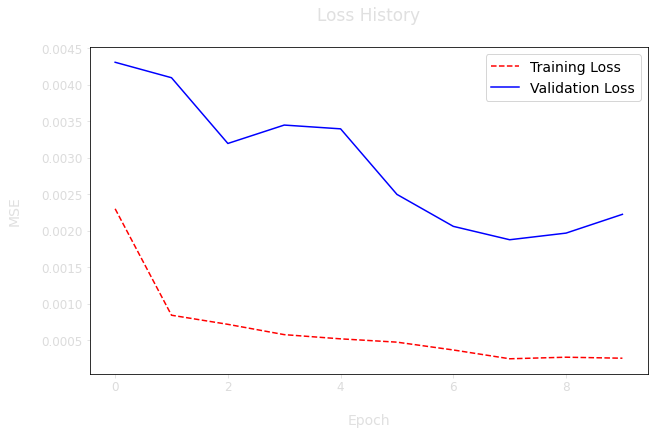

In [13]:
#@title  { form-width: "250px" }
epochs =    10  #@param {type:"integer"}
learning_rate = 1e-3  #@param {type:"number"}

save_path = f"saved_model_{datetime.today().strftime('%Y-%m-%d-%H-%M-%S')}"
tf.keras.backend.clear_session()

# building and compiling
model = MultiLSTM()
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              metrics=[])
                       #tf.metrics.MeanAbsoluteError()]) 
                       #tf.metrics.MeanAbsolutePercentageError()])

# training
history = model.fit(
    multi_data.tf_datasets["train"].shuffle(buffer_size=multi_data.size["train"]), 
    epochs=epochs,
    validation_data=(val_inputs, val_outputs),
    callbacks=[ClearCallback(),
               ModelCheckpoint(filepath=os.path.join(save_path, "checkpoint_best"), 
                                                     monitor='val_loss', 
                                                     verbose=1, save_best_only=True)],
)

# restoring the checkpoint of the best model
model.load_weights(os.path.join(save_path, "checkpoint_best"))

# saving the model
model.save(os.path.join(save_path, "full_save"))
model.custom_save(save_path)
shutil.make_archive(save_path, "zip", save_path)

# downloading the model (Colab only)
if COLAB: 
  files.download(f"{save_path}.zip")

# visualizing loss history
clear_output(wait=True)
print(history.history)

plt.rc('xtick',labelsize=12, color="#DCDCDC")
plt.rc('ytick',labelsize=12, color="#DCDCDC")
plt.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), history.history["loss"], 'r--')
plt.plot(range(epochs), history.history["val_loss"], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])

plt.title("Loss History\n", fontsize=17, color="#E0E0E0")
plt.ylabel('MSE\n', fontsize=14, color="#E0E0E0")
plt.xlabel('\nEpoch', fontsize=14, color="#E0E0E0")
plt.show();

if COLAB: Javascript("google.colab.output.setIframeHeight('200px');")

## **4) Evaluating on all the stocks**

In [14]:
loss = {}
for mode in ["train", "val", "test"]:
    loss[mode] = model.evaluate(multi_data.tf_datasets[mode])

loss = pd.Series(loss.values(), index=loss.keys())
print("\n\n>>> Loss value (on the normalized data):")
loss

59/59 [==============================] - 2s 33ms/step - loss: 0.0114


>>> Loss value (on the normalized data):


train    0.000222
val      0.001877
test     0.011408
dtype: float64

In [ ]:
results, predictions = {}, {}
i = 0
for stk, sdata in multi_data.stocks:
    clear_output(wait=True)
    print(f"[{100*(i+1) / len(multi_data.stocks) : .0f}%] Evaluating stock {i+1} of {len(multi_data.stocks)}... ", end="")
    i += 1

    results[stk], predictions[stk] = {}, {}
    for mode in ["train", "val", "test"]:
        predictions[stk][mode], results[stk][mode] = eval(model, 
                                                          sdata, mode)
    print("done!")

print("\nResults: ")
results

## **5) Visualizing results for individual stocks**

#### **5.1) Training data**

In [20]:
symbols = ["^BVSP", "^DJI", "^HSI"]

[^BVSP] Training Data

#########################

[> GENERAL <]
   . MAE:   831
   . MAPE:  1.4188%
   . MSE:   1119212

#########################

[> OPEN <]
   . MAE:   623
   . MAPE:  1.0472%
   . MSE:   654493
   . Tendency Accuracy:  72.4032%

#########################

[> LOW <]
   . MAE:   844
   . MAPE:  1.4890%
   . MSE:   1245871
   . Tendency Accuracy:  51.1827%

#########################

[> HIGH <]
   . MAE:   1027
   . MAPE:  1.7204%
   . MSE:   1457271
   . Tendency Accuracy:  50.9770%

#########################





[^DJI] Training Data

#########################

[> GENERAL <]
   . MAE:   189
   . MAPE:  1.3155%
   . MSE:   47838

#########################

[> OPEN <]
   . MAE:   184
   . MAPE:  1.2128%
   . MSE:   43389
   . Tendency Accuracy:  59.9866%

#########################

[> LOW <]
   . MAE:   184
   . MAPE:  1.3755%
   . MSE:   50942
   . Tendency Accuracy:  49.8991%

#########################

[> HIGH <]
   . MAE:   198
   . MAPE:  1.3584%
   . MSE:   49183

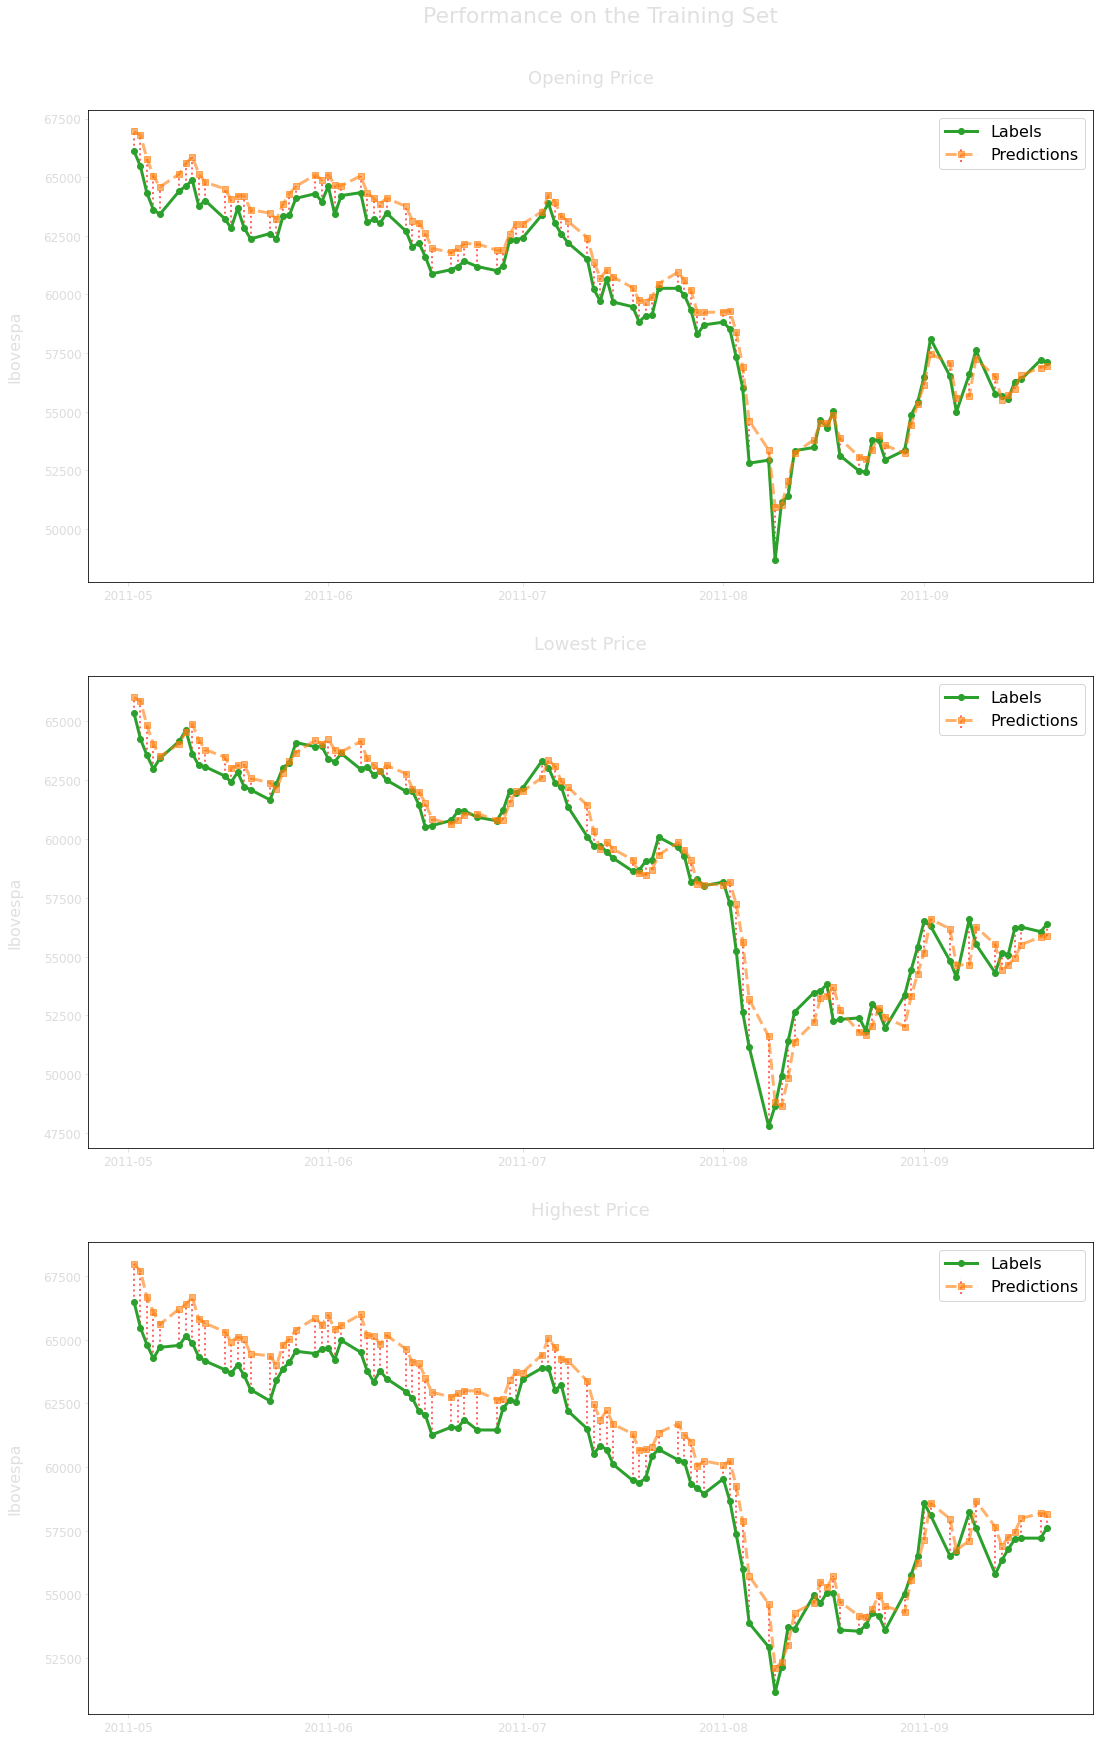

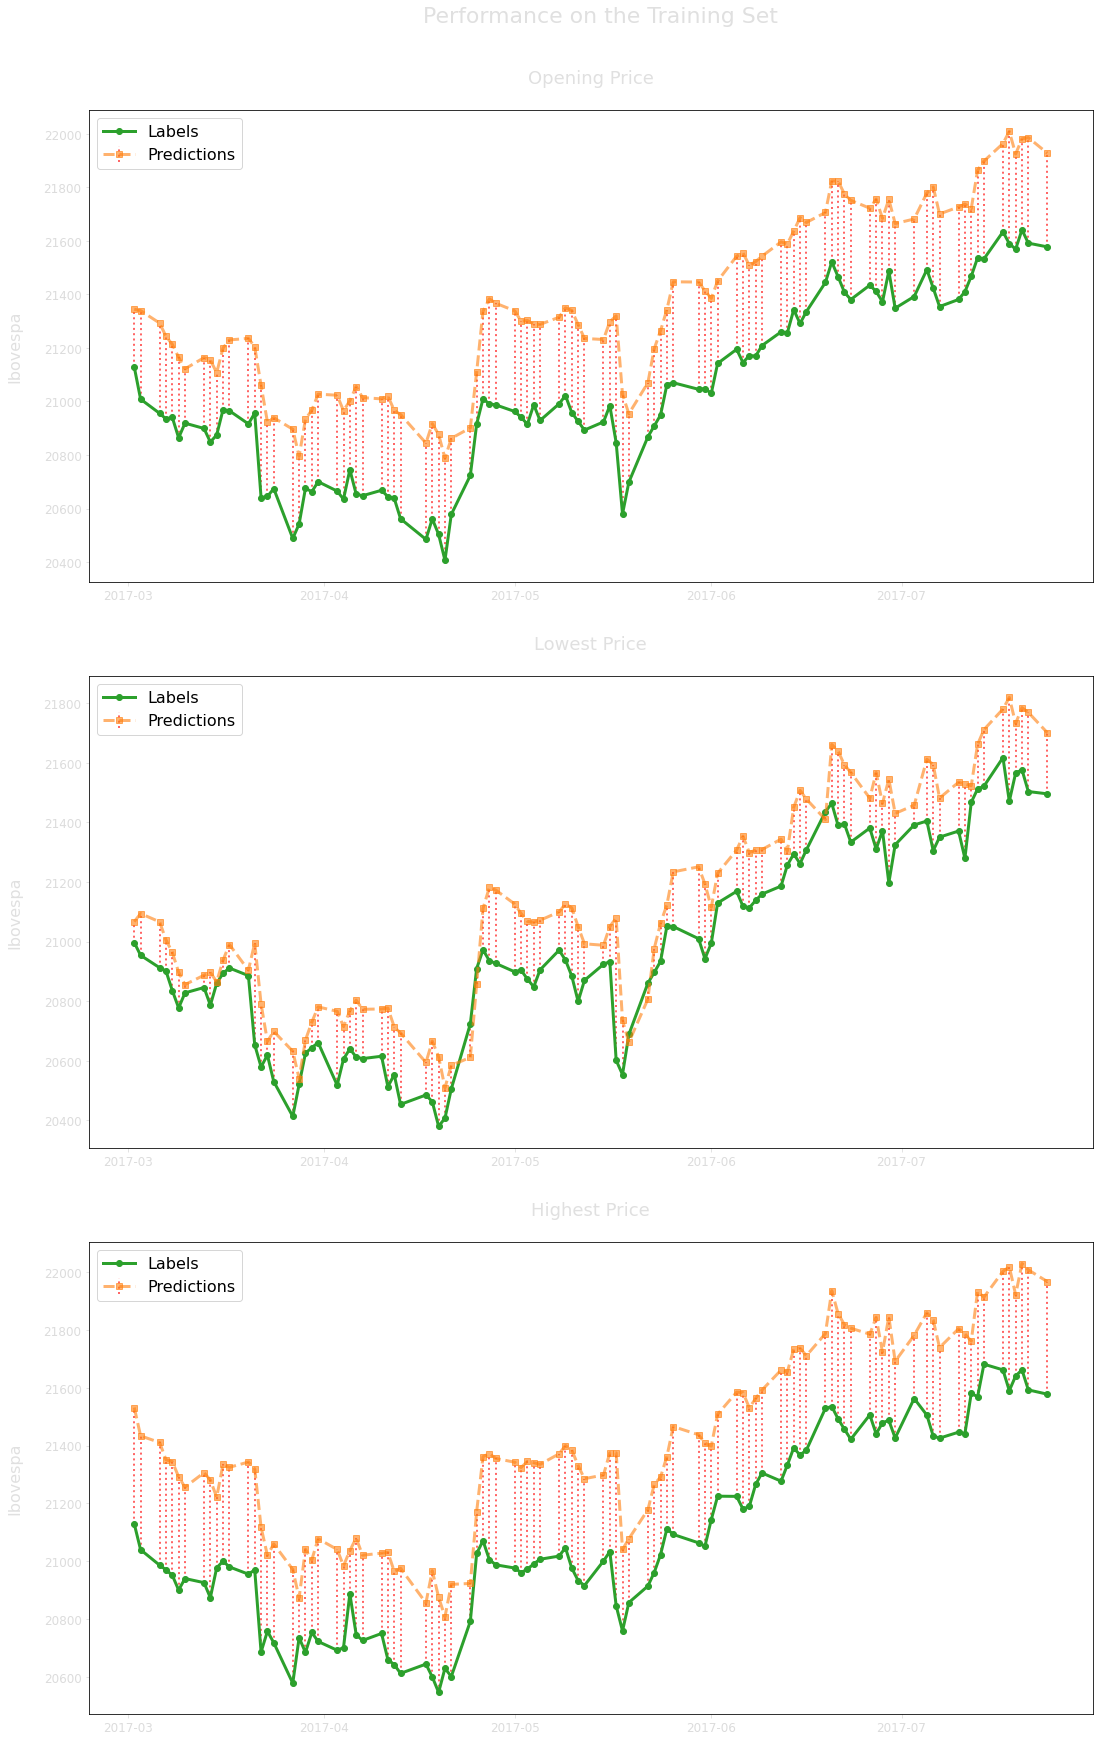

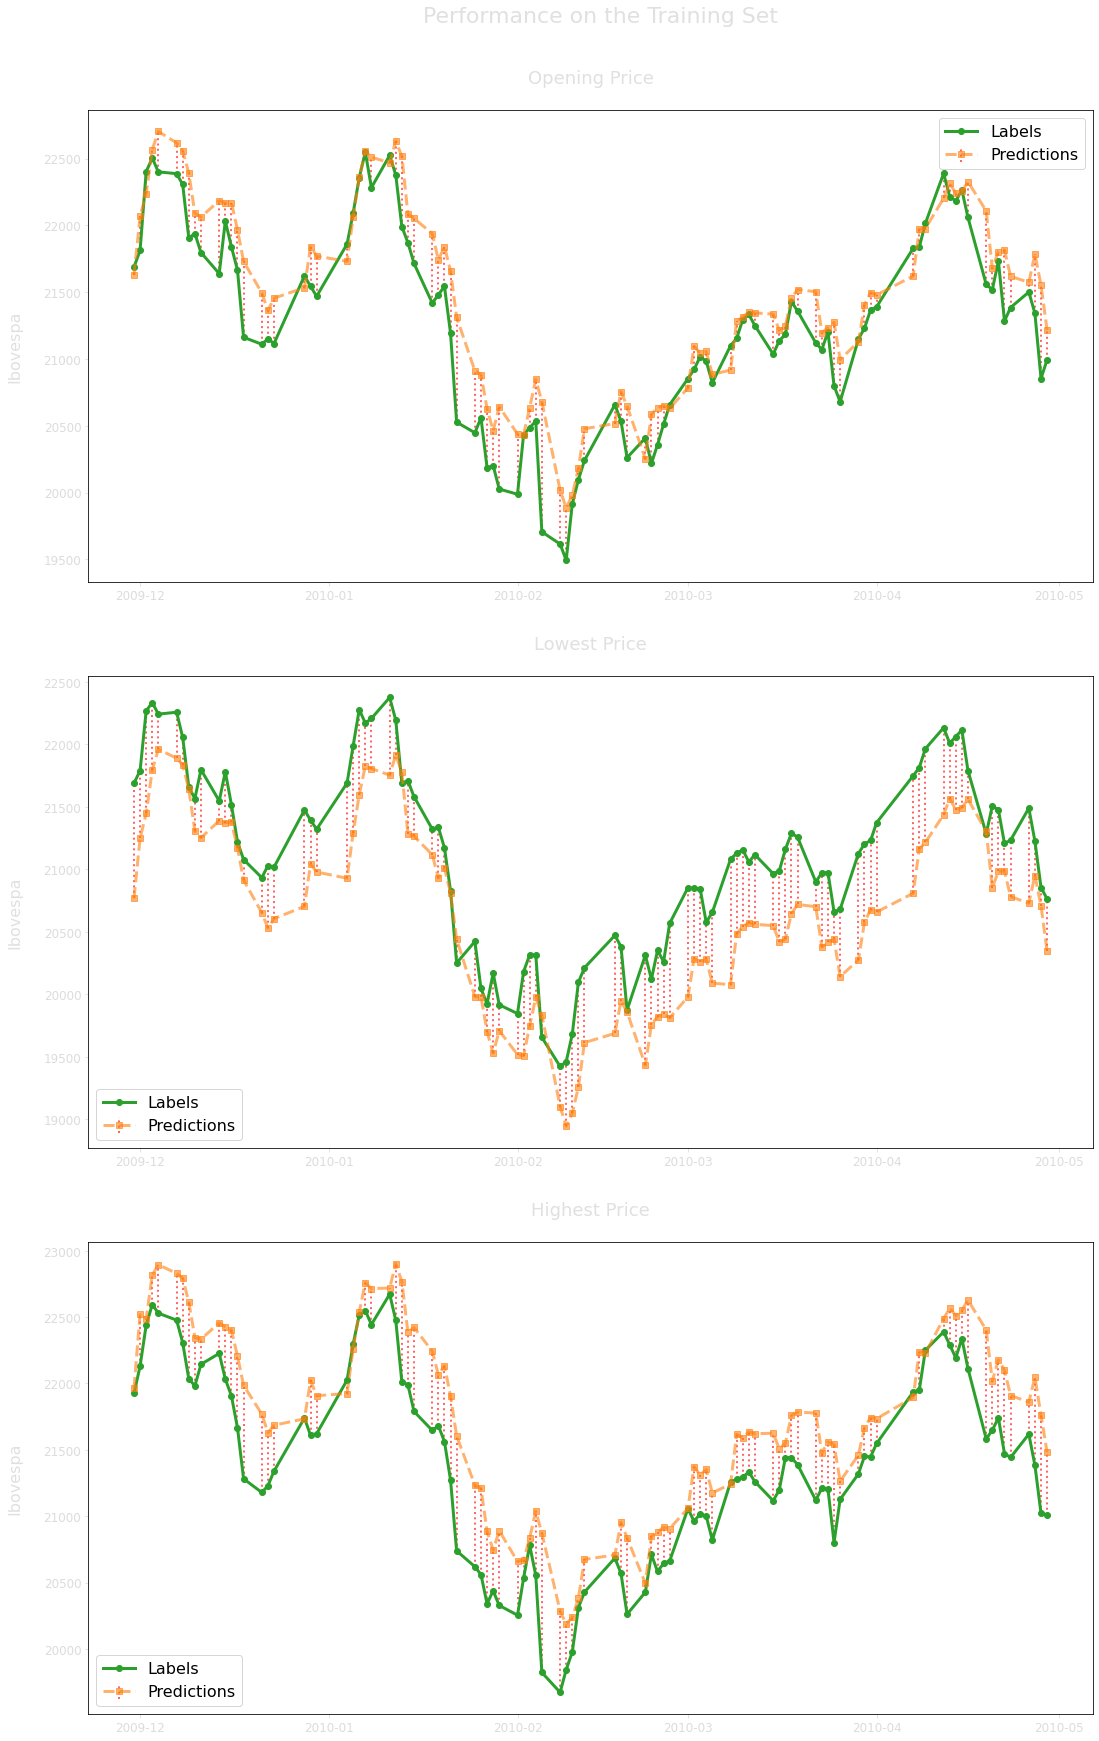

In [21]:
for symb in symbols:
  print(f"[{symb}] Training Data\n")
  eval_print(results[symb]["train"])
  eval_plot(predictions[symb]["train"], 
            multi_data[symb].raw_train["labels"], 
            start_date="random", 
            plot_samples=100, 
            title="Performance on the Training Set")
  print("\n\n\n" + "="*100 + "\n\n")

if COLAB: Javascript("google.colab.output.setIframeHeight('250px');")

#### **5.2) Validation data**

[^BVSP] Validation Data

#########################

[> GENERAL <]
   . MAE:   2287
   . MAPE:  2.2154%
   . MSE:   10099131

#########################

[> OPEN <]
   . MAE:   2077
   . MAPE:  1.9901%
   . MSE:   8582002
   . Tendency Accuracy:  62.5369%

#########################

[> LOW <]
   . MAE:   2605
   . MAPE:  2.5945%
   . MSE:   12740074
   . Tendency Accuracy:  49.5575%

#########################

[> HIGH <]
   . MAE:   2179
   . MAPE:  2.0617%
   . MSE:   8975317
   . Tendency Accuracy:  51.6224%

#########################





[^DJI] Validation Data

#########################

[> GENERAL <]
   . MAE:   260
   . MAPE:  1.0348%
   . MSE:   174649

#########################

[> OPEN <]
   . MAE:   225
   . MAPE:  0.8973%
   . MSE:   110825
   . Tendency Accuracy:  65.3179%

#########################

[> LOW <]
   . MAE:   307
   . MAPE:  1.2491%
   . MSE:   253541
   . Tendency Accuracy:  56.6474%

#########################

[> HIGH <]
   . MAE:   247
   . MAPE:  0.9579%
   .

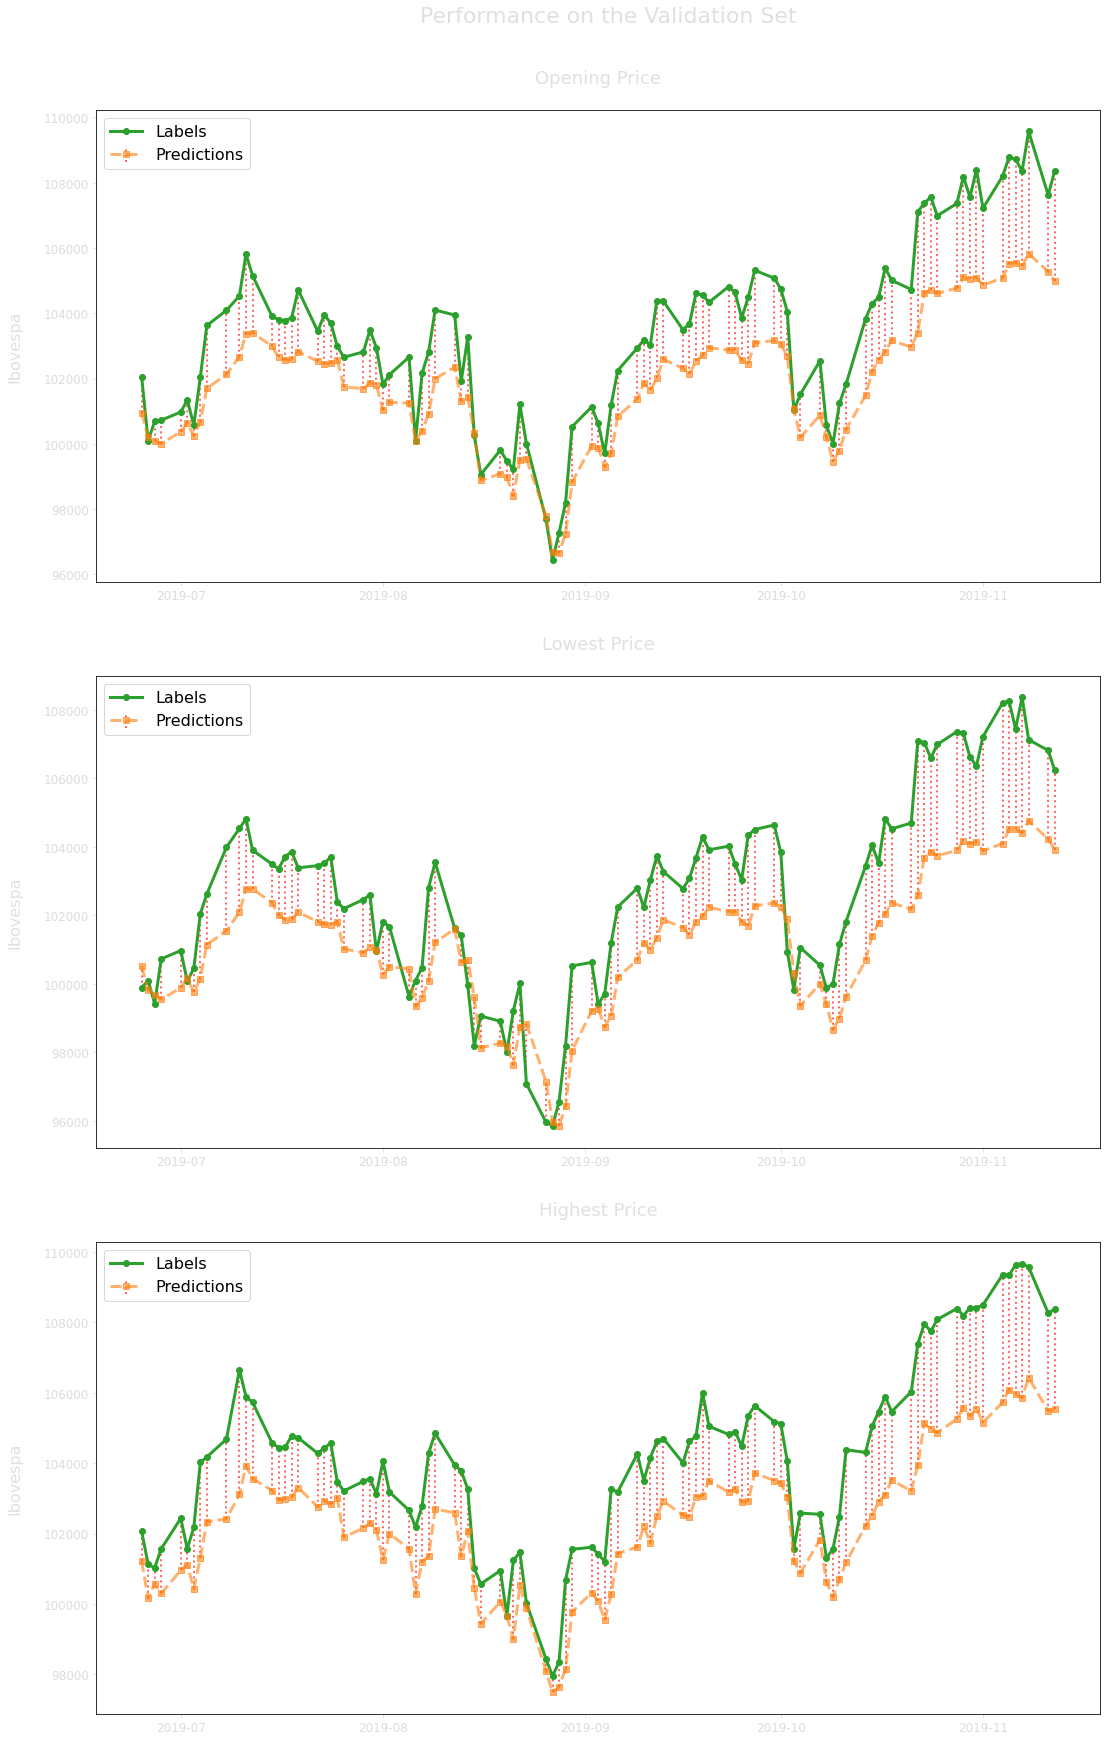

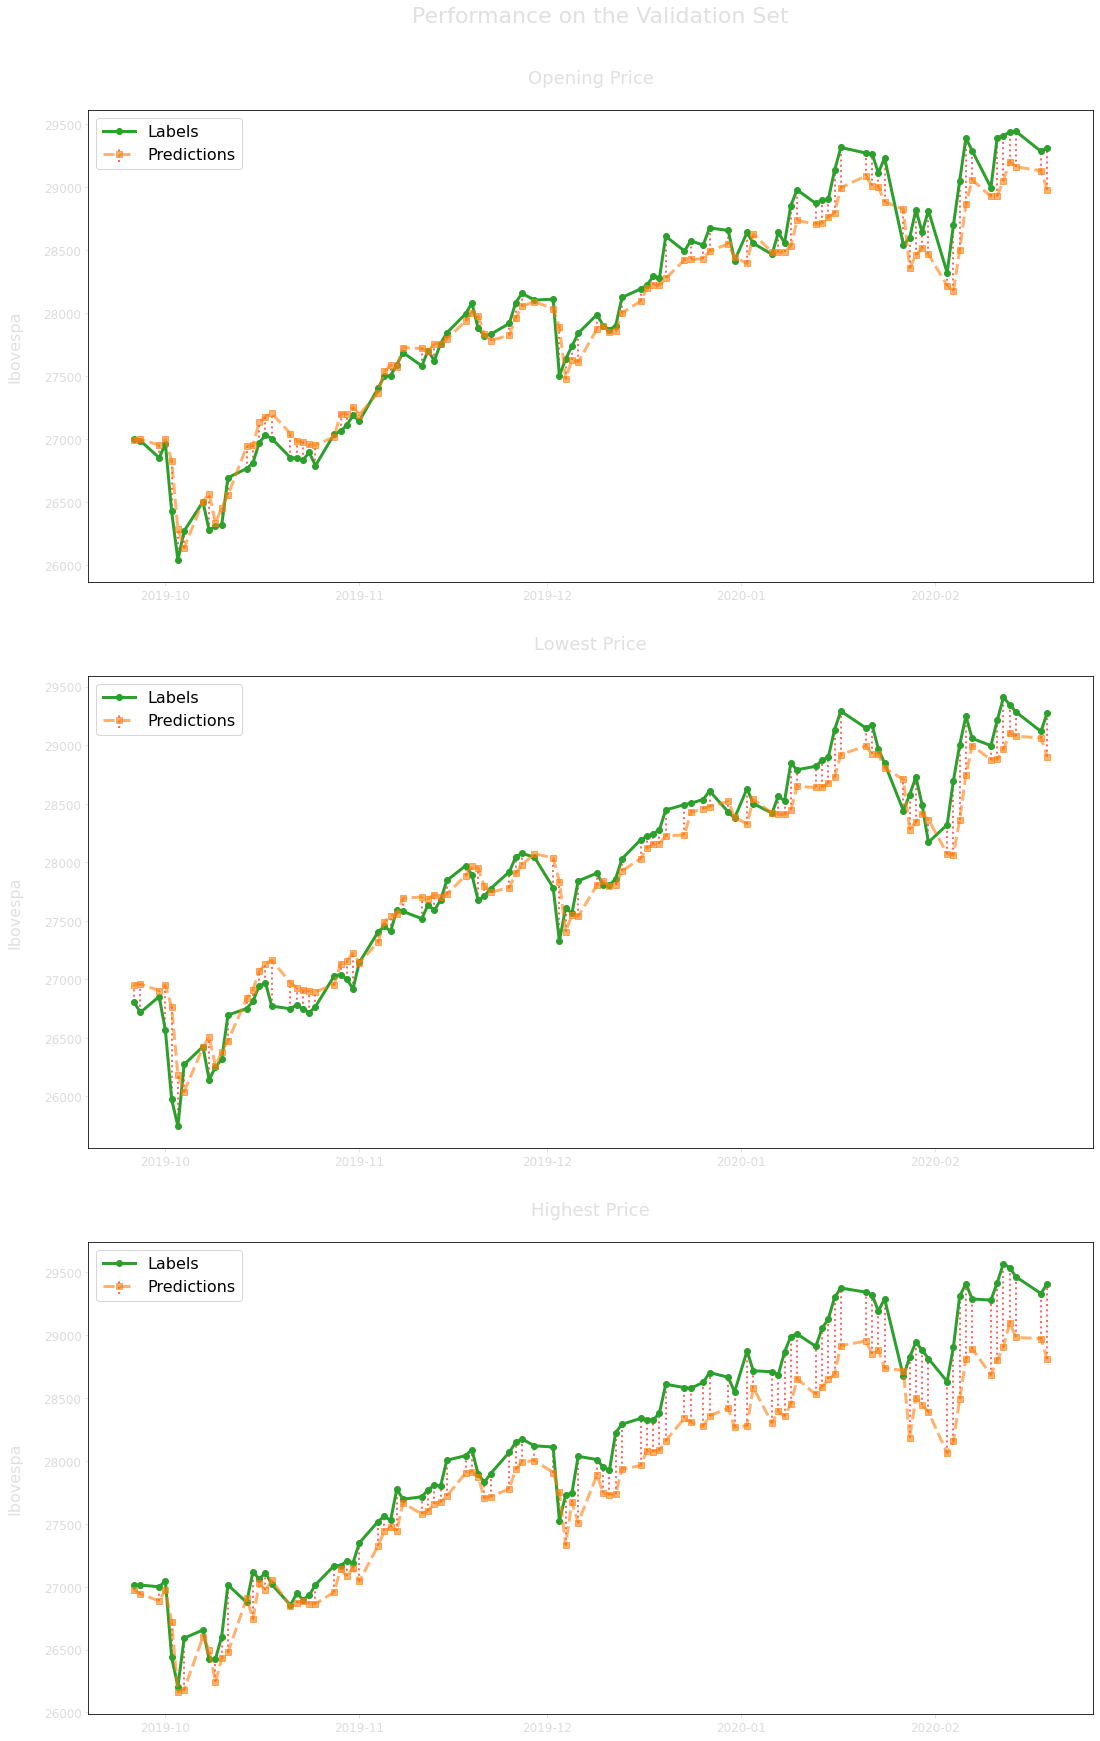

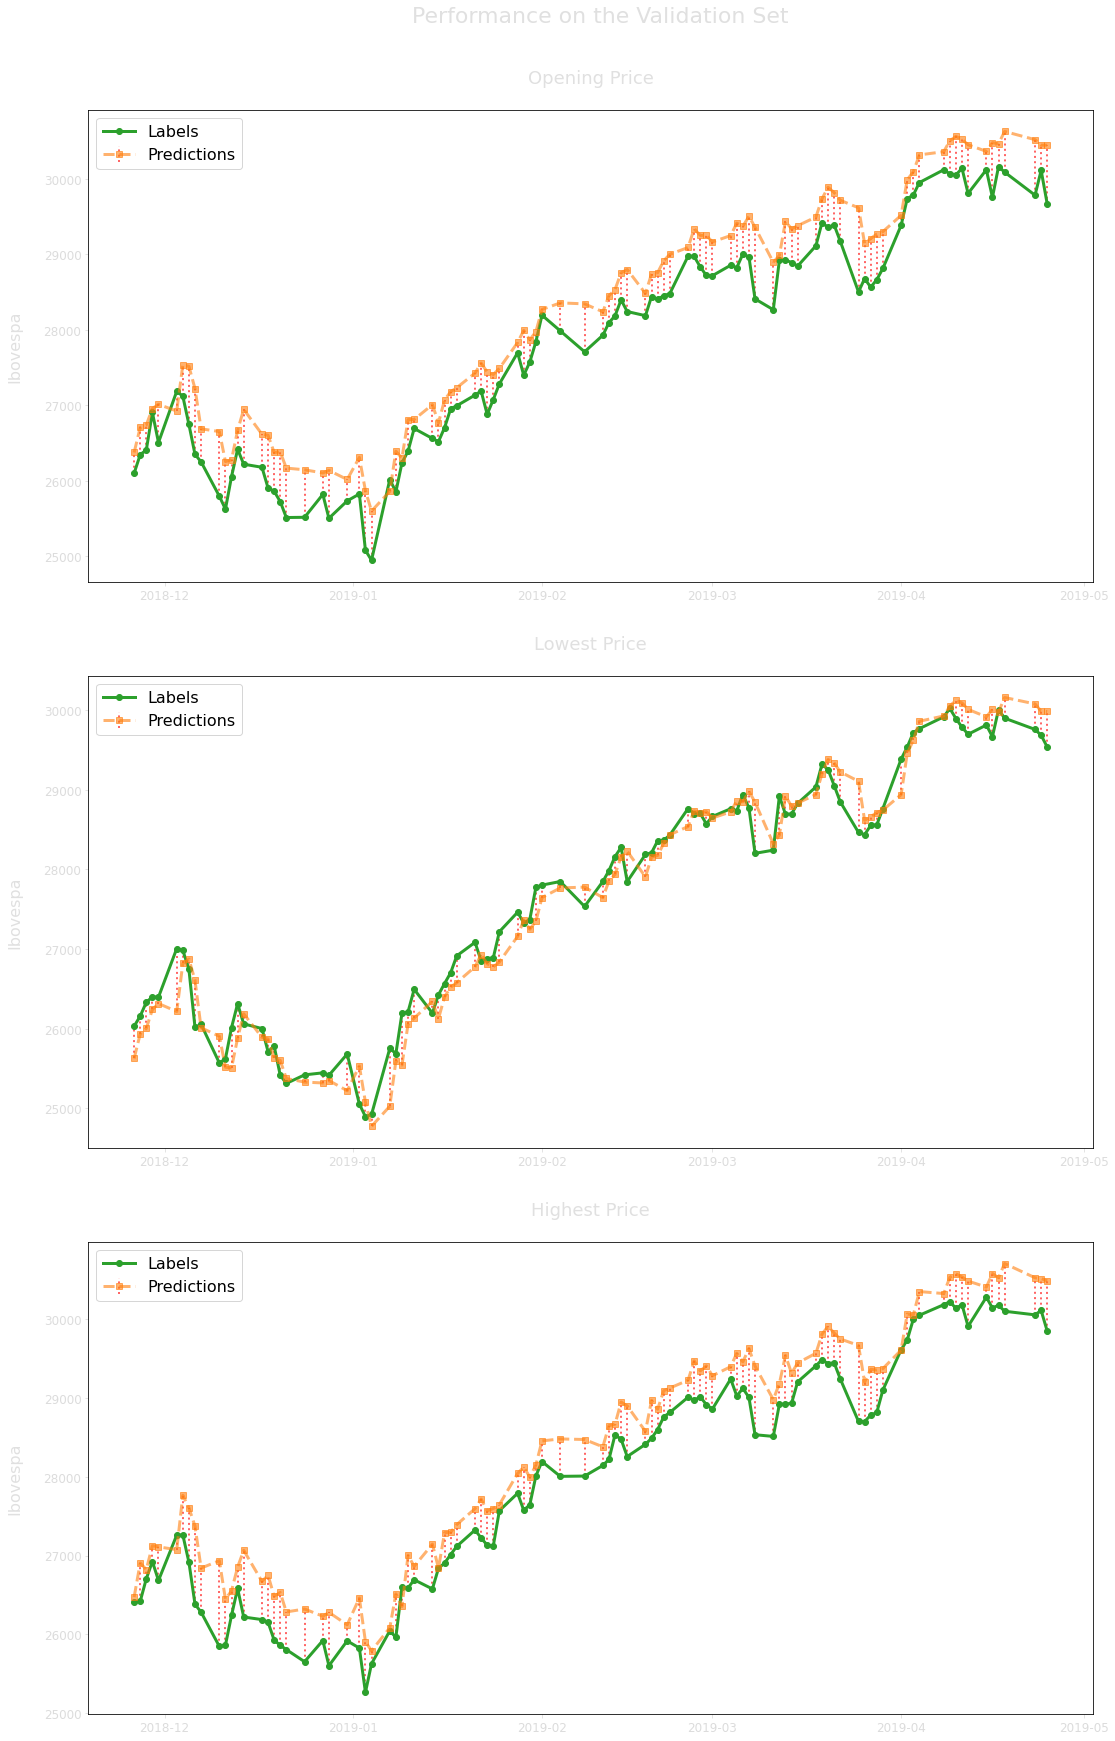

In [22]:
for symb in symbols:
  print(f"[{symb}] Validation Data\n")
  eval_print(results[symb]["val"])
  eval_plot(predictions[symb]["val"], 
            multi_data[symb].raw_val["labels"], 
            start_date="random", 
            plot_samples=100, 
            title="Performance on the Validation Set")
  print("\n\n\n" + "="*100 + "\n\n")

if COLAB: Javascript("google.colab.output.setIframeHeight('250px');")

#### **5.3) Test data**

[^BVSP] Test Data

#########################

[> GENERAL <]
   . MAE:   1359
   . MAPE:  1.4334%
   . MSE:   3217840

#########################

[> OPEN <]
   . MAE:   1148
   . MAPE:  1.2018%
   . MSE:   2209851
   . Tendency Accuracy:  70.8333%

#########################

[> LOW <]
   . MAE:   1414
   . MAPE:  1.5457%
   . MSE:   3829735
   . Tendency Accuracy:  60.7143%

#########################

[> HIGH <]
   . MAE:   1516
   . MAPE:  1.5527%
   . MSE:   3613935
   . Tendency Accuracy:  56.5476%

#########################





[^DJI] Test Data

#########################

[> GENERAL <]
   . MAE:   307
   . MAPE:  1.1678%
   . MSE:   171344

#########################

[> OPEN <]
   . MAE:   243
   . MAPE:  0.9238%
   . MSE:   103200
   . Tendency Accuracy:  70.1754%

#########################

[> LOW <]
   . MAE:   327
   . MAPE:  1.2801%
   . MSE:   204317
   . Tendency Accuracy:  57.8947%

#########################

[> HIGH <]
   . MAE:   351
   . MAPE:  1.2997%
   . MSE:   206514

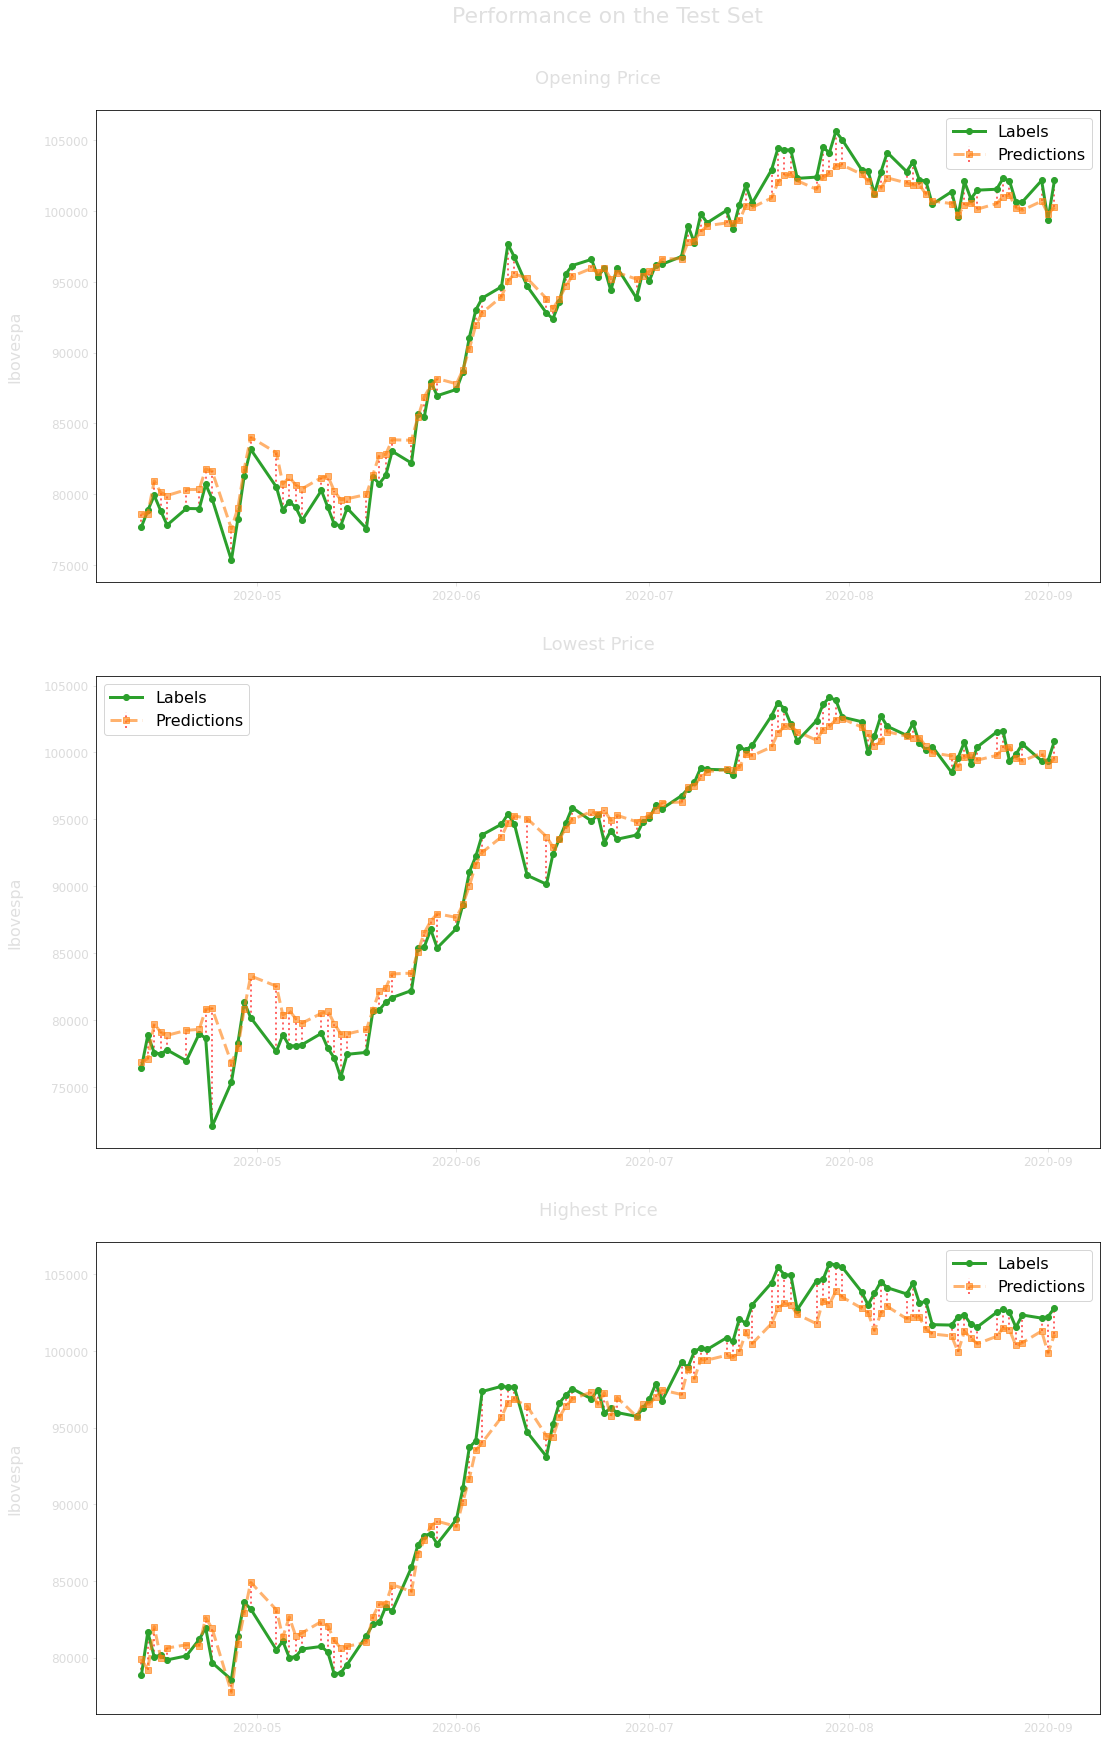

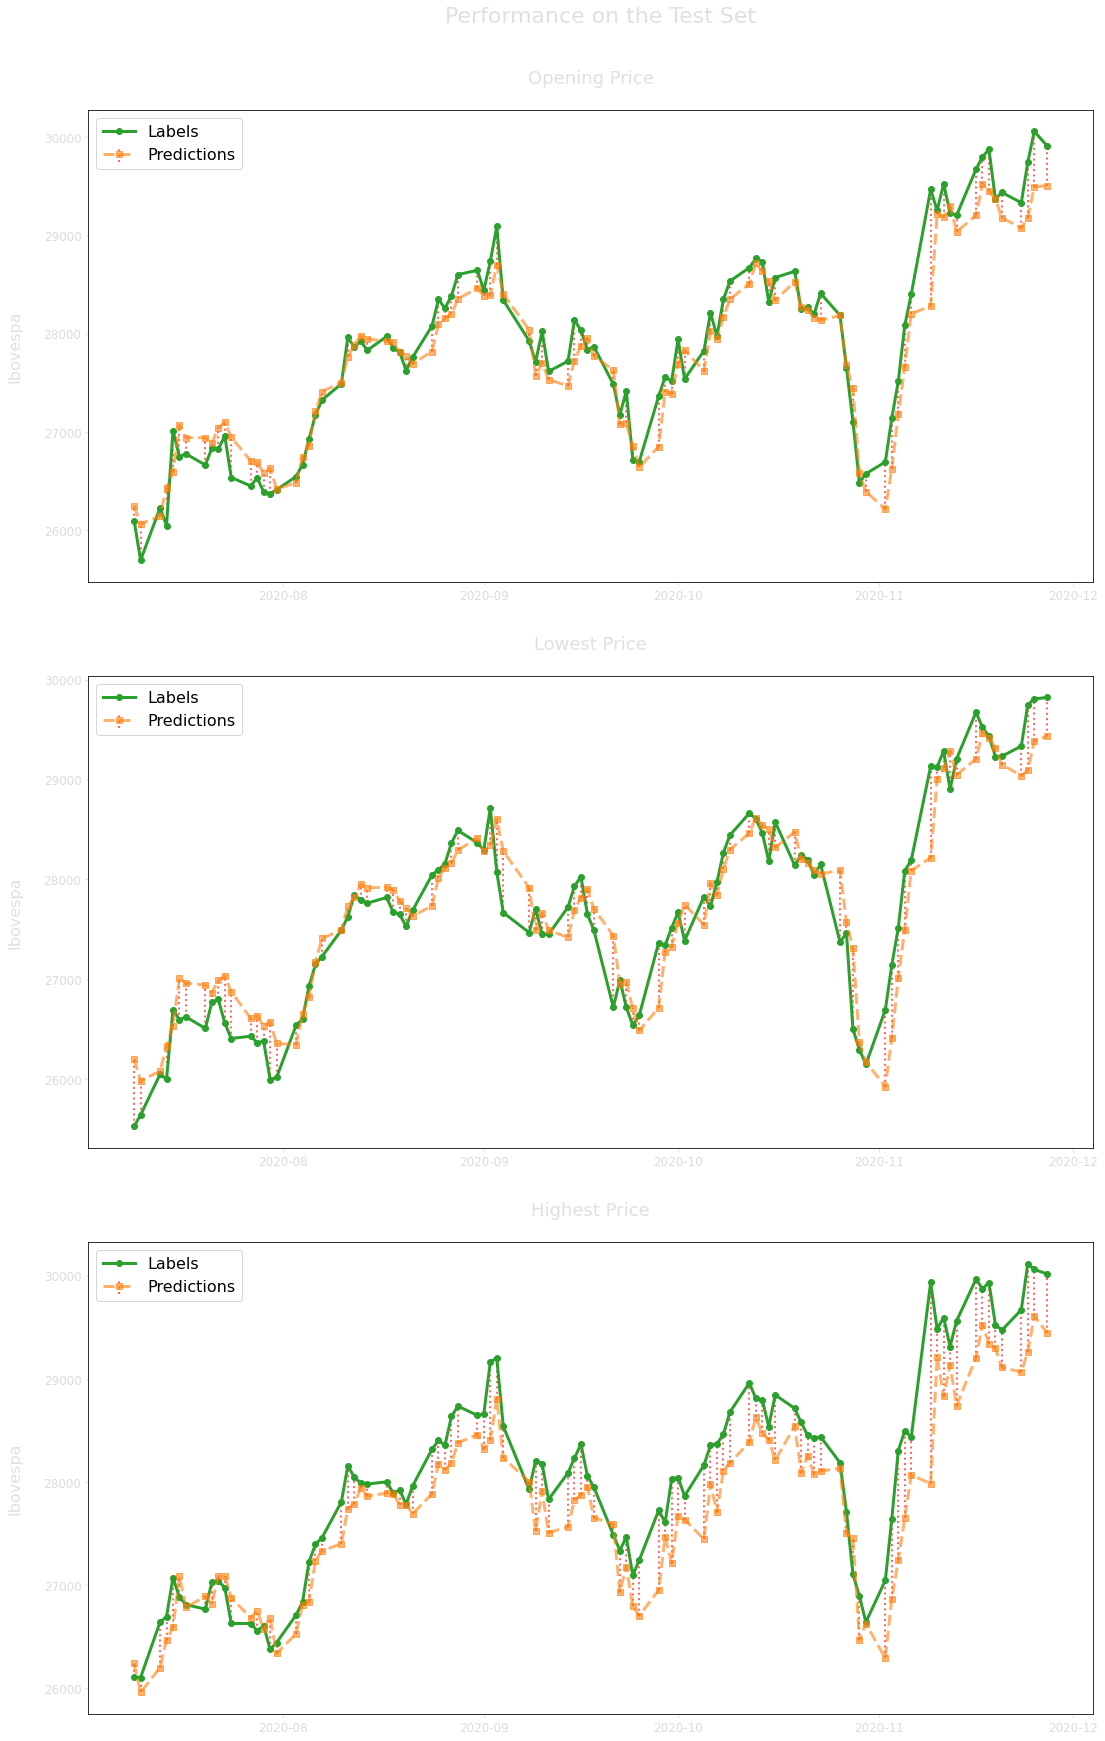

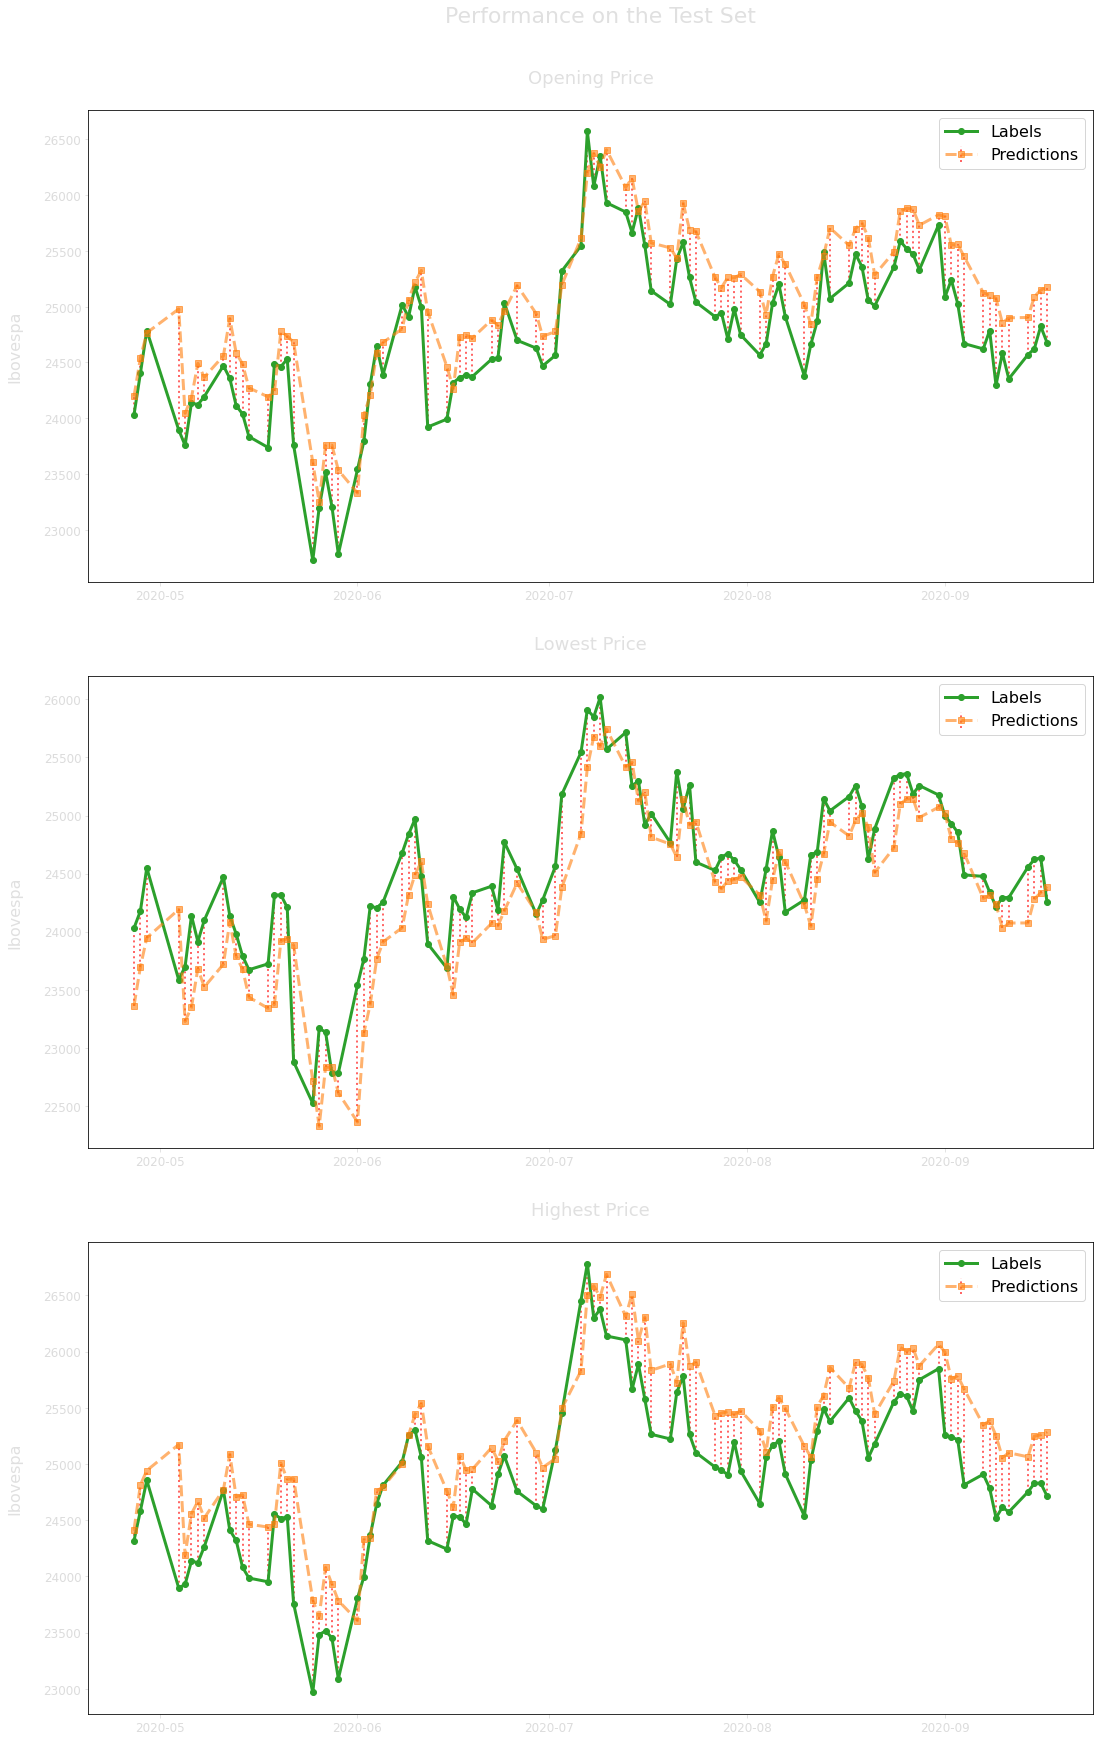

In [23]:
for symb in symbols:
  print(f"[{symb}] Test Data\n")
  eval_print(results[symb]["test"])
  eval_plot(predictions[symb]["test"], 
            multi_data[symb].raw_test["labels"], 
            start_date="random", 
            plot_samples=100, 
            title="Performance on the Test Set")
  print("\n\n\n" + "="*100 + "\n\n")

if COLAB: Javascript("google.colab.output.setIframeHeight('250px');")